# Encoder/Decoder plots and stats

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp
import scipy.stats as stats
import pandas as pd
from pathlib import Path
from importlib import reload

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns

import statsmodels.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

import TreeMazeAnalyses2,Analyses.tree_maze_functions as tmf
import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Analyses.plot_functions as pf
import TreeMazeAnalyses2.Utils.robust_stats as rs

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual

from joblib import delayed, Parallel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/encoder_decoder/')

In [3]:
%%time
ei = reload(ei)
info = ei.SummaryInfo()

CPU times: user 46.5 ms, sys: 275 µs, total: 46.7 ms
Wall time: 45.2 ms


In [4]:
#info.get_analyses_table(overwrite=True)

In [5]:
def decoder_perf_x_zone(data_table, hue_var, hue_names, metric='bac', hue_name_map=None,  palette=None, legend=True, ax=None):
    
    fontsize=10
    n_hues = len(hue_names)
    if hue_var == 'encoder_type':
        if palette is None:
            palette = sns.color_palette("husl", n_hues)
            
        if hue_name_map is None:
            hue_name_map = {'neural': r'$V$',
                            'Z0':r'$\widehat{V}_{Z_0}$',
                            'Z': r'$\widehat{V}_Z$', 
                            'Z+C':r'$\widehat{V}_{Z \plus C}$',
                            'ZxC':r'$\widehat{V}_{Z x C}$'}
            
    elif hue_var == 'subject':
        if palette is None:
            palette = sns.color_palette('deep', n_hues)
            
        if hue_name_map is None:
            hue_name_map = [f"$s_{i+1}$" for i in range(n_hues)]
            hue_name_map = dict(zip(hue_names, hue_name_map))
            

    if ax is None:
        f,ax=plt.subplots(figsize=(3,2), dpi=300, constrained_layout=True)
    else:
        f = ax.figure

    sns.lineplot(data=data_table, x='zones', y=metric, hue=hue_var, hue_order=hue_names, palette=palette, markers=False, ax=ax)
    
    ax.get_legend().remove()
    ax.set_xticks([0,8,15,19])
    ax.set_ylim([0.38,1.02])
    ax.axhline(0.5, linestyle='--', color='0.3', zorder=1)

    ax.set_xlabel('Zone', fontsize=fontsize)
    if metric == 'bac':
        ax.set_ylabel('BAC', fontsize=fontsize)
        leg_pos = [1.1, 0.1]

    if legend:
        legend_elements = []
        for ii, k in enumerate(hue_names):
            legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[ii], lw=0, label=hue_name_map[k],
                                                markerfacecolor=palette[ii], markersize=3))

        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                     fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)
    
    return f, ax

# new encoder summary version

In [873]:
%%time
ei = reload(ei)
info = ei.SummaryInfo()
enc_res = info.get_zone_encoder_comps(overwrite=False)

CPU times: user 66.4 ms, sys: 17.1 ms, total: 83.4 ms
Wall time: 88 ms


In [874]:
enc_res.loc[enc_res.mean_test < -1, 'mean_test']=np.nan
enc_res.loc[enc_res.mean_null < -1, 'mean_null']=np.nan

In [875]:
enc_res.head()

session_unit_id expt        comp  mean_test  mean_null test_cond null_cond  \
0                0  lag  pos_v_zero   0.080486   0.087822        50         0   
1                1  lag  pos_v_zero   0.018967   0.025332        50         0   
2                0  lag  zero_v_neg   0.087822   0.087725         0       -50   
3                1  lag  zero_v_neg   0.025332   0.018611         0       -50   
4                0  lag   neg_v_pos   0.087725   0.080486       -50        50   

         uz        md subject        session  session_pct_cov unit_type  tt  \
0 -0.529150 -0.006671      Li  Li_T3g_052818              NaN       mua   2   
1 -0.755929 -0.007205      Li  Li_T3g_052818              NaN       mua   2   
2 -0.151186 -0.000767      Li  Li_T3g_052818              NaN       mua   2   
3  0.831522  0.005063      Li  Li_T3g_052818              NaN       mua   2   
4  0.529150  0.006719      Li  Li_T3g_052818              NaN       mua   2   

   tt_cl                       cl_name task  unit_id  
0     11  Li_T3g_052818-tt2_d16.5_cl11  T3g        0  
1     14  Li_T3g_052818-tt2_d16.5_cl14  T3g        1  
2     11  Li_T3g_052818-tt2_d16.5_cl11  T3g        0  
3     14  Li_T3g_052818-tt2_d16.5_cl14  T3g        1  
4     11  Li_T3g_052818-tt2_d16.5_cl11  T3g        0

In [1287]:
fontsize = 8
dpi = 400
single_color = '#2F7A93'

def set_point_legend(ax, colors, labels):
    
    ax.get_legend().remove()
    leg_pos = [0.95, 0.1]
    assert len(colors)==len(labels)
    
    legend_elements = []
    for label, color in zip(labels,colors):
        legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=color, lw=0, label=label,
                                            markerfacecolor=color, markersize=fontsize/4))

    ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=leg_pos, frameon=False,
                 fontsize=fontsize*0.6, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)
   
def get_encoder_labels(exp,score):
    if exp=='lag':
        name_map = {-50:r'$Z_{-50}$', 
                    0:r'$Z_{0}$', 
                    50:r'$Z_{50}$'}
    elif exp =='cue':
        name_map = {'none' : r'$Z$', 
                    'fixed': r'$Z \plus C$', 
                    'inter': r'$Z x C$'}

    elif exp == 'rw':
        name_map = {'none' : r'$Z_i$', 
                    'fixed': r'$Z_i \plus R$', 
                    'inter': r'$Z_i x R$'}
        
    elif exp=='dir':
        name_map = {'none' : r'$Z$', 
                    'fixed': r'$Z \plus D$', 
                    'inter': r'$Z_o x Z_i$'}
        
    if exp=='lag':
        name_map2 = {'pos_v_zero': r'$Z_{50}-Z_{0}$',
                     'zero_v_neg': r'$Z_{0}-Z_{50}$',
                     'neg_v_pos': r'$Z_{-50}-Z_{50}$',
                    }
    else:
        model_types = ['fixed', 'none', 'inter']
        name_map2 = {}
        for ii,jj in zip(model_types,np.roll(model_types,-1)):
            name_map2[f"{ii}_v_{jj}"] = f"({name_map[ii]})-({name_map[jj]})"
            
    return name_map, name_map2

def set_encoder_label_texts(score, exp, ax, fontsize=10):
    
    ax.set_xlabel('Encoder Model', fontsize=fontsize, labelpad=0)
    
    if score in ['mean_test', 'mean_null']:
        ax.set_ylabel(r'$R^2$', fontsize=fontsize, labelpad=0)

    elif score == 'md':
        ax.set_ylabel(r'$\Delta R^2$', fontsize=fontsize, labelpad=0)
    elif score == 'uz':
        ax.set_ylabel(r'$U_{\Delta R^2}$', fontsize=fontsize,labelpad=0)

    name_map, name_map2 = get_encoder_labels(exp,score)
            
    if score in ['uz','md']:
        new_labels = []
        for l in ax.get_xticklabels():
            new_labels.append( name_map2[ l.get_text() ] )
        ax.set_xticklabels(new_labels, fontsize=fontsize, rotation=45)
        pass
    else:
        ax.set_xticklabels(name_map.values(), fontsize=fontsize)

def set_data_to_plot(data, exp, unit_type):
    
    if unit_type=='all':
        data = data[(data.expt==exp) ].copy()
    else:
        data = data[(data.expt==exp) & (data.unit_type==unit_type)].copy()

    if exp != 'lag':
        data['test_cond'] = data['test_cond'].astype(
            pd.api.types.CategoricalDtype(['none', 'fixed', 'inter']))

    return data
    
def set_axes_params(ax, fontsize):
    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize*0.75, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)

def remove_quartile_lines_violin(ax, median_lw):
    s = np.zeros((len(ax.get_children()),2))-1
    ax_artists = ax.get_children()

    for ii, l in enumerate(ax_artists):
        if isinstance(l, mpl.lines.Line2D):
            s[ii] = l._dashSeq

    median_lines_idx = np.where(s[:,0]==s.max())[0]
    quartile_lines_idx = np.where(s>0)[0]
    quartile_lines_idx = np.setdiff1d(quartile_lines_idx, median_lines_idx)

    for ii in median_lines_idx:
        ax_artists[ii].set_lw(median_lw)
        ax_artists[ii].set_ls('-')

    for jj in quartile_lines_idx:
        ax_artists[jj].remove()
        
    for ch in ax.get_children():
        if isinstance(ch, mpl.collections.PolyCollection):
            ch.set_edgecolor('0.1')
            ch.set_zorder(2)
            ch.set_facecolor("None")
            
        elif isinstance(ch, mpl.lines.Line2D):
            ch.set_color('0.1')
            ch.set_zorder(10)
            
def get_custom_cm(colors, color_seg_ratios=None, n_colors=100):

    if color_seg_ratios is None:
        color_seg_ratios = np.ones(len(colors)-1)
    
    colors2 = [Color(c) for c in colors]
    colormap = make_colormap(n_colors, colors2, color_seg_ratios)
    colormap2 = [c.color for c in colormap]
    
    return colormap2



In [1288]:
exps = ['cue', 'rw', 'dir']
x_vals = ['test_cond', 'comp']
unit_types = ['all', 'cell', 'mua']

def plot_mean_score_by_unit_type(exp, x_val, unit_type, split_units=False):

    f,ax=plt.subplots(figsize=(1.2,1), dpi=dpi)
    
    if x_val == 'test_cond':
        score = 'mean_test'
    elif x_val == 'comp':
        score  = 'uz'
    
    data=set_data_to_plot(enc_res, exp, unit_type)
    data[score] = data[score].astype(float)
    
    if split_units:
        palette = 'tab10'
        colors = sns.palettes.color_palette(palette,n_colors=2)
        sns.pointplot(data=data, x=x_val, y=score, estimator=np.mean, 
                      hue='unit_type', hue_order=['cell','mua'], ax=ax,dodge=0.25, 
                      palette=palette, scale=0.4, errwidth=1, join=False)
        set_point_legend(ax, colors, ['Cells', 'MUA'])
    else:
        sns.pointplot(data=data, x=x_val, y=score, estimator=np.mean, ax=ax,
                  dodge=0.25, color=single_color, scale=0.4, errwidth=1, join=False)
    
    set_encoder_label_texts(score, exp, ax, fontsize)
    set_axes_params(ax, fontsize)
        
    if score in ['mean_test', 'mean_null']:
        ylims = ax.get_ylim()
        ax.set_ylim([0, ylims[1]])

    return f,ax


def savefig(null):
    f = o.result[0]
    p = info.paths['figures']
    exp = o.children[0].value
    comp = o.children[1].value
    unit_type = o.children[2].value
    figname = f"encoder_means_{exp}_{comp}_{unit_type}"
    figname+='.svg'
    f.savefig(p/figname, dpi=1500, bbox_inches='tight', transparent=True)

o=widgets.interactive(plot_mean_score_by_unit_type, exp=exps, x_val=x_vals, unit_type=unit_types)
save_button = widgets.Button(description='Save Figure')
save_button.on_click(savefig)
display(o,save_button)

interactive(children=(Dropdown(description='exp', options=('cue', 'rw', 'dir'), value='cue'), Dropdown(descrip…

Button(description='Save Figure', style=ButtonStyle())

In [1289]:
def plot_score_units(exp, x_val, unit_type):

    f,ax=plt.subplots(figsize=(1.2,1), dpi=dpi)
    violin_plot_lw=0.3
    median_lw = 0.5
    scatter_point_size = 0.8
    scatter_spread=0.12
    scatter_alpha=0.9
    n_colors=100
    
    ax_pos =  ax.get_position()
    cax = f.add_axes([(ax_pos.x0+ax_pos.width)*1.05,
                          ax_pos.y0+ax_pos.height*0.2,
                         ax_pos.width/15,
                         ax_pos.height/3.8])
    
    data=set_data_to_plot(enc_res, exp, unit_type)
    data = data.reset_index(drop=True)

    if x_val == 'test_cond':
        score = 'mean_test'
        score2 = 'mean_test'
        
        data[score] = data[score].astype(float)
        data[score2] = data[score2].astype(float)
        
        
        metric_label2 = r"$R^2$"
        
        max_pct_val = 0.95
        
        min_val_thr =  0
        min_color_thr = 0.2
        
        max_color_val = data[score2].quantile(max_pct_val)
        color_val_array = np.hstack((-np.inf, np.linspace(0,max_color_val, n_colors-2)))
        
        score_vals = data[score2].copy().values.astype(float)
        dig_scores = np.digitize(score_vals,color_val_array)
        max_val = dig_scores.max()
        dig_scores = dig_scores/max_val     
        dig_scores[np.isnan(score_vals)]=np.nan

        dig_scores[score_vals>=min_val_thr] = (1-min_color_thr)*dig_scores[score_vals>=min_val_thr] + min_color_thr
        dig_scores[score_vals<min_val_thr] = 0
        
        cm = mpl.colors.LinearSegmentedColormap.from_list("m", 
                                                          list(zip([0,min_color_thr,min_color_thr,1], 
                                                                   ['#A7D4E3', 'darkcyan', 'ghostwhite', 'crimson'])),
                                                          N=n_colors)
        

    elif x_val == 'comp':
#         score  = 'md'
#         score2 = 'uz'
        
#         max_pct_val = 0.99
#         min_val_thr = 1
        score = 'uz'
        score2 = 'md'
        metric_label2 = r"$\Delta R^2$"
        max_pct_val = 0.99
        min_val_thr=0
        
                
        score_vals = data[score2].copy().values.astype(float)
        max_color_val = data[score2].abs().quantile(max_pct_val)

        color_val_array = np.hstack((-np.inf, np.linspace(-max_color_val, max_color_val, n_colors-3), np.inf))

        dig_scores = np.digitize(score_vals,color_val_array)
        max_dig_val = dig_scores.max()
        dig_scores = dig_scores/max_dig_val
        dig_scores[np.isnan(score_vals)]=np.nan
        
        min_color_thr1 = np.digitize(-min_val_thr, color_val_array)/max_dig_val
        min_color_thr2 = np.digitize(min_val_thr, color_val_array)/max_dig_val

        color_array = np.array( (0, min_color_thr1, min_color_thr2, 1)  )
        cm = mpl.colors.LinearSegmentedColormap.from_list("m", 
                                                          list(zip(color_array, 
                                                                   ['#00ABA3','ghostwhite' ,'ghostwhite', '#AB0009'])),
                                                          
                                                          N=n_colors)

    data['score2_color_scale'] = dig_scores    
    data[score] = data[score].astype(float)

    sns.violinplot(data=data, x=x_val, y=score, color='white', inner='quartile', 
                   bw=0.5,linewidth=violin_plot_lw, ax=ax)
    remove_quartile_lines_violin(ax, median_lw)

    medians = np.zeros(3)
    x_names = data[x_val].unique()
    for ii,name in enumerate(x_names):

        idx = (data[x_val]==name)
        vals = data.loc[idx, score]
        cols = data.loc[idx, 'score2_color_scale']
        medians[ii] = np.around(vals.median(),2)

        x_locs =  np.random.triangular(-scatter_spread,0,scatter_spread, size=idx.sum()) + ii
        ax.scatter(x_locs, vals, s=scatter_point_size, color=cm(cols), 
                   linewidths=scatter_point_size/10, edgecolors='0.3', zorder=1, alpha=scatter_alpha,
                  rasterized=True)

    set_encoder_label_texts(score, exp, ax, fontsize)
    set_axes_params(ax, fontsize)
        
    pf.get_color_bar_axis(cax, color_array=color_val_array, color_map=cm , skip_labels=True)
    cax.text(1.05,1,np.around(max_color_val,1), fontsize=fontsize/2, ha='left', va='center', transform=cax.transAxes)
    cax.text(1.5,0.5, metric_label2, fontsize=fontsize/1.5, ha='left', va='center', transform=cax.transAxes)
    
    if x_val=='test_cond':
        cax.text(1.05,min_color_thr,0, fontsize=fontsize/2, ha='left', va='center', transform=cax.transAxes)
    elif x_val=='comp':
        cax.text(1.05,0,np.around(-max_color_val,1), fontsize=fontsize/2, ha='left', va='center', transform=cax.transAxes)
        ax.set_xlabel("Encoder Comparisons")

    fig_stats(exp, x_val, unit_type)
    return f,ax

def fig_stats(exp, x_val, unit_type):
    
    vc_formula={}
    if exp=='rw':
        vc_formula['task'] = "0+C(task)"
    else:
        vc_formula['task'] = "1+C(task)"
    vc_formula['session'] = "0+C(session)"

    data=set_data_to_plot(enc_res, exp, unit_type)
    data = data.reset_index(drop=True)

    if x_val == 'test_cond':
        df = data
        df = df[~df['mean_test'].isna()]
        formula = "mean_test ~ 0 + test_cond"
    elif x_val == 'comp':
        df = data
        df = df[~df['uz'].isna()]
        formula = "uz ~ 0 + comp"

    if unit_type=='all':
        formula = formula + " + unit_type"

    mdf = smf.mixedlm(formula=formula, groups='subject', re_formula="1", vc_formula=vc_formula, data=df).fit()
    print(mdf.summary())
    print(mdf.wald_test_terms())
    
def savefig(null):
    f = o.result[0]
    p = info.paths['figures']
    exp = o.children[0].value
    comp = o.children[1].value
    unit_type = o.children[2].value
    figname = f"encoder_{exp}_{comp}_{unit_type}"
    figname+='.svg'
    f.savefig(p/figname, dpi=1500, bbox_inches='tight', transparent=True)

o=widgets.interactive(plot_score_units, exp=exps, x_val=x_vals, unit_type=unit_types)
save_button = widgets.Button(description='Save Figure')
save_button.on_click(savefig)
display(o,save_button)

interactive(children=(Dropdown(description='exp', options=('cue', 'rw', 'dir'), value='cue'), Dropdown(descrip…

Button(description='Save Figure', style=ButtonStyle())

In [1351]:
exp = 'rw'
x_val='test_cond'
unit_type='mua'

if x_val=='test_cond':
    score='mean_test'
else:
    score='uz'
data=set_data_to_plot(enc_res, exp, unit_type)
data = data.reset_index(drop=True)

individual_tests = dict(sums = lambda x: (x>0).sum(),
                        means_above_zero = lambda x: (x>0).mean(),
                        means = lambda x: (x).mean(),
                        tvals = lambda x: np.around(scipy.stats.ttest_1samp(x[~np.isnan(x)],0)[0],2),
                        pvals = lambda x: scipy.stats.ttest_1samp(x[~np.isnan(x)],0)[1],
                       lens = lambda x: x.shape[0])

d_group = data.groupby(x_val)[score]

for test, func in individual_tests.items():
    print()
    print(test)
    print(d_group.apply(func))




sums
test_cond
none     715
fixed    828
inter    676
Name: mean_test, dtype: int64

means_above_zero
test_cond
none     0.638963
fixed    0.739946
inter    0.604111
Name: mean_test, dtype: float64

means
test_cond
none     0.030557
fixed    0.044809
inter    0.031453
Name: mean_test, dtype: float64

tvals
test_cond
none      9.12
fixed    13.47
inter     9.14
Name: mean_test, dtype: float64

pvals
test_cond
none     3.548634e-19
fixed    2.047358e-38
inter    3.066268e-19
Name: mean_test, dtype: float64

lens
test_cond
none     1119
fixed    1119
inter    1119
Name: mean_test, dtype: int64


In [1348]:
455-91

364

In [1321]:
d_group.apply(np.isnan).sum()

34

In [1312]:
def plot_score_units_x_subj(exp, x_val, unit_type):

    pal = sns.color_palette("deep")
    pal = np.array(pal[:])
    subj_nums = {ss:ii for ii,ss in enumerate(info.subjects[:-1])}
    
    f,ax=plt.subplots(figsize=(1.2,1), dpi=dpi)
    violin_plot_lw=0.3
    median_lw = 0.5
    scatter_point_size = 0.8
    scatter_spread=0.15
    scatter_alpha=0.9
    
    data=set_data_to_plot(enc_res, exp, unit_type)
    data = data.reset_index(drop=True)
    data['subj_num']=data.subject.map(subj_nums)

        
    if x_val == 'test_cond':
        score = 'mean_test'        

    elif x_val == 'comp':
        score = 'uz'

    data[score] = data[score].astype(float)

    sns.violinplot(data=data, x=x_val, y=score, color='white', inner='quartile', 
                   bw=0.5,linewidth=violin_plot_lw, ax=ax)
    remove_quartile_lines_violin(ax, median_lw)
    
    x_names = data[x_val].unique()
    for ii,name in enumerate(x_names):
        idx = (data[x_val]==name)
        vals = data.loc[idx, score]
        subj = data.loc[idx, 'subj_num']
        x_locs =  np.random.triangular(-scatter_spread,0,scatter_spread, size=idx.sum()) + ii
        ax.scatter(x_locs, vals, s=scatter_point_size, color=pal[subj], 
                   linewidths=scatter_point_size/10, edgecolors='0.3', zorder=1, alpha=scatter_alpha)

    set_encoder_label_texts(score, exp, ax, fontsize)
    set_axes_params(ax, fontsize)
    
    legend_params = dict(handlelength = 0.25, handletextpad=0.2, bbox_to_anchor=[1.0,0.5], loc='center left',
                         frameon=False, fontsize=fontsize/2, markerscale=scatter_point_size, labelspacing=0.3)

    legend_elements = []
    for ss, ii in subj_nums.items():
        legend_elements.append(plt.Line2D([0],[0], marker='o', markersize=fontsize/3, 
                                          lw=0, mew=0,color=pal[ii], label=f"s$_{{{ii+1}}}$") )
        
    l1 = ax.legend(handles=legend_elements, **legend_params)

    return f,ax

def savefig(null):
    f = o.result[0][0]
    p = info.paths['figures']
    exp = o.children[0].value
    comp = o.children[1].value
    unit_type = o.children.value
    figname = f"encoder_x_subj_{exp}_{comp}_{unit_type}"
    figname+='.png'
    f.savefig(p/figname, dpi=1500, bbox_inches='tight', transparent=False)

o=widgets.interactive(plot_score_units_x_subj, exp=exps, x_val=x_vals, unit_type=unit_types)
save_button = widgets.Button(description='Save Figure')
save_button.on_click(savefig)
display(o,save_button)


interactive(children=(Dropdown(description='exp', options=('cue', 'rw', 'dir'), value='cue'), Dropdown(descrip…

Button(description='Save Figure', style=ButtonStyle())

In [1043]:
unit_type='all'
exp='rw'
comp = 'inter_v_fixed'

data=set_data_to_plot(enc_res, exp, unit_type)
data = data.reset_index(drop=True)

#df = data[data.comp==comp].groupby(["subject","session", "task", "unit_type"], observed=True).mean().reset_index()
#df = data.groupby(["subject","session", "task", "unit_type", "comp"], observed=True).mean().reset_index()
df = data
vc_formula={}
if exp=='rw':
    vc_formula['task'] = "0+C(task)"
else:
    vc_formula['task'] = "1+C(task)"
vc_formula['session'] = "0+C(session)"

if unit_type=='all':
    mdf = smf.mixedlm(formula="uz ~ 0 + comp + unit_type", groups='subject', re_formula="1", vc_formula=vc_formula, data=df).fit()
    r_mat = np.array([[1,-1,0, 0],[0,-1,1, 0],[-1,0,1, 0]])
else:
    mdf = smf.mixedlm(formula="uz ~ 0 + comp", groups='subject', re_formula="1", vc_formula=vc_formula, data=df).fit()
    r_mat = np.array([[1,-1,0],[0,-1,1],[-1,0,1]])
    
print(mdf.summary())
print(mdf.wald_test_terms())

print()
print("Interactions")
print('c0: left>stem')
print('c1: stem>right')
print('c2: right>left')
print(mdf.t_test(r_mat))


            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   uz        
No. Observations:   4722      Method:               REML      
No. Groups:         5         Scale:                0.8412    
Min. group size:    120       Log-Likelihood:       -6324.0108
Max. group size:    1875      Converged:            No        
Mean group size:    944.4                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
comp[fixed_v_none]   1.004    0.507  1.979 0.048  0.009  1.998
comp[inter_v_fixed] -0.850    0.507 -1.676 0.094 -1.844  0.144
comp[none_v_inter]   0.007    0.507  0.013 0.990 -0.988  1.001
unit_type[T.mua]    -0.008    0.030 -0.280 0.780 -0.067  0.050
subject Var          0.802                                    
session Var          0.000                                    
task 

## relation to behavior

In [1109]:
enc_res2 = enc_res.copy()
b_table = info.get_behav_perf()
b_table = b_table.set_index('session')

b_cols = ['pct_correct', 'pct_sw_correct', 'pct_vsw_correct', 'pct_L_correct' ,'pct_R_correct']
for session in b_table.index:
    z_index = enc_res2.session==session 
    enc_res2.loc[z_index, b_cols] = b_table.loc[session, b_cols].values
    

In [1110]:
unit_type='cell'
exp='cue'

data=set_data_to_plot(enc_res2, exp, unit_type)
data = data.reset_index(drop=True)

In [1313]:
def plot_R2_v_behav_regression(exp, test_cond, unit_type):

    pal = sns.color_palette("deep")
    pal = np.array(pal[:])
    subj_nums = {ss:ii for ii,ss in enumerate(info.subjects[:-1])}
    
    f,ax=plt.subplots(figsize=(1.2,1), dpi=dpi)
    violin_plot_lw=0.3
    median_lw = 0.5
    scatter_point_size = 0.8
    scatter_spread=0.15
    scatter_alpha=0.8
    scatter_marker_sizes = (2,8)

    data=set_data_to_plot(enc_res2, exp, unit_type)
    data = data.reset_index(drop=True)
    data = data[data.test_cond==test_cond]
    data = data[~data.mean_test.isna()]
    df = data.groupby(
        ["subject","session"],
        observed=True).mean().reset_index()

    df['n'] = data[data.test_cond==test_cond].groupby(['subject', 'session']).size().reset_index(drop=True)
    
    x = df['mean_test']
    y = df['pct_correct']
    
    m,b = scipy.stats.siegelslopes(y,x)
  
    xx = np.linspace( x.min(),x.max(),100) 
    ax.plot(xx, m*xx + b, linewidth=1, color='0.3', linestyle='-')
    
    yb,yu,xx=pf.get_reg_ci(x,y, eval_x=xx)

    ax.fill_between(xx, yb, yu, alpha=0.4, color='#86b4cb', linewidth=0, zorder=-1)
    
    #sns.regplot(data=df, x='mean_test', y='pct_correct', scatter=False, color=single_color, ax=ax)
    sns.scatterplot(data=df, x='mean_test', y='pct_correct', hue='subject', 
                    hue_order=info.subjects[:-1],palette='deep', ax=ax, size='n',
                   **{'linewidth':0.1, 'edgecolor':'k', 'alpha':scatter_alpha}, sizes=scatter_marker_sizes, legend=False)
    set_axes_params(ax, fontsize)
   
    
    legend_params = dict(handlelength = 0.25, handletextpad=0.2, bbox_to_anchor=[1.0,0.5], loc='center left',
                         frameon=False, fontsize=fontsize*0.75, markerscale=scatter_point_size, labelspacing=0.3)

    legend_elements = []
    for ss, ii in subj_nums.items():
        legend_elements.append(plt.Line2D([0],[0], marker='o', markersize=fontsize/3, 
                                          lw=0, mew=0,color=pal[ii], label=f"s$_{{{ii+1}}}$") )
        
    l1 = ax.legend(handles=legend_elements, **legend_params)

    r = np.around(rs.kendall(x,y),2)
    ax.text(0.9, 0.05, r"$\tau$={}".format(r), fontsize=fontsize*0.75, transform=ax.transAxes)
    
    name_map,_ = get_encoder_labels(exp, score='mean_test')
    ax.set_xlabel(r"$\widebar{R^2}_{se}$" + ' ' + name_map[test_cond], fontsize=fontsize, labelpad=0)
    ax.set_ylabel(r"$p_{se}(\%)$", fontsize=fontsize, labelpad=0)
    
    return f, ax

def savefig(null):
    f = o.result[0]
    p = info.paths['figures']
    exp = o.children[0].value
    test_cond = o.children[1].value
    unit_type = o.children[2].value
    figname = f"encoder_mean_score_x_subj_behav_{exp}_{test_cond}_{unit_type}"
    figname+='.svg'
    f.savefig(p/figname, dpi=1500, bbox_inches='tight', transparent=True)

o=widgets.interactive(plot_R2_v_behav_regression, exp=exps, test_cond=['fixed','none','inter'], unit_type=unit_types)
save_button = widgets.Button(description='Save Figure')
save_button.on_click(savefig)
display(o,save_button)

interactive(children=(Dropdown(description='exp', options=('cue', 'rw', 'dir'), value='cue'), Dropdown(descrip…

Button(description='Save Figure', style=ButtonStyle())

In [1079]:
def logit(p):
    return np.log(p/(1-p))

df["logit_pct_correct"] = logit(df['pct_correct'])
df = df[ ~df['logit_pct_correct'].isna() ].reset_index(drop=True)

smf.ols(formula="logit_pct_correct ~ 1 +  mean_test*test_cond", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      logit_pct_correct   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     5.382
Date:                Tue, 10 May 2022   Prob (F-statistic):           6.61e-05
Time:                        08:15:05   Log-Likelihood:                -1040.2
No. Observations:                1331   AIC:                             2092.
Df Residuals:                    1325   BIC:                             2123.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.9937      0.033     30.326      0.000       0.929       1.058
test_cond[T.fixed]              -0.0026      0.047     -0.056      0.955      -0.095       0.090
test_cond[T.inter]              -0.0068      0.047     -0.146      0.884      -0.098       0.085
mean_test                        0.5480      0.192      2.850      0.004       0.171       0.925
mean_test:test_cond[T.fixed]    -0.0246      0.272     -0.090      0.928      -0.558       0.509
mean_test:test_cond[T.inter]     0.1142      0.275      0.415      0.678      -0.425       0.653
==============================================================================
Omnibus:                       33.223   Durbin-Watson:                   0.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.742
Skew:                          -0.136   Prob(JB):                     5.17e-05
Kurtosis:                       2.469   Cond. No.                         28.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1341]:
data

subject        session task  session_unit_id  mean_test  mean_null  \
0       Al  Al_T3g_092718  T3g              4.5   0.020619   0.020619   
1       Al  Al_T3g_101718  T3g              0.0  -0.112925  -0.112925   
2       Al  Al_T3g_111418  T3g              0.0   0.138840   0.138840   
3       Ca  Ca_T3g_030519  T3g              1.0   0.006808   0.006808   
4       Ca  Ca_T3g_030719  T3g              0.0   0.000194   0.000194   
..     ...            ...  ...              ...        ...        ...   
75      Ne  NE_T3g_071018  T3g              0.0  -0.004334  -0.004334   
76      Ne  NE_T3i_061118  T3i              4.0   0.066781   0.066781   
77      Ne  NE_T3i_062918  T3i              0.0   0.005280   0.005280   
78      Ne  NE_T3i_070218  T3i              0.5   0.006045   0.006045   
79      Ne  NE_T3i_071018  T3i              3.5   0.087002   0.087002   

          uz        md  session_pct_cov    tt  tt_cl  unit_id  pct_correct  \
0  -0.188982 -0.000876              NaN   3.5   10.0   1471.5     0.552632   
1   0.000000 -0.002261              NaN  12.0    5.0   1523.0     0.290323   
2   0.831522  0.006123              NaN  10.0    8.0   1530.0     0.787500   
3  -0.075593  0.003171              NaN  11.0   12.0   1535.0     0.566667   
4   0.226779  0.000715              NaN  11.0    9.0   1544.0     0.533333   
..       ...       ...              ...   ...    ...      ...          ...   
75  0.000000 -0.000374              NaN   7.0    2.0    811.0     0.829787   
76  0.604743  0.006421              NaN   2.0    8.0    641.0     0.505814   
77  1.965415  0.005547              NaN   4.0    6.0    773.0     0.627551   
78 -0.907115 -0.008538              NaN   4.0    3.0    789.5     0.597884   
79  0.869318  0.006829              NaN   9.0   10.5    821.5     0.634409   

    pct_sw_correct  pct_vsw_correct  pct_L_correct  pct_R_correct  
0         0.647059         0.727273       0.421053       0.684211  
1         0.500000         0.000000       1.000000       0.120000  
2         0.821138         0.907216       0.806452       0.767241  
3         0.533333         0.777778       0.647059       0.461538  
4         0.551724         0.733333       0.677419       0.379310  
..             ...              ...            ...            ...  
75        0.809524         0.777778       0.809524       0.846154  
76        0.500000         0.421053       0.352381       0.746269  
77        0.666667         0.722222       0.555556       0.701031  
78        0.632184         0.698113       0.649485       0.543478  
79        0.701031         0.753846       0.537634       0.731183  

[80 rows x 17 columns]

In [1154]:
test_cond='inter'
data=set_data_to_plot(enc_res2, exp, unit_type)
data = data.reset_index(drop=True)
df = data[data.test_cond==test_cond].groupby(
    ["subject","session"],
    observed=True).mean().reset_index()

df['n'] = data[data.test_cond==test_cond].groupby(['subject', 'session']).size().reset_index(drop=True)

x = df['mean_test']
y = df['pct_correct']

In [1157]:
y

0     0.552632
1     0.290323
2     0.787500
3     0.566667
4     0.533333
        ...   
75    0.829787
76    0.505814
77    0.627551
78    0.597884
79    0.634409
Name: pct_correct, Length: 80, dtype: float64

In [1084]:
unit_type='cell'
exp='rw'
score = "mean_test"


data=set_data_to_plot(enc_res2, exp, unit_type)
data = data.reset_index(drop=True)
#df = data[data.comp==comp].groupby(["subject","session", "task", "unit_type"], observed=True).mean().reset_index()
df = data.groupby(["subject","session", "task", "unit_type", "test_cond"], observed=True).mean().reset_index()
# df = data
df = df[ ~df[score].isna() ].reset_index(drop=True)

vc_formula={}
if exp=='rw':
    vc_formula['task'] = "0+C(task)"
else:
    vc_formula['task'] = "1+C(task)"
#vc_formula['session'] = "0+C(session)"

if unit_type=='all':
    mdf = smf.mixedlm(formula="pct_correct ~ 1 + mean_test + test_cond + unit_type", groups='subject', re_formula="1", vc_formula=vc_formula, data=df).fit()
    r_mat = np.array([[1,-1,0, 0],[0,-1,1, 0],[-1,0,1, 0]])
else:
    mdf = smf.mixedlm(formula="pct_correct ~ 1 +  mean_test*test_cond", groups='subject', re_formula="1", vc_formula=vc_formula, data=df).fit()
    r_mat = np.array([[1,-1,0],[0,-1,1],[-1,0,1]])
    
print(mdf.summary())
print(mdf.wald_test_terms())

                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     pct_correct
No. Observations:       233         Method:                 REML       
No. Groups:             5           Scale:                  0.0064     
Min. group size:        9           Log-Likelihood:         233.0633   
Max. group size:        90          Converged:              Yes        
Mean group size:        46.6                                           
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.645    0.031 20.476 0.000  0.583  0.706
test_cond[T.fixed]           -0.012    0.017 -0.671 0.502 -0.045  0.022
test_cond[T.inter]           -0.007    0.017 -0.403 0.687 -0.039  0.026
mean_test                     0.272    0.090  3.013 0.003  0.095  0.448
mean_test

In [879]:
unit_type='cell'
exp='cue'

data=set_data_to_plot(enc_res, exp, unit_type)
data = data.reset_index(drop=True)

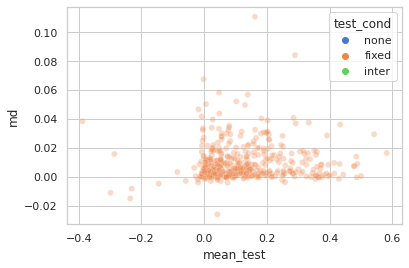

In [880]:
ax = sns.scatterplot(data=data[data.null_cond=='none'], x='mean_test', y='md', hue='test_cond', alpha=0.3)

In [881]:
data

session_unit_id expt           comp  mean_test  mean_null test_cond  \
0                   0  cue   fixed_v_none   0.116149   0.081094     fixed   
1                   1  cue   fixed_v_none   0.397331   0.396665     fixed   
2                   2  cue   fixed_v_none   0.052531   0.043179     fixed   
3                   3  cue   fixed_v_none   0.169876   0.145764     fixed   
4                   4  cue   fixed_v_none   0.102265   0.084723     fixed   
...               ...  ...            ...        ...        ...       ...   
1360                0  cue   none_v_inter  -0.008438  -0.022202      none   
1361                0  cue  inter_v_fixed  -0.022202  -0.002825     inter   
1362                0  cue   fixed_v_none  -0.000106  -0.004486     fixed   
1363                0  cue   none_v_inter  -0.004486  -0.014130      none   
1364                0  cue  inter_v_fixed  -0.014130  -0.000106     inter   

     null_cond        uz        md subject        session  session_pct_cov  \
0         none  1.965415  0.028404      Li  Li_T3g_052918              NaN   
1         none  0.075593  0.000603      Li  Li_T3g_052918              NaN   
2         none  0.453557  0.012123      Li  Li_T3g_052918              NaN   
3         none  1.209486  0.020002      Li  Li_T3g_052918              NaN   
4         none  1.965415  0.020444      Li  Li_T3g_052918              NaN   
...        ...       ...       ...     ...            ...              ...   
1360     inter  1.663044  0.011907      Ca  Ca_T3g_030819              NaN   
1361     fixed -1.814229 -0.017582      Ca  Ca_T3g_030819              NaN   
1362      none  0.982708  0.003815      Ca  Ca_T3g_031219              NaN   
1363     inter  1.133893  0.008564      Ca  Ca_T3g_031219              NaN   
1364     fixed -2.267787 -0.010661      Ca  Ca_T3g_031219              NaN   

     unit_type  tt  tt_cl                         cl_name task  unit_id  
0         cell   2     18    Li_T3g_052918-tt2_d16.5_cl18  T3g        2  
1         cell   8      0    Li_T3g_052918-tt8_d16.25_cl0  T3g        3  
2         cell   8     12   Li_T3g_052918-tt8_d16.25_cl12  T3g        4  
3         cell   8     16   Li_T3g_052918-tt8_d16.25_cl16  T3g        5  
4         cell   8     17   Li_T3g_052918-tt8_d16.25_cl17  T3g        6  
...        ...  ..    ...                             ...  ...      ...  
1360      cell  11     15  Ca_T3g_030819-tt11_d15.75_cl15  T3g     1548  
1361      cell  11     15  Ca_T3g_030819-tt11_d15.75_cl15  T3g     1548  
1362      cell  11      2   Ca_T3g_031219-tt11_d16.25_cl2  T3g     1554  
1363      cell  11      2   Ca_T3g_031219-tt11_d16.25_cl2  T3g     1554  
1364      cell  11      2   Ca_T3g_031219-tt11_d16.25_cl2  T3g     1554  

[1365 rows x 18 columns]

In [900]:
x_val = 'test_cond'
data=set_data_to_plot(enc_res, exp, unit_type)
data = data.reset_index(drop=True)
n_colors=100

if x_val == 'test_cond':
    score = 'mean_test'
    score2 = 'mean_test'
    
    max_pct_val = 0.99
    min_val_thr =  0
    min_color_thr = 0.2

    max_color_val = data[score2].abs().quantile(max_pct_val)
    color_val_array = np.hstack((-np.inf, np.linspace(0,max_color_val, n_colors-2)))

    score_vals = data[score2].copy().values.astype(float)
    dig_scores = np.digitize(score_vals,color_val_array)
    max_val = dig_scores.max()
    dig_scores = dig_scores/max_val     
    dig_scores[np.isnan(score_vals)]=np.nan

    dig_scores[score_vals>=min_val_thr] = (1-min_color_thr)*dig_scores[score_vals>=min_val_thr] + min_color_thr
    #dig_scores = (1-min_color_thr)*dig_scores + min_color_thr
    dig_scores[score_vals<min_val_thr] = 0
    #dig_scores -= min_dig_val_thr
#     dig_scores = (1-min_color_thr)*dig_scores + min_color_thr
#     dig_scores[dig_scores<=min_color_thr] = 0
    
#     max_color_val = np.percentile(data[score2], max_pct_val*100)
#     color_val_array = np.hstack((-np.inf, np.linspace(0,max_score_val, n_colors-2)))

#     score_vals = data[score2].copy().values.astype(float)
#     dig_scores = np.digitize(score_vals,color_val_array)
#     dig_scores = dig_scores/dig_scores.max()
#     dig_scores[dig_scores<=min_pct_val] = -min_pct_val
#     dig_scores[dig_scores>min_pct_val]+= min_pct_val
#     dig_scores = dig_scores/dig_scores.max()        
#     dig_scores[np.isnan(score_vals)]=np.nan     

    cm = mpl.colors.LinearSegmentedColormap.from_list("m", 
                                                      list(zip([0,min_color_thr,min_color_thr,1], 
                                                               ['darkcyan', 'darkcyan', 'ghostwhite', 'crimson'])),
                                                      N=n_colors)

elif x_val == 'comp':
    score  = 'md'
    score2 = 'uz'
    max_pct_val = 0.99
    min_val_thr = 1.96

    max_score_val = np.percentile(np.abs(data[score2]), max_pct_val*100)
    color_val_array = np.hstack((-np.inf, np.linspace(-max_score_val, max_score_val, n_colors-3), np.inf))

    score_vals = data[score2].copy().values.astype(float)
    dig_scores = np.digitize(score_vals,color_val_array)
    
    max_dig_val = dig_scores.max()

    dig_scores = dig_scores/max_dig_val
    dig_scores[np.isnan(score_vals)]=np.nan

    min_color_thr1 = 0.5-np.digitize(-min_val_thr, color_val_array)/max_dig_val
    min_color_thr2 = np.digitize(min_val_thr, color_val_array)/max_dig_val

    color_array = np.array( (0, min_color_thr1, min_color_thr2, 1)  )
    cm = mpl.colors.LinearSegmentedColormap.from_list("m", 
                                                      list(zip(color_array, 
                                                               ['firebrick','ghostwhite' ,'ghostwhite', 'darkslateblue'])),
                                                      N=100)
    
data['score2_color_scale'] = dig_scores
data[score] = data[score].astype(float)

medians = np.zeros(3)
x_names = data[x_val].unique()
for ii,name in enumerate(x_names):

    idx = (data[x_val]==name)
    vals = data.loc[idx, score]
    cols = data.loc[idx, 'score2_color_scale']
    

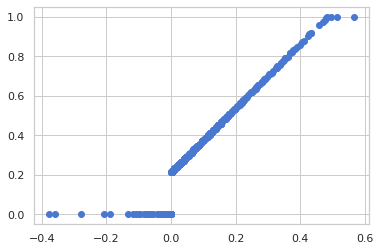

In [901]:
#plt.scatter(data[score2],cm(dig_scores)[:,0])
plt.scatter(vals, cols)


In [182]:


def plot_score_by_unit(data, exp, x_val, score='md', ax=None):

    palette = 'Set1'
    colors = sns.palettes.color_palette(palette,n_colors=2)

    if ax is None:
        f,ax=plt.subplots(figsize=(1.2,1), dpi=300)
        fontsize = 8
    else:
        f = ax.figure
        
    data = data[data.expt==exp].copy()
    
    if exp != 'lag':
        data['test_cond'] = data['test_cond'].astype(
            pd.api.types.CategoricalDtype(['none', 'fixed', 'inter']))
        data['null_cond'] = data['null_cond'].astype(
            pd.api.types.CategoricalDtype(['none', 'fixed', 'inter']))

    data[score] = data[score].astype(float)
        
#     sns.pointplot(data=data, x=x_val, y=score, estimator=np.mean, 
#                   hue='unit_type', hue_order=['cell','mua'], ax=ax,dodge=True, 
#                   palette=palette, scale=0.3, errwidth=1, join=False)
    
#     sns.stripplot(data=data, x=x_val, y=score, 
#                   hue='unit_type', hue_order=['cell','mua'], ax=ax, dodge=True, 
#                   palette=palette, alpha=0.2, size=0.5)

    sns.violinplot(data=data, x=x_val, y=score, inner='quartile', 
                  hue='unit_type', hue_order=['cell','mua'], ax=ax,split=True, linewidth=0.3,
                  palette=palette)
    
    
    ax.set_xlabel('Encoder Model', fontsize=fontsize)
    
    
    if score in ['mean_test', 'mean_null']:
        ax.set_ylabel(r'$R^2$', fontsize=fontsize)
        ylims = ax.get_ylim()
        ax.set_ylim([-0.15, ylims[1]])
    elif score == 'md':
        ax.set_ylabel(r'$\Delta R^2$', fontsize=fontsize)
    elif score == 'uz':
        ax.set_ylabel(r'$Z_{\Delta R^2}$', fontsize=fontsize)


    if exp=='lag':
        name_map = {-50:r'$Z_{-50}$', 
                    0:r'$Z_{0}$', 
                    50:r'$Z_{50}$'}
    elif exp =='cue':
        name_map = {'none' : r'$Z$', 
                    'fixed': r'$Z \plus C$', 
                    'inter': r'$Z x C$'}

    elif exp == 'rw':
        name_map = {'none' : r'$Z_i$', 
                    'fixed': r'$Z_i \plus R$', 
                    'inter': r'$Z_i x R$'}
        
    elif exp=='dir':
        name_map = {'none' : r'$Z$', 
                    'fixed': r'$Z \plus D$', 
                    'inter': r'$Z_o x Z_i$'}
        
    if exp=='lag':
        name_map2 = {'pos_v_zero': r'$Z_{50}-Z_{0}$',
                     'zero_v_neg': r'$Z_{0}-Z_{50}$',
                     'neg_v_pos': r'$Z_{-50}-Z_{50}$',
                    }
    else:
        model_types = ['fixed', 'none', 'inter']
        name_map2 = {}
        for ii,jj in zip(model_types,np.roll(model_types,-1)):
            name_map2[f"{ii}_v_{jj}"] = f"({name_map[ii]})-({name_map[jj]})"

    if score in ['uz','md']:
        new_labels = []
        for l in ax.get_xticklabels():
            new_labels.append( name_map2[ l.get_text() ] )
        ax.set_xticklabels(new_labels, fontsize=fontsize, rotation=45)
        pass
    else:
        ax.set_xticklabels(name_map.values(), fontsize=fontsize)
    
    ax.get_legend().remove()

    leg_pos = [1.1, 0.1]
    legend_elements = [mpl.lines.Line2D([0], [0], marker='o', color=colors[0], lw=0, label='Cell',
                                        markerfacecolor=colors[0], markersize=3),
                       mpl.lines.Line2D([0], [0], marker='o', color=colors[1], lw=0, label='Mua',
                                        markerfacecolor=colors[1], markersize=3),]

    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                 fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)
    
    return f,ax
def plot_score_by_subject(data, x_val, score='score', ax=None):
    subjects = info.subjects[:5]
    n_subjects = len(subjects)
    palette = 'deep'
    colors = sns.palettes.color_palette(palette,n_colors=n_subjects)

    if ax is None:
        f,ax=plt.subplots(figsize=(2,2), dpi=300)
    else:
        f = ax.figure

    sns.pointplot(data=data, x=x_val, y=score, estimator=np.mean, 
                  hue='subject', hue_order=subjects, ax=ax,dodge=0.3, palette=palette, scale=0.5, errwidth=1)
    
    ax.set_ylabel(f'$R^2$', fontsize=fontsize, labelpad=-1)
    ax.set_xlabel('Encoder Model', fontsize=fontsize)

    if x_val=='max_lag':
        name_map = {-50:r'$F_{Z_{-50}}$', 
                    0:r'$F_{Z_{0}}$', 
                    50:r'$F_{Z_{50}}$'}
    elif x_val =='cue_type':
        name_map = {'none' : r'$F_{Z}$', 
                    'fixed': r'$F_{Z \plus C}$', 
                    'inter': r'$F_{Z x C}$'}

    elif x_val == 'rw_type':
        name_map = {'none' : r'$F_{Z_i}$', 
                    'fixed': r'$F_{Z_i \plus R}$', 
                    'inter': r'$F_{Z_i x R}$'}


    ax.set_xticklabels(name_map.values(), fontsize=fontsize)
    ax.get_legend().remove()

    leg_pos = [1.1, 0.1]
    legend_elements=[]
    leg_name_map = [f"$s_{i+1}$" for i in range(n_subjects)]
    leg_name_map = dict(zip(subjects, leg_name_map))
    for ii, ss in enumerate(subjects):
        legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=colors[ii], lw=0, label=leg_name_map[ss],
                                            markerfacecolor=colors[ii], markersize=3))

    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                 fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)

    return f,ax

def plot_scores_vs(data, models, axs=None):

  
    if models=='max_lag':
        vals = [-50, 0, 50]
        name_map = {-50: r'$F_{Z_{-50}}$', 
                    0:   r'$F_{Z_{0}}$', 
                    50:  r'$F_{Z_{50}}$'}
        
        comps = [(0, -50),
                 (50, 0), 
                 (-50,50)]
    elif models =='cue_type':
        vals = ['none', 'fixed', 'inter']
        name_map = {'none' : r'$F_{Z}$', 
                    'fixed': r'$F_{Z \plus C}$', 
                    'inter': r'$F_{Z x C}$'}
        comps = [('none', 'fixed'),
                 ('inter', 'none'), 
                 ('fixed', 'none')]

    elif models == 'rw_type':
        vals = ['none', 'fixed', 'inter']
        name_map = {'none' : r'$F_{Z_i}$', 
                    'fixed': r'$F_{Z_i \plus R}$', 
                    'inter': r'$F_{Z_i x R}$'}
        comps = [('none', 'fixed'),
                 ('inter', 'none'), 
                 ('fixed', 'none')]


    df =data.pivot(index='unit_id', values='score', columns=models)

    subj_unit_xtab = pd.crosstab(data.unit_id, data.subject)>0
    subj_by_unit = subj_unit_xtab.idxmax(axis=1)

    df['subject'] = subj_by_unit[df.index]

    min_val = np.nanmin(df[vals].values)
    max_val = np.nanmax(df[vals].values)

    min_val = np.around(min_val*1.1,1)
    max_val = np.around(max_val*1.2,1)

    if axs is None:
        f,axs=plt.subplots(3,3, figsize=(3.5,3), dpi=300, constrained_layout=True)
        fontsize = 10
    else:
        f = axs[0].figure

    scatter_dot_size = 2
    scatter_dot_ec = '0.3'
    scatter_dot_lw = 0.2
    for ii in range(3):
        for jj in range(3):
            
            ax = axs[ii, jj]
            
            val1, val2 = comps[ii]
            name1 = name_map[val1]
            name2 = name_map[val2]
            df['delta'] = df[val2]-df[val1]


            # by subject
            if jj==0:
                sns.scatterplot(x=val1, y=val2, data=df,ax=ax, hue='subject', s=scatter_dot_size, hue_order=info.subjects, 
                                legend=False, palette='deep', alpha=0.75,
                                **{'linewidth': scatter_dot_lw, 'edgecolor': scatter_dot_ec})

                ax.set_ylim([min_val, max_val])
                ax.plot([min_val, max_val], [min_val, max_val], '--', color='0.2', lw=1)   
            # by unit and delta
            elif jj==1:
                sns.scatterplot(x=val1, y=val2, data=df,ax=ax, hue='delta', s=scatter_dot_size, legend=False, palette='vlag', alpha=0.75,
                                                          **{'linewidth': scatter_dot_lw, 'edgecolor': scatter_dot_ec})
                ax.set_ylim([min_val, max_val])
                ax.plot([min_val, max_val], [min_val, max_val], '--', color='0.2', lw=1)    
            # delta
            elif jj==2:
                #sns.histplot(x='delta', data=df,  ax=ax[ii,jj], color='#7095CD', bins=50, stat='percent', kde=True)
                sns.kdeplot(x='delta', data=df,  ax=ax, color='#4A5F82', bw_adjust=0.5)
                sns.rugplot(x='delta', data=df,  ax=ax, color='#4A5F82', expand_margins=False, lw=0.05, alpha=0.9, height=0.05)
                #sns.boxplot(x='delta', data=el_m2,  ax=ax[ii,jj])
                ax.set_yticks([])
                ax_w, ax_h = ax.get_ylim()
                ax.set_ylim([ax_w, ax_h*1.3])
                ax.axvline(df.delta.mean(), linestyle='--', color='#4A5F82', lw=1)
                ax.set_xlim([-0.15, 0.15])


            sns.despine(ax=ax)
            ax.tick_params(axis='both', labelsize=fontsize-2, pad=0, color='0.2',  length=2, width=1, which='major')
            
            if jj <2:
                ax.set_xlim([min_val, max_val])
                for sp in ['bottom', 'left']:
                    ax.spines[sp].set_linewidth(1)
                    ax.spines[sp].set_color('0.2')
            else:
                for sp in ['bottom']:
                    ax.spines[sp].set_linewidth(1)
                    ax.spines[sp].set_color('0.2')
                ax.spines['left'].set_visible(False)


            if (ii<2):
                ax.set_xticklabels([])
                ax.set_xlabel('')
            else:
                ax.tick_params(axis="x", direction="out", length=2, width=1, color='0.2', which='major',
                           pad=1, labelsize=fontsize-2, bottom=True, left=True)
            if (jj>0):
                ax.set_yticklabels([])
                ax.set_ylabel('')
            else:
                ax.tick_params(axis="y", direction="out", length=2, width=1, color='0.2', which='major',
                           pad=1, labelsize=fontsize-2, bottom=True, left=True)

            if ii==2:
                if jj==2:
                    ax.set_xlabel(name2 + '-' + name1 + f" $[\Delta_{{R^2}}]$", fontsize=fontsize, labelpad=0)
                else:
                    ax.set_xlabel(name1 +  f" $[R^2]$", fontsize=fontsize, labelpad=0)
            else:
                if (jj==2):
                    ax.set_xlabel(name2 + '-' + name1, fontsize=fontsize, labelpad=0)
                else:
                    ax.set_xlabel(name1, fontsize=fontsize, labelpad=0)

            if jj==0:
                ax.set_ylabel(name2 +  f" $[R^2]$", fontsize=fontsize, labelpad=0)

            ax.grid(linewidth=0.5)

    return f, axs

def plot_scores_vs_reg_boot2(data, models, score='score', reg_method='linear',axs=None):
    
    
    if models=='max_lag':
        vals = [-50, 0, 50]
        null_model=0
        test_model1 = 50
        test_model2 = -50
        name_map = {-50: r'$F_{Z_{-50}}$', 
                    0:   r'$F_{Z_{0}}$', 
                    50:  r'$F_{Z_{50}}$'}
    elif models =='cue_type':
        vals = ['none', 'fixed', 'inter']
        null_model= 'none'
        test_model1 = 'fixed'
        test_model2 = 'inter'
        name_map = {'none' : r'$F_{Z}$', 
                    'fixed': r'$F_{Z \plus C}$', 
                    'inter': r'$F_{Z x C}$'}
        comps = [('none', 'fixed'),
                 ('inter', 'none'), 
                 ('fixed', 'none')]

    elif models == 'rw_type':
        vals = ['none', 'fixed', 'inter']
        null_model= 'none'
        test_model1 = 'fixed'
        test_model2 = 'inter'
        name_map = {'none' : r'$F_{Z_i}$', 
                    'fixed': r'$F_{Z_i \plus R}$', 
                    'inter': r'$F_{Z_i x R}$'}
        comps = [('none', 'fixed'),
                 ('inter', 'none'), 
                 ('fixed', 'none')]
        
    if score == 'score':
        units =  f" $_{{[R^2]}}$"
    elif score == 'resid':
        units = ''
    
    df =data.pivot(index='unit_id', values=score, columns=models)
    df = df.dropna()
    
    null = df[null_model].values
    test1 = df[test_model1].values
    test2 = df[test_model2].values
    
    
    min_val = np.nanmin(df.values)
    max_val = np.nanmax(df.values)

    min_val = np.around(min_val*1.1,1)
    max_val = np.around(max_val*1.2,1)
    
    scatter_dot_size = 2
    scatter_dot_ec = '0.3'
    scatter_dot_lw = 0.2
    
    reg_color1 = '#e46c5c'
    reg_color2 = '#86b4cb'
    
    if axs is None:
        f,axs = plt.subplots(2,2, figsize=(3,2.5), dpi=300, constrained_layout=True)
        fontsize=10
    else:
        f = ax.figure    
    
    
    def _reg_plot(x,y,reg_color, ax):
        sns.scatterplot(x=x, y=y, ax=ax, s=scatter_dot_size,
                                    legend=False, palette='greys', alpha=0.75,
                                    **{'linewidth': scatter_dot_lw, 'edgecolor': scatter_dot_ec,'facecolor':'0.2'})
        ax.set_ylim([min_val, max_val])
        ax.plot([min_val, max_val], [min_val, max_val], '--', color='0.2', lw=1)    

        xx = np.linspace( x.min(),x.max(),100) 
        #     m,b = scipy.stats.siegelslopes(x,y)
        #     ax.plot(xx, m*xx + b, linewidth=1, color='#86b4cb', linestyle='-')

        y_top,y_bot,x_vals, boots = get_reg_ci(x=x ,y=y, eval_x=xx, reg_type=reg_method)
        #y_top,y_bot,x_vals, boots = get_reg_ci(x=x ,y=y, eval_x=xx)
        
        ax.fill_between(xx, y_bot, y_top, alpha=0.95, color=reg_color, linewidth=0.5, zorder=10)

        sns.despine(ax=ax)
        ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

        for sp in ['bottom', 'left']:
            ax.spines[sp].set_linewidth(1)
            ax.spines[sp].set_color('0.2')

        ax.grid(linewidth=0.5)
    
        return boots
    
    def _kde_plots(x1,x2,ax):
        sns.kdeplot(x=x1, ax=ax, color=reg_color1, bw_adjust=0.5)
        ax.axvline(x1.mean(), color=reg_color1, linestyle='--')
        sns.kdeplot(x=x2, ax=ax, color=reg_color2, bw_adjust=0.5)
        ax.axvline(x2.mean(), color=reg_color2, linestyle='--')
        sns.despine(ax=ax)
        
        ax.tick_params(axis='x', bottom=True,  labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')
        ax.tick_params(axis='y',left=False, right=False)

        for sp in ['bottom']:
            ax.spines[sp].set_linewidth(1)
            ax.spines[sp].set_color('0.2')

        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.grid(linewidth=0.5)

    
    boots1 = _reg_plot(null,test1,reg_color=reg_color1, ax=axs[0,0])
    boots2 = _reg_plot(null,test2,reg_color=reg_color2, ax=axs[1,0])

    _kde_plots(x1=boots1[:,0],x2=boots2[:,0],ax=axs[0,1] )
    _kde_plots(x1=boots1[:,1],x2=boots2[:,1],ax=axs[1,1] )
     
    axs[0,0].set_ylabel(name_map[test_model1] + units, fontsize=fontsize, labelpad=0)
    axs[1,0].set_ylabel(name_map[test_model2] + units, fontsize=fontsize, labelpad=0)
    axs[1,0].set_xlabel(name_map[null_model] + units, fontsize=fontsize, labelpad=0)

    axs[0,1].set_ylabel('Density', fontsize=fontsize-2, labelpad=0)
    axs[0,1].set_xlabel('Slope', fontsize=fontsize-2, labelpad=0)
    axs[0,1].axvline(1, color='k', linestyle='--')
    
    #axs[1,1].yaxis.set_label_position("right")
    #axs[1,1].set_ylabel('Density', fontsize=fontsize-2, labelpad=0, rotation=270)
    axs[1,1].set_ylabel('Density', fontsize=fontsize-2, labelpad=0)
    axs[1,1].set_xlabel('Intercept', fontsize=fontsize-1, labelpad=0)
    axs[1,1].axvline(0, color='k', linestyle='--')


    boot_out = pd.DataFrame(columns=[f"{test_model1}_m",f"{test_model1}_b",f"{test_model2}_m",f"{test_model2}_b"])
    boot_out[[f"{test_model1}_m",f"{test_model1}_b"]]=boots1
    boot_out[[f"{test_model2}_m",f"{test_model2}_b"]]=boots2
    
    return f, axs, boot_out

def get_reg_ci(x, y, reg_type='siegel', nboot=100,alpha=0.05, eval_x=None):
    n = len(x)
    assert n==len(y)
    
    boot_mb = np.zeros((nboot,2)) 
    
    if reg_type=='siegel':
        xp = y.copy()
        yp = x.copy()
        reg_func = scipy.stats.siegelslopes
    else:
        xp = x
        yp = y
        def reg_func(_x,_y):
            return np.polyfit(_x,_y,1)
        
    for boot in range(nboot):
        samps = np.random.choice(n,n)
        boot_mb[boot,:] = reg_func(xp[samps], yp[samps])
    
    
    if eval_x is None:
        xx = np.linspace(x.min(), x.max(), 100)
    else:
        xx = eval_x
    y_mb = boot_mb[:,1][:,np.newaxis]+np.outer(boot_mb[:,0],xx)
    y_bot, y_top = np.percentile(y_mb, np.array([alpha/2, 1-alpha/2])*100, axis=0)
        
    return y_bot, y_top, xx, boot_mb

def bootstrap_corr(x,y,n_boot=100,corr_method='kendall'):
    n = len(x)
    assert n==len(y)
    
    if corr_method=='kendall':
        r_func = rs.kendall
    else:
        r_func = rs.pearson
        
    r = np.zeros(n_boot)
    for b in range(n_boot):
        b_idx = np.random.choice(n,n)
        
        r[b]= r_func(x[b_idx], y[b_idx])
        
    return r

In [176]:
data=set_data_to_plot(enc_res, 'cue', 'all', 'mean_test')
data

Empty DataFrame
Columns: [session_unit_id, expt, comp, mean_test, mean_null, test_cond, null_cond, uz, md, subject, session, session_pct_cov, unit_type, tt, tt_cl, cl_name, task, unit_id]
Index: []

In [177]:
enc_res

session_unit_id expt           comp mean_test mean_null test_cond  \
0                   0  lag     pos_v_zero  0.080486  0.087822        50   
1                   1  lag     pos_v_zero  0.018967  0.025332        50   
2                   0  lag     zero_v_neg  0.087822  0.087725         0   
3                   1  lag     zero_v_neg  0.025332  0.018611         0   
4                   0  lag      neg_v_pos  0.087725  0.080486       -50   
...               ...  ...            ...       ...       ...       ...   
18883               0   rw   none_v_inter -0.029188 -0.032296      none   
18884               0   rw  inter_v_fixed -0.032296  -0.01692     inter   
18885               0  dir   fixed_v_none  0.001881 -0.007405     fixed   
18886               0  dir   none_v_inter -0.007405 -0.004298      none   
18887               0  dir  inter_v_fixed -0.004298  0.001881     inter   

      null_cond        uz        md subject        session  session_pct_cov  \
0             0  -0.52915 -0.007335      Li  Li_T3g_052818              NaN   
1             0 -0.755929 -0.006364      Li  Li_T3g_052818              NaN   
2           -50 -0.151186  0.000096      Li  Li_T3g_052818              NaN   
3           -50  0.831522  0.006721      Li  Li_T3g_052818              NaN   
4            50   0.52915  0.007239      Li  Li_T3g_052818              NaN   
...         ...       ...       ...     ...            ...              ...   
18883     inter  0.377964  0.003109      Ca  Ca_T3g_042319              NaN   
18884     fixed -1.663044 -0.015376      Ca  Ca_T3g_042319              NaN   
18885      none   2.34338  0.009286      Ca  Ca_T3g_042319              NaN   
18886     inter -0.982708 -0.003107      Ca  Ca_T3g_042319              NaN   
18887     fixed -0.453557 -0.006179      Ca  Ca_T3g_042319              NaN   

      unit_type  tt tt_cl                         cl_name task unit_id  
0           mua   2    11    Li_T3g_052818-tt2_d16.5_cl11  T3g       0  
1           mua   2    14    Li_T3g_052818-tt2_d16.5_cl14  T3g       1  
2           mua   2    11    Li_T3g_052818-tt2_d16.5_cl11  T3g       0  
3           mua   2    14    Li_T3g_052818-tt2_d16.5_cl14  T3g       1  
4           mua   2    11    Li_T3g_052818-tt2_d16.5_cl11  T3g       0  
...         ...  ..   ...                             ...  ...     ...  
18883       mua  11    10  Ca_T3g_042319-tt11_d19.75_cl10  T3g    1573  
18884       mua  11    10  Ca_T3g_042319-tt11_d19.75_cl10  T3g    1573  
18885       mua  11    10  Ca_T3g_042319-tt11_d19.75_cl10  T3g    1573  
18886       mua  11    10  Ca_T3g_042319-tt11_d19.75_cl10  T3g    1573  
18887       mua  11    10  Ca_T3g_042319-tt11_d19.75_cl10  T3g    1573  

[18888 rows x 18 columns]

(<Figure size 360x300 with 1 Axes>,
 <AxesSubplot:xlabel='Encoder Model', ylabel='$R^2$'>)

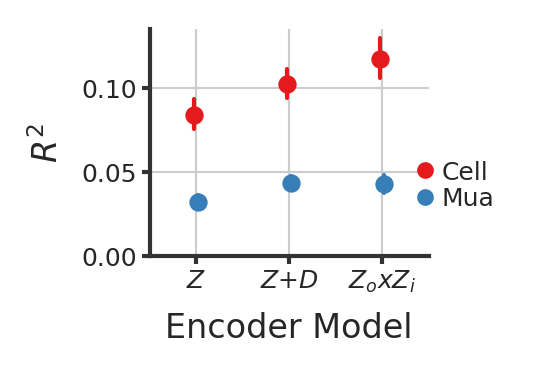

In [86]:
plot_score_by_unit(enc_res, exp='dir', x_val='test_cond', score='mean_test')

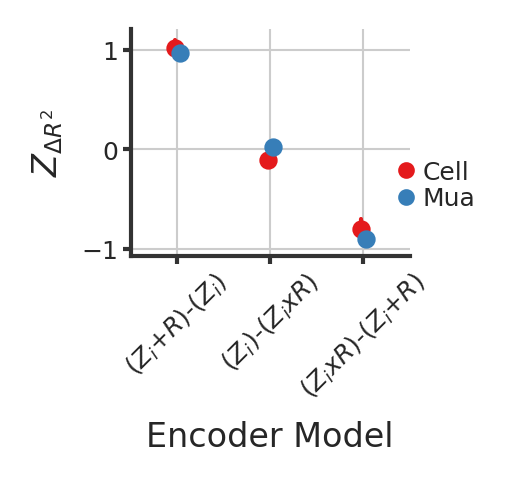

In [89]:
f,ax=plot_score_by_unit(enc_res, exp='rw', x_val='comp', score='uz')

# Encoder

In [18]:
%%time
ei = reload(ei)
info = ei.SummaryInfo()
enc_res = info.get_zone_encoder(overwrite=True)

KeyboardInterrupt: 

In [7]:
def select_rows(data, **conditions):
    bool_idx =  np.ones(len(data), dtype=bool)
    for col, val  in conditions.items():
        if isinstance(val, list):
            bool_idx = bool_idx & (data[col].isin(val))
        else:
            bool_idx = bool_idx & (data[col]==val)
    return data.loc[bool_idx].copy()

def get_encoder_data_comps(data, comp_name, unit_type='all'):
    
    if comp_name == 'lag':
        conditions = dict(cue_type = 'none',
                          rw_type='none',
                          sp_type='none',
                          trial_seg='out',
                          max_lag=[-50, 0, 50])
    elif comp_name == 'cue':
        conditions = dict(cue_type = ['none', 'fixed', 'inter'],
                          rw_type='none',
                          sp_type='none',
                          trial_seg='out',
                          max_lag=50,)
    elif comp_name == 'rw':
        conditions = dict(cue_type = 'none',
                          rw_type=['none', 'fixed', 'inter'],
                          sp_type='none',
                          trial_seg='in',
                          max_lag=50,)

        
        
    if unit_type!='all':
        conditions['unit_type']=unit_type
        
    return select_rows(data,**conditions)

In [8]:
def plot_score_by_unit(data, x_val, score='score', ax=None):

    palette = 'Set1'
    colors = sns.palettes.color_palette(palette,n_colors=2)

    if ax is None:
        f,ax=plt.subplots(figsize=(2,2), dpi=300)
        fontsize = 12
    else:
        f = ax.figure
        
    sns.pointplot(data=data, x=x_val, y=score, estimator=np.mean, 
                  hue='unit_type', hue_order=['cell','mua'], ax=ax,dodge=True, palette=palette, scale=0.5, errwidth=1)
    ax.set_ylabel(r'$R^2$', fontsize=fontsize)
    ax.set_xlabel('Encoder Model', fontsize=fontsize)

    if x_val=='max_lag':
        name_map = {-50:r'$F_{Z_{-50}}$', 
                    0:r'$F_{Z_{0}}$', 
                    50:r'$F_{Z_{50}}$'}
        
    elif x_val =='cue_type':
        name_map = {'none' : r'$F_{Z}$', 
                    'fixed': r'$F_{Z \plus C}$', 
                    'inter': r'$F_{Z x C}$'}

    elif x_val == 'rw_type':
        name_map = {'none' : r'$F_{Z_i}$', 
                    'fixed': r'$F_{Z_i \plus R}$', 
                    'inter': r'$F_{Z_i x R}$'}


    ax.set_xticklabels(name_map.values(), fontsize=fontsize)
    ax.get_legend().remove()

    leg_pos = [1.1, 0.1]
    legend_elements = [mpl.lines.Line2D([0], [0], marker='o', color=colors[0], lw=0, label='Cell',
                                        markerfacecolor=colors[0], markersize=3),
                       mpl.lines.Line2D([0], [0], marker='o', color=colors[1], lw=0, label='Mua',
                                        markerfacecolor=colors[1], markersize=3),]

    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                 fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)
    ylims = ax.get_ylim()
    ax.set_ylim([0, ylims[1]])
    
    return f,ax

def plot_score_by_subject(data, x_val, score='score', ax=None):
    subjects = info.subjects[:5]
    n_subjects = len(subjects)
    palette = 'deep'
    colors = sns.palettes.color_palette(palette,n_colors=n_subjects)

    if ax is None:
        f,ax=plt.subplots(figsize=(2,2), dpi=300)
    else:
        f = ax.figure

    sns.pointplot(data=data, x=x_val, y=score, estimator=np.mean, 
                  hue='subject', hue_order=subjects, ax=ax,dodge=0.3, palette=palette, scale=0.5, errwidth=1)
    
    ax.set_ylabel(f'$R^2$', fontsize=fontsize, labelpad=-1)
    ax.set_xlabel('Encoder Model', fontsize=fontsize)

    if x_val=='max_lag':
        name_map = {-50:r'$F_{Z_{-50}}$', 
                    0:r'$F_{Z_{0}}$', 
                    50:r'$F_{Z_{50}}$'}
    elif x_val =='cue_type':
        name_map = {'none' : r'$F_{Z}$', 
                    'fixed': r'$F_{Z \plus C}$', 
                    'inter': r'$F_{Z x C}$'}

    elif x_val == 'rw_type':
        name_map = {'none' : r'$F_{Z_i}$', 
                    'fixed': r'$F_{Z_i \plus R}$', 
                    'inter': r'$F_{Z_i x R}$'}


    ax.set_xticklabels(name_map.values(), fontsize=fontsize)
    ax.get_legend().remove()

    leg_pos = [1.1, 0.1]
    legend_elements=[]
    leg_name_map = [f"$s_{i+1}$" for i in range(n_subjects)]
    leg_name_map = dict(zip(subjects, leg_name_map))
    for ii, ss in enumerate(subjects):
        legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=colors[ii], lw=0, label=leg_name_map[ss],
                                            markerfacecolor=colors[ii], markersize=3))

    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                 fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)

    return f,ax

def plot_scores_vs(data, models, axs=None):

  
    if models=='max_lag':
        vals = [-50, 0, 50]
        name_map = {-50: r'$F_{Z_{-50}}$', 
                    0:   r'$F_{Z_{0}}$', 
                    50:  r'$F_{Z_{50}}$'}
        
        comps = [(0, -50),
                 (50, 0), 
                 (-50,50)]
    elif models =='cue_type':
        vals = ['none', 'fixed', 'inter']
        name_map = {'none' : r'$F_{Z}$', 
                    'fixed': r'$F_{Z \plus C}$', 
                    'inter': r'$F_{Z x C}$'}
        comps = [('none', 'fixed'),
                 ('inter', 'none'), 
                 ('fixed', 'none')]

    elif models == 'rw_type':
        vals = ['none', 'fixed', 'inter']
        name_map = {'none' : r'$F_{Z_i}$', 
                    'fixed': r'$F_{Z_i \plus R}$', 
                    'inter': r'$F_{Z_i x R}$'}
        comps = [('none', 'fixed'),
                 ('inter', 'none'), 
                 ('fixed', 'none')]


    df =data.pivot(index='unit_id', values='score', columns=models)

    subj_unit_xtab = pd.crosstab(data.unit_id, data.subject)>0
    subj_by_unit = subj_unit_xtab.idxmax(axis=1)

    df['subject'] = subj_by_unit[df.index]

    min_val = np.nanmin(df[vals].values)
    max_val = np.nanmax(df[vals].values)

    min_val = np.around(min_val*1.1,1)
    max_val = np.around(max_val*1.2,1)

    if axs is None:
        f,axs=plt.subplots(3,3, figsize=(3.5,3), dpi=300, constrained_layout=True)
        fontsize = 10
    else:
        f = axs[0].figure

    scatter_dot_size = 2
    scatter_dot_ec = '0.3'
    scatter_dot_lw = 0.2
    for ii in range(3):
        for jj in range(3):
            
            ax = axs[ii, jj]
            
            val1, val2 = comps[ii]
            name1 = name_map[val1]
            name2 = name_map[val2]
            df['delta'] = df[val2]-df[val1]


            # by subject
            if jj==0:
                sns.scatterplot(x=val1, y=val2, data=df,ax=ax, hue='subject', s=scatter_dot_size, hue_order=info.subjects, 
                                legend=False, palette='deep', alpha=0.75,
                                **{'linewidth': scatter_dot_lw, 'edgecolor': scatter_dot_ec})

                ax.set_ylim([min_val, max_val])
                ax.plot([min_val, max_val], [min_val, max_val], '--', color='0.2', lw=1)   
            # by unit and delta
            elif jj==1:
                sns.scatterplot(x=val1, y=val2, data=df,ax=ax, hue='delta', s=scatter_dot_size, legend=False, palette='vlag', alpha=0.75,
                                                          **{'linewidth': scatter_dot_lw, 'edgecolor': scatter_dot_ec})
                ax.set_ylim([min_val, max_val])
                ax.plot([min_val, max_val], [min_val, max_val], '--', color='0.2', lw=1)    
            # delta
            elif jj==2:
                #sns.histplot(x='delta', data=df,  ax=ax[ii,jj], color='#7095CD', bins=50, stat='percent', kde=True)
                sns.kdeplot(x='delta', data=df,  ax=ax, color='#4A5F82', bw_adjust=0.5)
                sns.rugplot(x='delta', data=df,  ax=ax, color='#4A5F82', expand_margins=False, lw=0.05, alpha=0.9, height=0.05)
                #sns.boxplot(x='delta', data=el_m2,  ax=ax[ii,jj])
                ax.set_yticks([])
                ax_w, ax_h = ax.get_ylim()
                ax.set_ylim([ax_w, ax_h*1.3])
                ax.axvline(df.delta.mean(), linestyle='--', color='#4A5F82', lw=1)
                ax.set_xlim([-0.15, 0.15])


            sns.despine(ax=ax)
            ax.tick_params(axis='both', labelsize=fontsize-2, pad=0, color='0.2',  length=2, width=1, which='major')
            
            if jj <2:
                ax.set_xlim([min_val, max_val])
                for sp in ['bottom', 'left']:
                    ax.spines[sp].set_linewidth(1)
                    ax.spines[sp].set_color('0.2')
            else:
                for sp in ['bottom']:
                    ax.spines[sp].set_linewidth(1)
                    ax.spines[sp].set_color('0.2')
                ax.spines['left'].set_visible(False)


            if (ii<2):
                ax.set_xticklabels([])
                ax.set_xlabel('')
            else:
                ax.tick_params(axis="x", direction="out", length=2, width=1, color='0.2', which='major',
                           pad=1, labelsize=fontsize-2, bottom=True, left=True)
            if (jj>0):
                ax.set_yticklabels([])
                ax.set_ylabel('')
            else:
                ax.tick_params(axis="y", direction="out", length=2, width=1, color='0.2', which='major',
                           pad=1, labelsize=fontsize-2, bottom=True, left=True)

            if ii==2:
                if jj==2:
                    ax.set_xlabel(name2 + '-' + name1 + f" $[\Delta_{{R^2}}]$", fontsize=fontsize, labelpad=0)
                else:
                    ax.set_xlabel(name1 +  f" $[R^2]$", fontsize=fontsize, labelpad=0)
            else:
                if (jj==2):
                    ax.set_xlabel(name2 + '-' + name1, fontsize=fontsize, labelpad=0)
                else:
                    ax.set_xlabel(name1, fontsize=fontsize, labelpad=0)

            if jj==0:
                ax.set_ylabel(name2 +  f" $[R^2]$", fontsize=fontsize, labelpad=0)

            ax.grid(linewidth=0.5)

    return f, axs

def plot_scores_vs_reg_boot2(data, models, score='score', reg_method='linear',axs=None):
    
    
    if models=='max_lag':
        vals = [-50, 0, 50]
        null_model=0
        test_model1 = 50
        test_model2 = -50
        name_map = {-50: r'$F_{Z_{-50}}$', 
                    0:   r'$F_{Z_{0}}$', 
                    50:  r'$F_{Z_{50}}$'}
    elif models =='cue_type':
        vals = ['none', 'fixed', 'inter']
        null_model= 'none'
        test_model1 = 'fixed'
        test_model2 = 'inter'
        name_map = {'none' : r'$F_{Z}$', 
                    'fixed': r'$F_{Z \plus C}$', 
                    'inter': r'$F_{Z x C}$'}
        comps = [('none', 'fixed'),
                 ('inter', 'none'), 
                 ('fixed', 'none')]

    elif models == 'rw_type':
        vals = ['none', 'fixed', 'inter']
        null_model= 'none'
        test_model1 = 'fixed'
        test_model2 = 'inter'
        name_map = {'none' : r'$F_{Z_i}$', 
                    'fixed': r'$F_{Z_i \plus R}$', 
                    'inter': r'$F_{Z_i x R}$'}
        comps = [('none', 'fixed'),
                 ('inter', 'none'), 
                 ('fixed', 'none')]
        
    if score == 'score':
        units =  f" $_{{[R^2]}}$"
    elif score == 'resid':
        units = ''
    
    df =data.pivot(index='unit_id', values=score, columns=models)
    df = df.dropna()
    
    null = df[null_model].values
    test1 = df[test_model1].values
    test2 = df[test_model2].values
    
    
    min_val = np.nanmin(df.values)
    max_val = np.nanmax(df.values)

    min_val = np.around(min_val*1.1,1)
    max_val = np.around(max_val*1.2,1)
    
    scatter_dot_size = 2
    scatter_dot_ec = '0.3'
    scatter_dot_lw = 0.2
    
    reg_color1 = '#e46c5c'
    reg_color2 = '#86b4cb'
    
    if axs is None:
        f,axs = plt.subplots(2,2, figsize=(3,2.5), dpi=300, constrained_layout=True)
        fontsize=10
    else:
        f = ax.figure    
    
    
    def _reg_plot(x,y,reg_color, ax):
        sns.scatterplot(x=x, y=y, ax=ax, s=scatter_dot_size,
                                    legend=False, palette='greys', alpha=0.75,
                                    **{'linewidth': scatter_dot_lw, 'edgecolor': scatter_dot_ec,'facecolor':'0.2'})
        ax.set_ylim([min_val, max_val])
        ax.plot([min_val, max_val], [min_val, max_val], '--', color='0.2', lw=1)    

        xx = np.linspace( x.min(),x.max(),100) 
        #     m,b = scipy.stats.siegelslopes(x,y)
        #     ax.plot(xx, m*xx + b, linewidth=1, color='#86b4cb', linestyle='-')

        y_top,y_bot,x_vals, boots = get_reg_ci(x=x ,y=y, eval_x=xx, reg_type=reg_method)
        #y_top,y_bot,x_vals, boots = get_reg_ci(x=x ,y=y, eval_x=xx)
        
        ax.fill_between(xx, y_bot, y_top, alpha=0.95, color=reg_color, linewidth=0.5, zorder=10)

        sns.despine(ax=ax)
        ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

        for sp in ['bottom', 'left']:
            ax.spines[sp].set_linewidth(1)
            ax.spines[sp].set_color('0.2')

        ax.grid(linewidth=0.5)
    
        return boots
    
    def _kde_plots(x1,x2,ax):
        sns.kdeplot(x=x1, ax=ax, color=reg_color1, bw_adjust=0.5)
        ax.axvline(x1.mean(), color=reg_color1, linestyle='--')
        sns.kdeplot(x=x2, ax=ax, color=reg_color2, bw_adjust=0.5)
        ax.axvline(x2.mean(), color=reg_color2, linestyle='--')
        sns.despine(ax=ax)
        
        ax.tick_params(axis='x', bottom=True,  labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')
        ax.tick_params(axis='y',left=False, right=False)

        for sp in ['bottom']:
            ax.spines[sp].set_linewidth(1)
            ax.spines[sp].set_color('0.2')

        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.grid(linewidth=0.5)

    
    boots1 = _reg_plot(null,test1,reg_color=reg_color1, ax=axs[0,0])
    boots2 = _reg_plot(null,test2,reg_color=reg_color2, ax=axs[1,0])

    _kde_plots(x1=boots1[:,0],x2=boots2[:,0],ax=axs[0,1] )
    _kde_plots(x1=boots1[:,1],x2=boots2[:,1],ax=axs[1,1] )
     
    axs[0,0].set_ylabel(name_map[test_model1] + units, fontsize=fontsize, labelpad=0)
    axs[1,0].set_ylabel(name_map[test_model2] + units, fontsize=fontsize, labelpad=0)
    axs[1,0].set_xlabel(name_map[null_model] + units, fontsize=fontsize, labelpad=0)

    axs[0,1].set_ylabel('Density', fontsize=fontsize-2, labelpad=0)
    axs[0,1].set_xlabel('Slope', fontsize=fontsize-2, labelpad=0)
    axs[0,1].axvline(1, color='k', linestyle='--')
    
    #axs[1,1].yaxis.set_label_position("right")
    #axs[1,1].set_ylabel('Density', fontsize=fontsize-2, labelpad=0, rotation=270)
    axs[1,1].set_ylabel('Density', fontsize=fontsize-2, labelpad=0)
    axs[1,1].set_xlabel('Intercept', fontsize=fontsize-1, labelpad=0)
    axs[1,1].axvline(0, color='k', linestyle='--')


    boot_out = pd.DataFrame(columns=[f"{test_model1}_m",f"{test_model1}_b",f"{test_model2}_m",f"{test_model2}_b"])
    boot_out[[f"{test_model1}_m",f"{test_model1}_b"]]=boots1
    boot_out[[f"{test_model2}_m",f"{test_model2}_b"]]=boots2
    
    return f, axs, boot_out

def get_reg_ci(x, y, reg_type='siegel', nboot=100,alpha=0.05, eval_x=None):
    n = len(x)
    assert n==len(y)
    
    boot_mb = np.zeros((nboot,2)) 
    
    if reg_type=='siegel':
        xp = y.copy()
        yp = x.copy()
        reg_func = scipy.stats.siegelslopes
    else:
        xp = x
        yp = y
        def reg_func(_x,_y):
            return np.polyfit(_x,_y,1)
        
    for boot in range(nboot):
        samps = np.random.choice(n,n)
        boot_mb[boot,:] = reg_func(xp[samps], yp[samps])
    
    
    if eval_x is None:
        xx = np.linspace(x.min(), x.max(), 100)
    else:
        xx = eval_x
    y_mb = boot_mb[:,1][:,np.newaxis]+np.outer(boot_mb[:,0],xx)
    y_bot, y_top = np.percentile(y_mb, np.array([alpha/2, 1-alpha/2])*100, axis=0)
        
    return y_bot, y_top, xx, boot_mb

def bootstrap_corr(x,y,n_boot=100,corr_method='kendall'):
    n = len(x)
    assert n==len(y)
    
    if corr_method=='kendall':
        r_func = rs.kendall
    else:
        r_func = rs.pearson
        
    r = np.zeros(n_boot)
    for b in range(n_boot):
        b_idx = np.random.choice(n,n)
        
        r[b]= r_func(x[b_idx], y[b_idx])
        
    return r

## Encoder Cue

In [10]:
comp = 'cue'
comp2 = 'cue_type'

res = get_encoder_data_comps(enc_res, comp_name=comp)
res.loc[res.score < -1, 'score']=np.nan
res = res.loc[~res.score.isna()]
res[comp2] = res[comp2].astype('category')

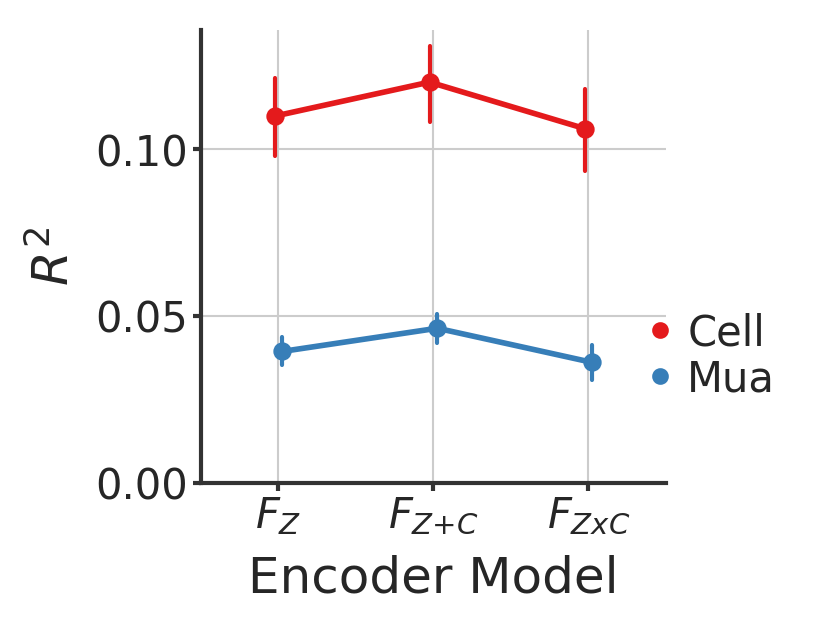

In [12]:
f,ax = plot_score_by_unit(data=res, x_val=comp2)

none     1581
fixed    1581
inter    1442
Name: cue_type, dtype: int64

In [1345]:
exp = 'cue'
x_val='test_cond'
unit_type='cell'

vc_formula={}
if exp=='rw':
    vc_formula['task'] = "0+C(task)"
else:
    vc_formula['task'] = "1+C(task)"
vc_formula['session'] = "0+C(session)"

data=set_data_to_plot(enc_res2, exp, unit_type)
data = data.reset_index(drop=True)
data = data.groupby(
    ["subject","session","task", x_val],
    observed=True).median().reset_index()

if x_val == 'test_cond':
    df = data
    df = df[~df['mean_test'].isna()]
    formula = "pct_correct ~ 1 + test_cond"
elif x_val == 'comp':
    df = data
    df = df[~df['uz'].isna()]
    formula = "pct_correct ~ 1 + comp"

if unit_type=='all':
    formula = formula + " + unit_type"

mdf = smf.mixedlm(formula=formula, groups='subject', re_formula="1", vc_formula=vc_formula, data=df).fit()
print(mdf.summary())
print(mdf.wald_test_terms())

print()
print("Interactions")
print('c0: none>fixed')
print('c1: inter>none')
print('c2: right>left')
print(mdf.t_test(r_mat))


            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  pct_correct
No. Observations:   235      Method:              REML       
No. Groups:         5        Scale:               0.0000     
Min. group size:    9        Log-Likelihood:      1965.0074  
Max. group size:    88       Converged:           Yes        
Mean group size:    47.0                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.710    0.015 48.458 0.000  0.681  0.738
test_cond[T.fixed]  0.000    0.000  0.000 1.000 -0.000  0.000
test_cond[T.inter] -0.000    0.000 -0.000 1.000 -0.000  0.000
subject Var         0.000  374.725                           
session Var         0.004  613.109                           
task Var            0.000  379.561                           

                   

## Encoder Lag

In [69]:
el = get_encoder_data_comps(enc_res, comp_name='lag')
el.loc[el.score < -1, 'score']=np.nan
el = el.loc[~el.score.isna()]
el['max_lag'] = el['max_lag'].astype('category')

### plot by unit type

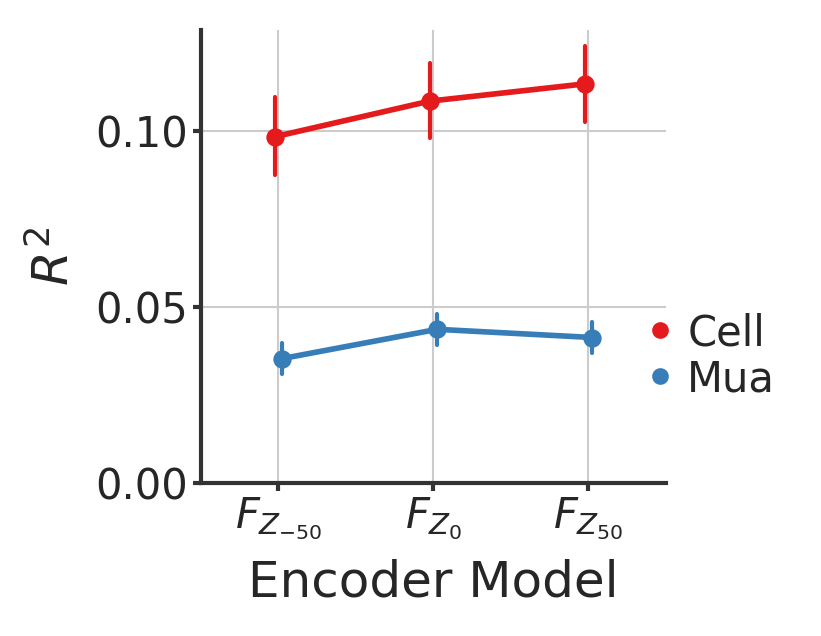

In [10]:
dpi=600
fn = 'encoder_lag_x_cell_type.png'

f,ax = plot_score_by_unit(data=el, x_val='max_lag')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

### plot by subject

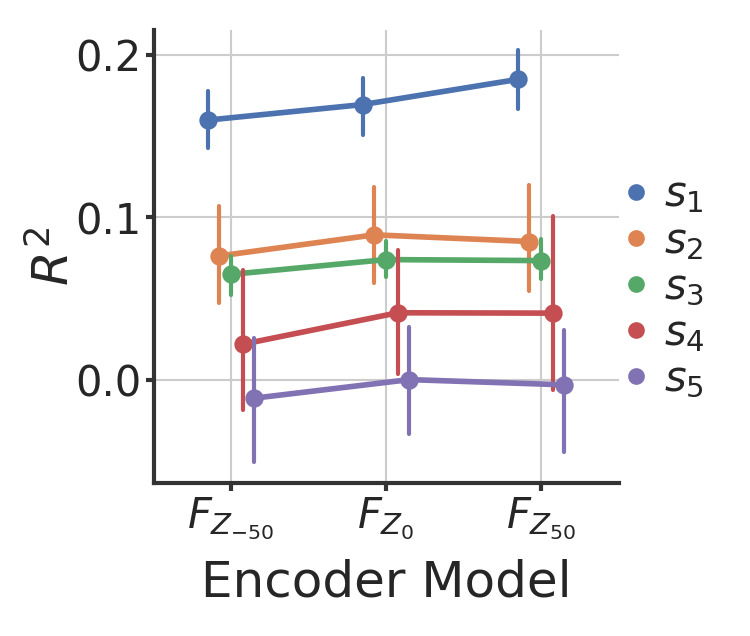

In [370]:
fn = 'encoder_lag_type_x_subject_cells.png'

f,ax = plot_score_by_subject(data=el[el.unit_type=='cell'], x_val='max_lag')

f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')


### plot pairs

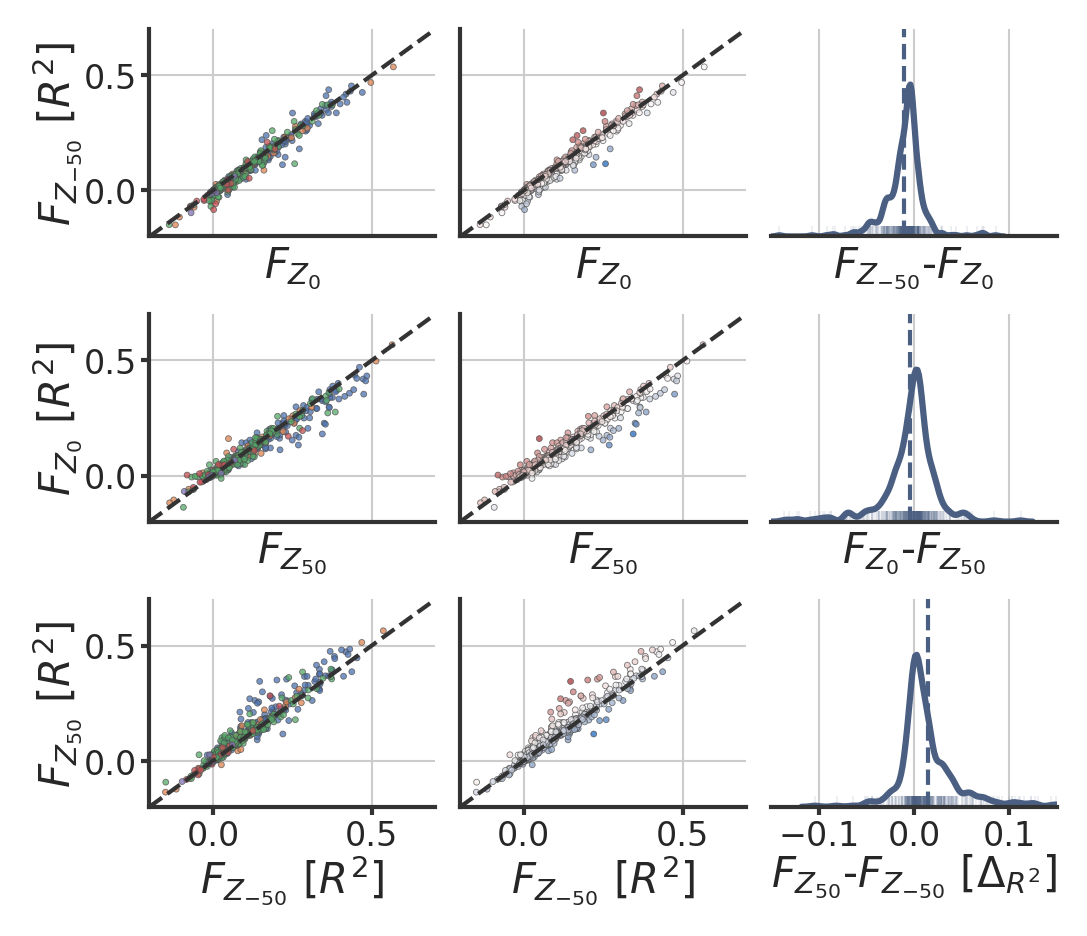

In [11]:
fn = 'encoder_lag_type_pairs_cells.png'
f,_=plot_scores_vs(data=el[el.unit_type=='cell'], models='max_lag')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')


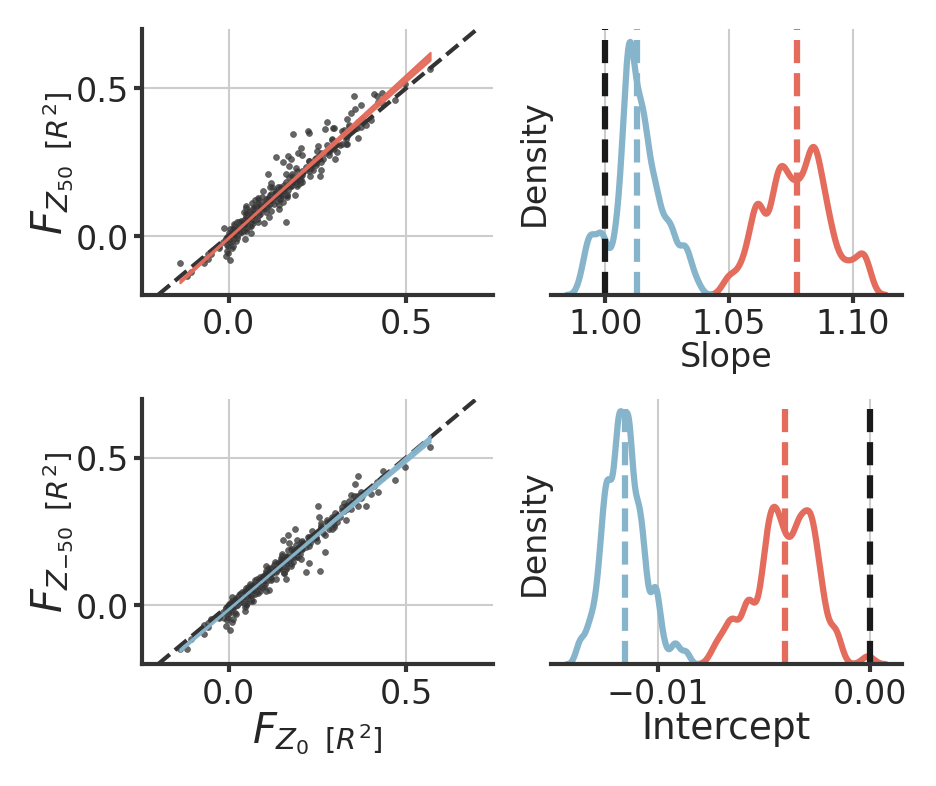

In [70]:
unit_type = 'cell'
fn = f'encoder_lag_type_pairs_reg_{unit_type}.png'
f,axs,_ = plot_scores_vs_reg_boot2(data=el[el.unit_type==unit_type], models='max_lag', reg_method='linear')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')


In [94]:
unit_type='cell'
x_model = 0
y_model = 50


models = 'max_lag'
score='score'
#df =el[el.unit_type==unit_type].pivot(index='unit_id', values=score, columns=models)
df =el.pivot(index='unit_id', values=score, columns=models)
df = df.dropna()
df[y_model]>df[50]


unit_id
0       False
1       False
2       False
3       False
4       False
        ...  
1580    False
1581    False
1582    False
1583    False
1584    False
Name: 50, Length: 1582, dtype: bool

([<matplotlib.patches.Wedge at 0x7f9ff064e850>,
 [Text(1.0364552070546986, 0.36845705824315844, '-50'),
  Text(-0.7260327824669546, 0.8263633575996047, '0'),
  Text(0.40729176442061066, -1.0218186818781236, '50')])

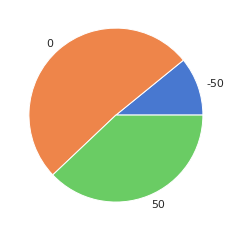

In [98]:
plt.pie(df.idxmax(axis=1).value_counts()[df.columns], labels=df.columns)

In [96]:
df.idxmax(axis=1).value_counts()

 0     810
 50    600
-50    172
dtype: int64

### Stats

In [21]:
vc_formula={}
vc_formula['task'] = "1+C(task)"
vc_formula['session'] = "0+C(session)"


df = el.pivot(index='unit_id', values='score', columns='max_lag')
df = df.dropna()
unit_info = el.groupby('unit_id').head(1)[['unit_type', 'subject', 'session', 'task', 'unit_id']]
unit_info = unit_info.set_index('unit_id', drop=True)
df = pd.concat( (df,unit_info.loc[df.index]), axis=1)
df = df.rename(columns={0:'null', 50:'test1', -50:'test2'})

mdf = smf.mixedlm(formula="test1 ~ 1 + null + unit_type", groups='subject', re_formula='1',vc_formula=vc_formula, data=df).fit()

print(mdf.summary())
#print(mdf.t_test(([0,1],[1]))) 

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  test1    
No. Observations:    1582     Method:              REML     
No. Groups:          5        Scale:               0.0003   
Min. group size:     40       Log-Likelihood:      4045.4260
Max. group size:     626      Converged:           Yes      
Mean group size:     316.4                                  
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept        -0.004    0.002  -1.797 0.072 -0.008  0.000
unit_type[T.mua] -0.002    0.001  -2.116 0.034 -0.004 -0.000
null              1.057    0.006 177.593 0.000  1.046  1.069
subject Var       0.000    0.001                            
session Var       0.000    0.000                            
task Var          0.000    0.001                            



In [16]:
vc_formula={}
vc_formula['task'] = "1+C(task)"
vc_formula['session'] = "0+C(session)"
mdf = smf.mixedlm(formula="score ~ 1 + unit_type", groups='subject', re_formula='1',vc_formula=vc_formula, data=el).fit()
el['resid'] = mdf.resid
mdf.summary()
#mdf.t_test([])

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:               MixedLM  Dependent Variable:  score    
No. Observations:    4752     Method:              REML     
No. Groups:          5        Scale:               0.0059   
Min. group size:     120      Log-Likelihood:      5308.8632
Max. group size:     1878     Converged:           Yes      
Mean group size:     950.4                                  
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         0.084    0.021   4.104 0.000  0.044  0.124
unit_type[T.mua] -0.063    0.003 -24.413 0.000 -0.068 -0.058
subject Var       0.002    0.049                            
session Var       0.001    0.003                            
task Var          0.000    0.022                            
============================================================

"""

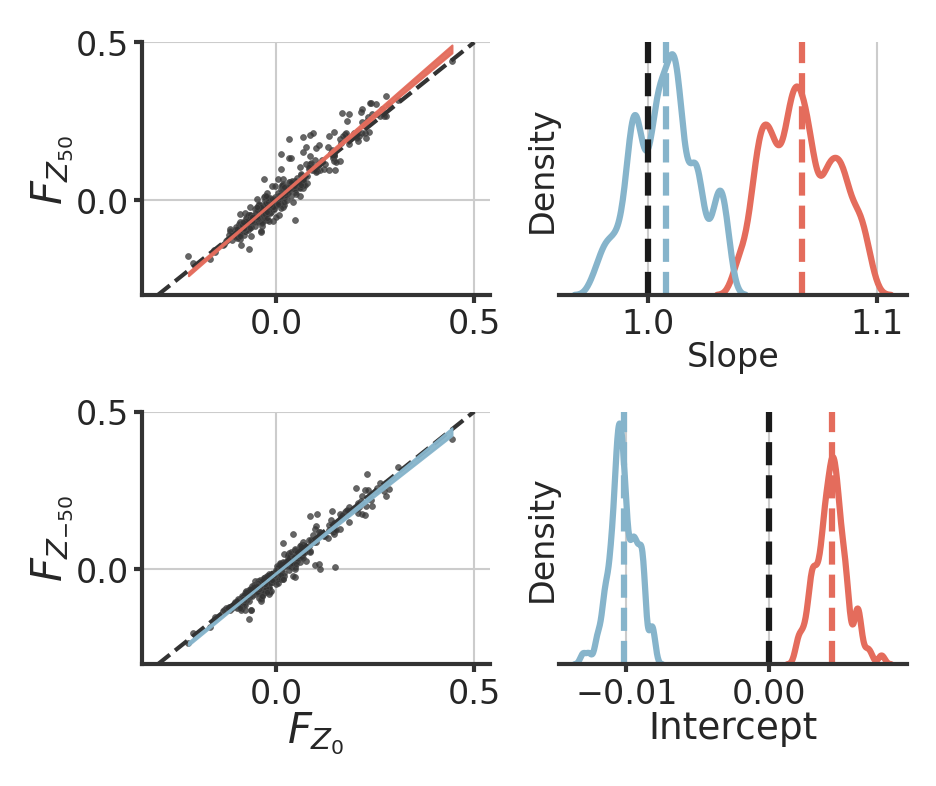

In [17]:
unit_type = 'cell'
fn = f'encoder_lag_type_pairs_reg_{unit_type}_residuals.png'
f,axs,_ = plot_scores_vs_reg_boot2(data=el[el.unit_type==unit_type], models='max_lag', score='resid')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')


In [18]:
df = el.pivot(index='unit_id', values='resid', columns='max_lag')
df = df.dropna()
unit_info = el.groupby('unit_id').head(1)[['unit_type', 'subject', 'session', 'task', 'unit_id']]
unit_info = unit_info.set_index('unit_id', drop=True)
df = pd.concat( (df,unit_info.loc[df.index]), axis=1)
df = df.rename(columns={0:'null', 50:'test1', -50:'test2'})
mdf = smf.ols(formula="test1 ~ 1 + null", data=df[df.unit_type=='cell']).fit()
print(mdf.summary())
print(mdf.t_test(([0,1],[1]))) 

                            OLS Regression Results                            
Dep. Variable:                  test1   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     5820.
Date:                Fri, 08 Apr 2022   Prob (F-statistic):          2.14e-261
Time:                        01:13:52   Log-Likelihood:                 981.91
No. Observations:                 457   AIC:                            -1960.
Df Residuals:                     455   BIC:                            -1952.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0044      0.001      3.313      0.0

In [359]:
mdf = smf.ols(formula="test2 ~ 1 + null", data=df[df.unit_type=='cell']).fit()
print(mdf.summary())
print(mdf.t_test(([0,1],[1]))) 

                            OLS Regression Results                            
Dep. Variable:                  test2   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     9440.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):          2.10e-306
Time:                        11:20:01   Log-Likelihood:                 1117.5
No. Observations:                 457   AIC:                            -2231.
Df Residuals:                     455   BIC:                            -2223.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0102      0.001    -10.337      0.0

# Outdated 

# Encoder Lag

## Encoder Cue

In [421]:
ec = get_encoder_data_comps(enc_res, comp_name='cue')
ec.loc[ec.score < -1, 'score']=np.nan
ec = ec.loc[~ec.score.isna()]

In [392]:
ec.head()

session_unit_id unit_type  max_lag cue_type rw_type sp_type trial_seg  \
7                 0       mua       50     none    none    none       out   
15                1       mua       50     none    none    none       out   
23                0      cell       50     none    none    none       out   
31                1      cell       50     none    none    none       out   
39                2      cell       50     none    none    none       out   

       score subject        session  session_pct_cov tt tt_cl  \
7   0.088078      Li  Li_T3g_052818              NaN  2    11   
15  0.023513      Li  Li_T3g_052818              NaN  2    14   
23  0.080161      Li  Li_T3g_052918              NaN  2    18   
31  0.396382      Li  Li_T3g_052918              NaN  8     0   
39  0.038811      Li  Li_T3g_052918              NaN  8    12   

                          cl_name task  unit_id  
7    Li_T3g_052818-tt2_d16.5_cl11  T3g        0  
15   Li_T3g_052818-tt2_d16.5_cl14  T3g        1  
23   Li_T3g_052918-tt2_d16.5_cl18  T3g        2  
31   Li_T3g_052918-tt8_d16.25_cl0  T3g        3  
39  Li_T3g_052918-tt8_d16.25_cl12  T3g        4

### by unit type

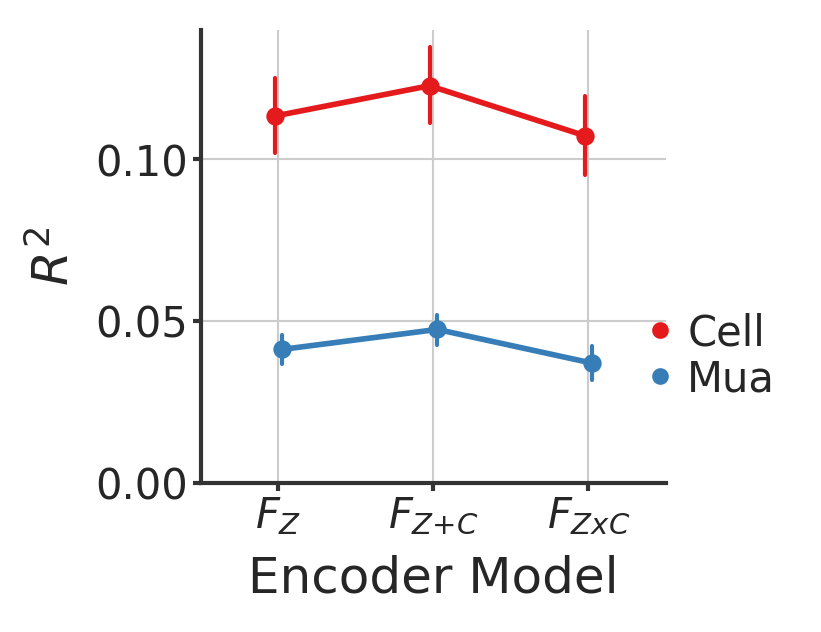

In [428]:
dpi=600
fn = 'cue_encoder_unit_type.png'
f,ax = plot_score_by_unit(data=ec, x_val='cue_type')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

### by subject

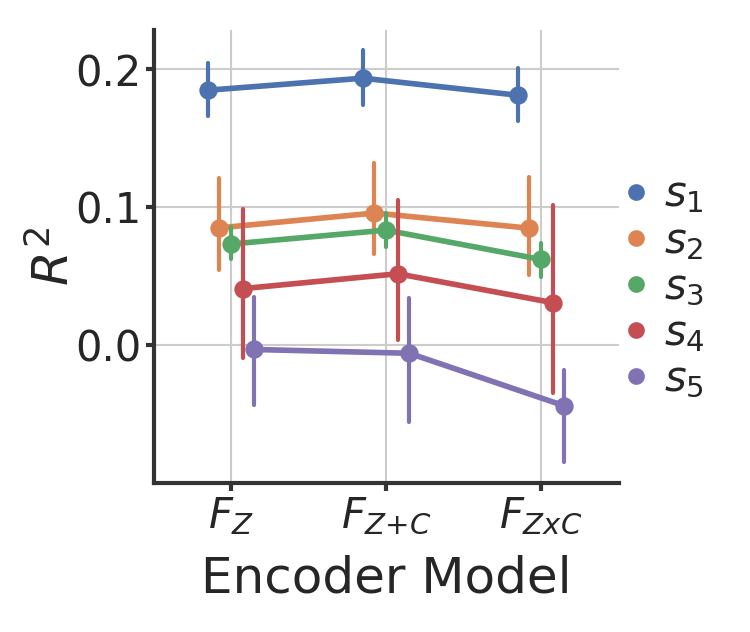

In [433]:
fn = 'cue_encodert_subject_cells.png'

f,ax = plot_score_by_subject(data=ec[ec.unit_type=='cell'], x_val='cue_type')

f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

### pairs

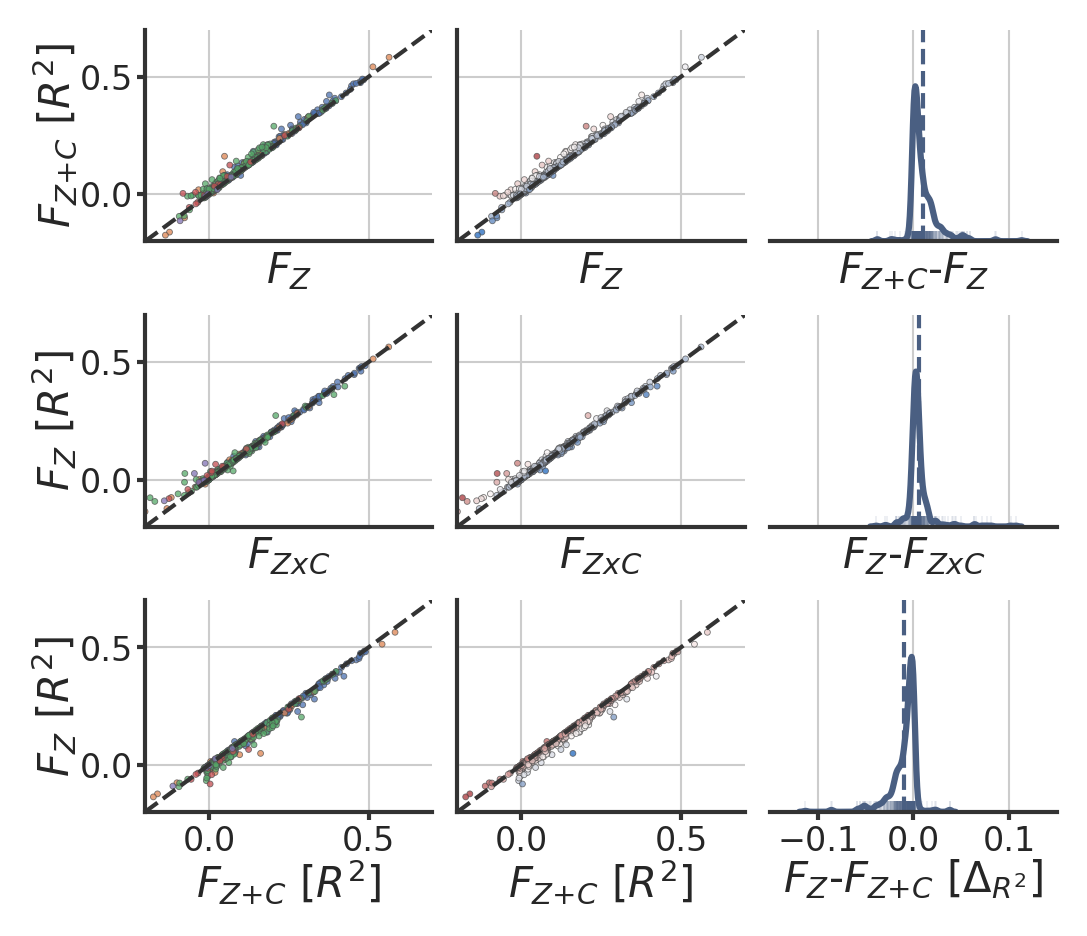

In [437]:
fn = 'cue_encoder_pairs_cells.png'
f,_=plot_scores_vs(data=ec[ec.unit_type=='cell'], models='cue_type')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

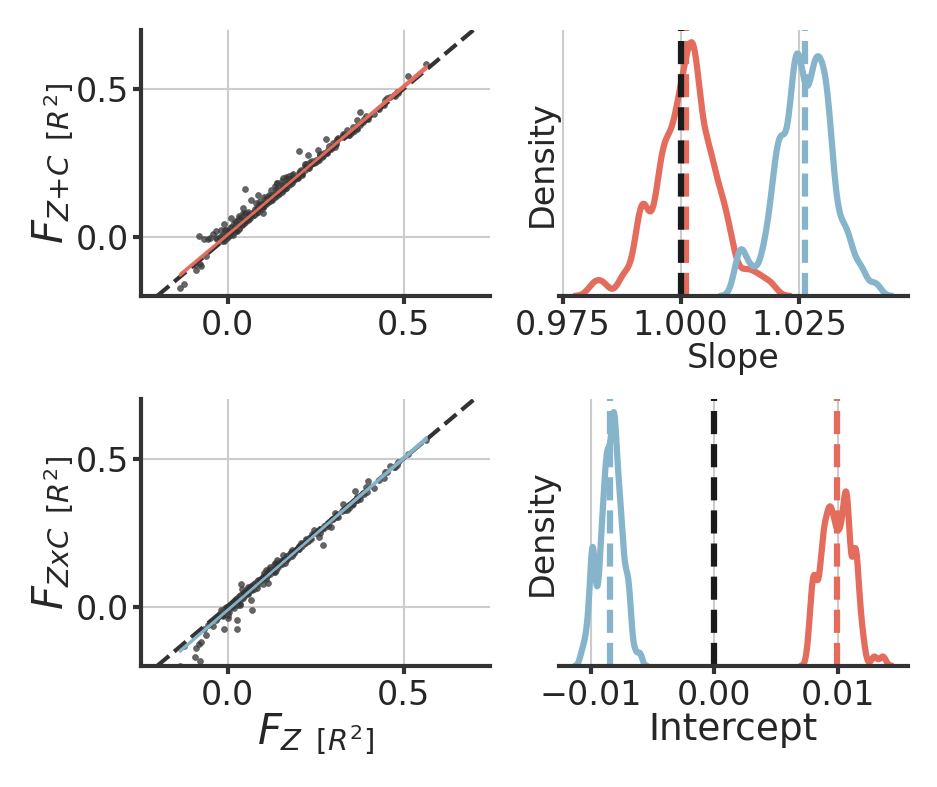

In [439]:
unit_type = 'cell'
fn = f'cue_encoder_pairs_cells_reg_{unit_type}.png'
f,axs,_ = plot_scores_vs_reg_boot2(data=ec[ec.unit_type==unit_type], models='cue_type', reg_method='linear')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

### Stats

In [456]:
vc_formula={}
vc_formula['task'] = "1+C(task)"
vc_formula['session'] = "1+C(session)"
mdf = smf.mixedlm(formula="score ~ 1 + unit_type", groups='subject', vc_formula=vc_formula, data=ec).fit()
ec['resid'] = mdf.resid
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:               MixedLM  Dependent Variable:  score    
No. Observations:    4612     Method:              REML     
No. Groups:          5        Scale:               0.0067   
Min. group size:     110      Log-Likelihood:      4799.2520
Max. group size:     1806     Converged:           Yes      
Mean group size:     922.4                                  
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         0.052    0.043   1.189 0.234 -0.033  0.137
unit_type[T.mua] -0.068    0.003 -24.203 0.000 -0.073 -0.062
session Var       0.005    0.011                            
task Var          0.004    0.040                            
============================================================

"""

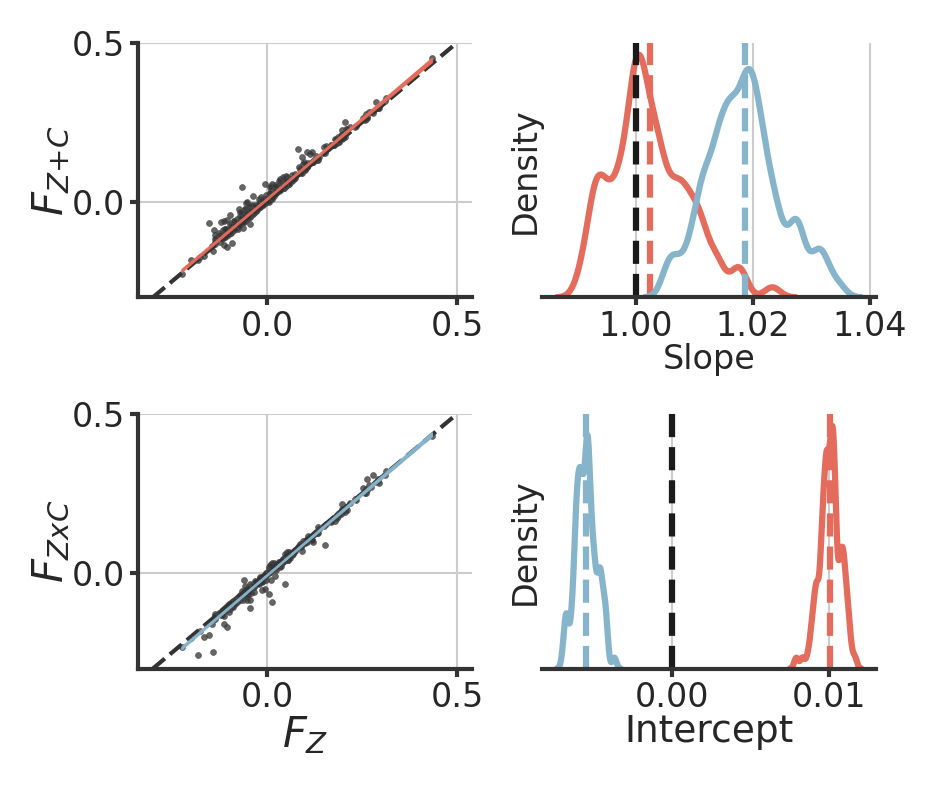

In [465]:
np.random.seed(0)
unit_type = 'cell'
fn = f'cue_encoder_pairs_cells_reg_{unit_type}_residuals.png'
f,axs,_ = plot_scores_vs_reg_boot2(data=ec[ec.unit_type==unit_type], models='cue_type', score='resid')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

In [458]:
df = ec.pivot(index='unit_id', values='resid', columns='cue_type')
df = df.dropna()
unit_info = ec.groupby('unit_id').head(1)[['unit_type', 'subject', 'session', 'task', 'unit_id']]
unit_info = unit_info.set_index('unit_id', drop=True)
df = pd.concat( (df,unit_info.loc[df.index]), axis=1)
df = df.rename(columns={'none':'null', 'fixed':'test1', 'inter':'test2'})
mdf = smf.ols(formula="test1 ~ 1 + null", data=df[df.unit_type=='cell']).fit()
print(mdf.summary())
print(mdf.t_test(([0,1],[1]))) 

                            OLS Regression Results                            
Dep. Variable:                  test1   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 2.105e+04
Date:                Tue, 05 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:12:08   Log-Likelihood:                 1184.8
No. Observations:                 423   AIC:                            -2366.
Df Residuals:                     421   BIC:                            -2357.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0100      0.001     13.965      0.0

In [459]:
mdf = smf.ols(formula="test2 ~ 1 + null", data=df[df.unit_type=='cell']).fit()
print(mdf.summary())
print(mdf.t_test(([0,1],[1]))) 

                            OLS Regression Results                            
Dep. Variable:                  test2   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 2.642e+04
Date:                Tue, 05 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:12:11   Log-Likelihood:                 1226.2
No. Observations:                 423   AIC:                            -2448.
Df Residuals:                     421   BIC:                            -2440.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0054      0.001     -8.306      0.0

# Encoder Rw

In [446]:
er = get_encoder_data_comps(enc_res, comp_name='rw')
er.loc[er.score < -1, 'score']=np.nan
er = er.loc[~er.score.isna()]

In [447]:
er.head()

session_unit_id unit_type  max_lag cue_type rw_type sp_type trial_seg  \
4                 0       mua       50     none   fixed    none        in   
5                 0       mua       50     none   inter    none        in   
6                 0       mua       50     none    none    none        in   
12                1       mua       50     none   fixed    none        in   
13                1       mua       50     none   inter    none        in   

       score subject        session  session_pct_cov tt tt_cl  \
4  -0.017174      Li  Li_T3g_052818              NaN  2    11   
5  -0.003725      Li  Li_T3g_052818              NaN  2    11   
6  -0.029346      Li  Li_T3g_052818              NaN  2    11   
12 -0.016461      Li  Li_T3g_052818              NaN  2    14   
13 -0.022949      Li  Li_T3g_052818              NaN  2    14   

                         cl_name task  unit_id  
4   Li_T3g_052818-tt2_d16.5_cl11  T3g        0  
5   Li_T3g_052818-tt2_d16.5_cl11  T3g        0  
6   Li_T3g_052818-tt2_d16.5_cl11  T3g        0  
12  Li_T3g_052818-tt2_d16.5_cl14  T3g        1  
13  Li_T3g_052818-tt2_d16.5_cl14  T3g        1

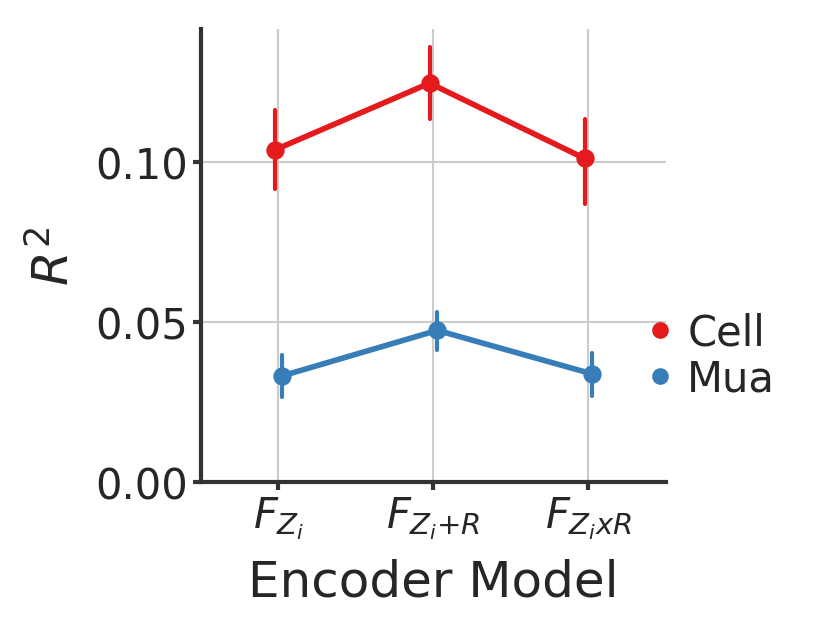

In [477]:
dpi=600
fn = 'rw_encoder_unit_type.png'
f,ax = plot_score_by_unit(data=er, x_val='rw_type')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

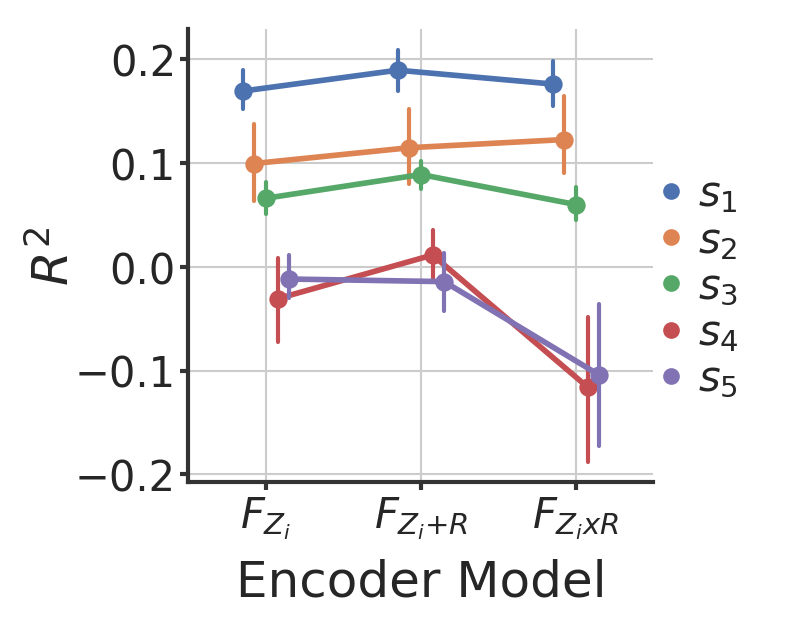

In [450]:
fn = 'rw_encoder_subject_cells.png'
f,ax = plot_score_by_subject(data=er[er.unit_type=='cell'], x_val='rw_type')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

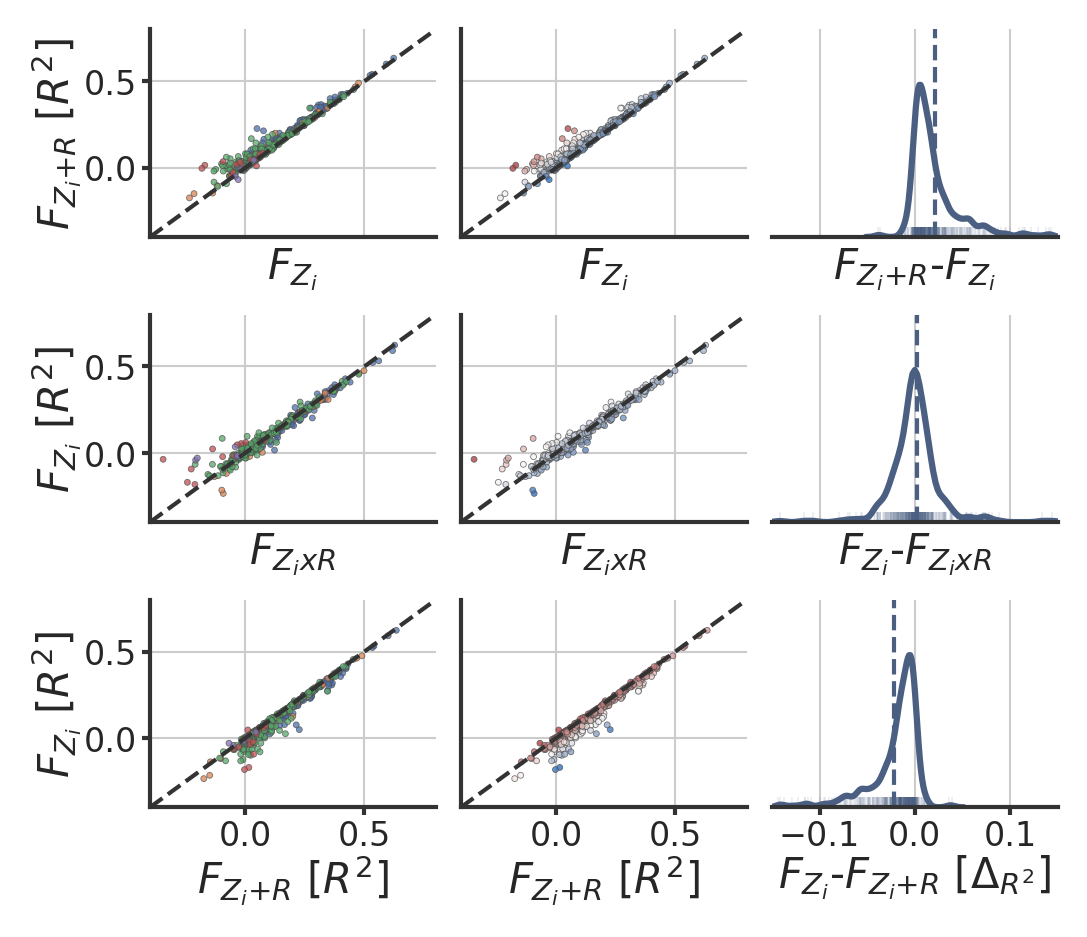

In [451]:
fn = 'rw_encoder_pairs_cells.png'
f,_=plot_scores_vs(data=er[er.unit_type=='cell'], models='rw_type')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

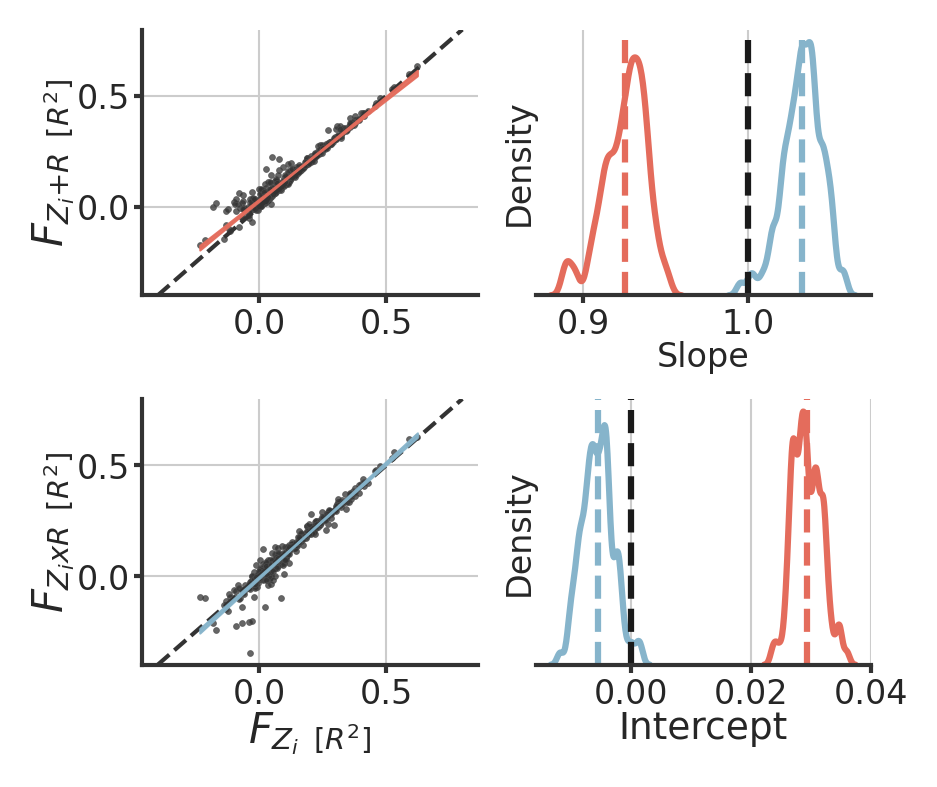

In [466]:
np.random.seed(0)
unit_type = 'cell'
fn = f'rw_encoder_pairs_cells_reg_{unit_type}.png'
f,axs,_ = plot_scores_vs_reg_boot2(data=er[er.unit_type==unit_type], models='rw_type', reg_method='linear')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

In [468]:
vc_formula={}
vc_formula['task'] = "1+C(task)"
vc_formula['session'] = "1+C(session)"
mdf = smf.mixedlm(formula="score ~ 1 + unit_type", groups='subject', vc_formula=vc_formula, data=er).fit()
er['resid'] = mdf.resid
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:               MixedLM  Dependent Variable:  score    
No. Observations:    4664     Method:              REML     
No. Groups:          5        Scale:               0.0091   
Min. group size:     113      Log-Likelihood:      4125.5216
Max. group size:     1878     Converged:           Yes      
Mean group size:     932.8                                  
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         0.019    0.070   0.269 0.788 -0.118  0.156
unit_type[T.mua] -0.069    0.003 -21.519 0.000 -0.076 -0.063
session Var       0.012    0.022                            
task Var          0.012    0.086                            
============================================================

"""

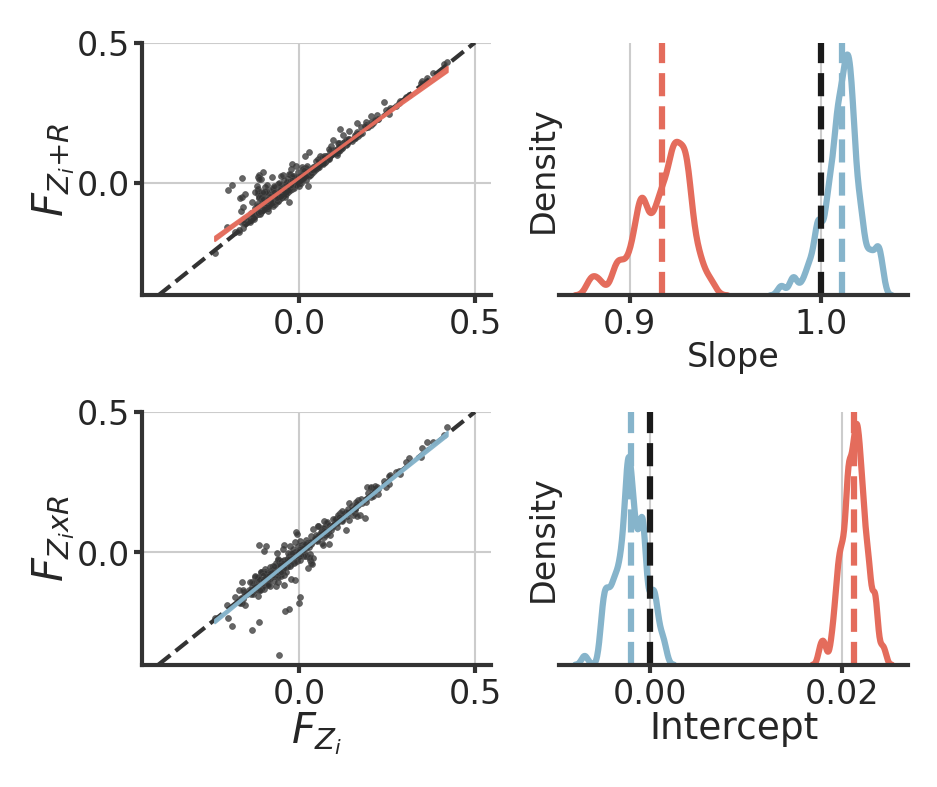

In [470]:
np.random.seed(0)

unit_type = 'cell'
fn = f'rw_encoder_pairs_cells_reg_{unit_type}_residuals.png'
f,axs,_ = plot_scores_vs_reg_boot2(data=er[er.unit_type==unit_type], models='rw_type', score='resid')
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

In [475]:
df = er.pivot(index='unit_id', values='resid', columns='rw_type')
df = df.dropna()
unit_info = er.groupby('unit_id').head(1)[['unit_type', 'subject', 'session', 'task', 'unit_id']]
unit_info = unit_info.set_index('unit_id', drop=True)
df = pd.concat( (df,unit_info.loc[df.index]), axis=1)
df = df.rename(columns={'none':'null', 'fixed':'test1', 'inter':'test2'})
mdf = smf.ols(formula="test1 ~ 1 + null", data=df[df.unit_type=='cell']).fit()
print(mdf.summary())
print(mdf.t_test(([0,1],[1]))) 

                            OLS Regression Results                            
Dep. Variable:                  test1   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     5808.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):          9.86e-251
Time:                        17:23:42   Log-Likelihood:                 927.17
No. Observations:                 429   AIC:                            -1850.
Df Residuals:                     427   BIC:                            -1842.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0212      0.001     15.709      0.0

In [476]:
mdf = smf.ols(formula="test2 ~ 1 + null", data=df[df.unit_type=='cell']).fit()
print(mdf.summary())
print(mdf.t_test(([0,1],[1]))) 

                            OLS Regression Results                            
Dep. Variable:                  test2   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     4789.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):          3.48e-234
Time:                        17:23:49   Log-Likelihood:                 844.07
No. Observations:                 429   AIC:                            -1684.
Df Residuals:                     427   BIC:                            -1676.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0022      0.002     -1.313      0.1

# OLD

In [6]:
el.head()

session_unit_id  split  fold metric     score  lag    decay cue_type  \
0                0  train     0     r2  0.122859  -50  inverse     none   
1                1  train     0     r2  0.041036  -50  inverse     none   
2                0   test     0     r2  0.064921  -50  inverse     none   
3                1   test     0     r2  0.021985  -50  inverse     none   
4                0  train     1     r2  0.088676  -50  inverse     none   

  unit_type subject        session  session_pct_cov tt tt_cl  \
0       mua      Li  Li_T3g_052818              NaN  2    11   
1       mua      Li  Li_T3g_052818              NaN  2    14   
2       mua      Li  Li_T3g_052818              NaN  2    11   
3       mua      Li  Li_T3g_052818              NaN  2    14   
4       mua      Li  Li_T3g_052818              NaN  2    11   

                        cl_name task  unit_id  
0  Li_T3g_052818-tt2_d16.5_cl11  T3g        0  
1  Li_T3g_052818-tt2_d16.5_cl14  T3g        1  
2  Li_T3g_052818-tt2_d16.5_cl11  T3g        0  
3  Li_T3g_052818-tt2_d16.5_cl14  T3g        1  
4  Li_T3g_052818-tt2_d16.5_cl11  T3g        0

In [33]:
el.shape

(58800, 17)

In [636]:
el_m = el.groupby(['subject','session', 'task', 'unit_id','cl_name', 'decay', 'unit_type','lag', 'split'])[['score']].mean().reset_index()
el_m.loc[el_m.score < -1, 'score']=np.nan
el_m['lag'] = el_m['lag'].astype('category')
el_m = el_m.dropna()

### plot by unit type

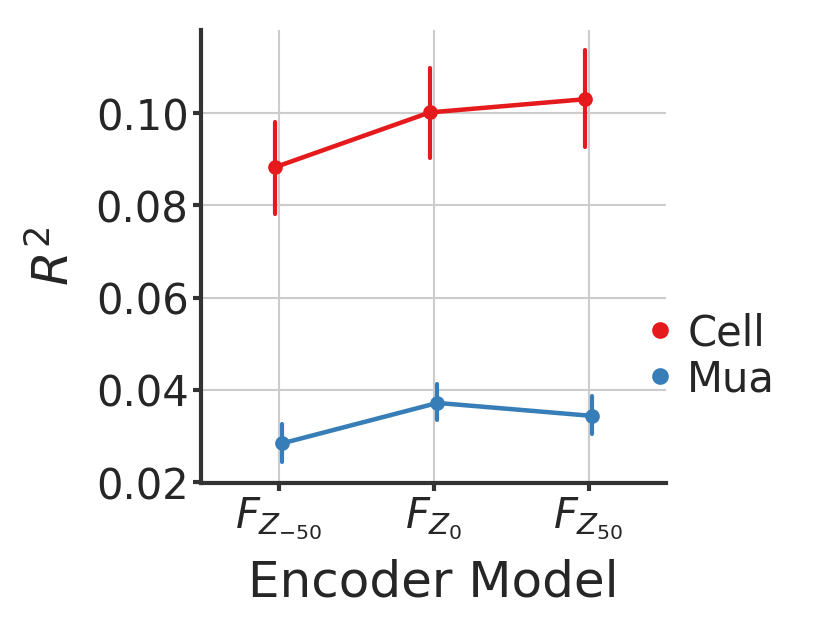

In [637]:
# f,ax=plt.subplots(dpi=100)
# sns.pointplot(data=el_m[el_m.split=='test'], x='lag', y='score', hue='unit_type', ax=ax)

f,ax=plt.subplots(figsize=(2,2), dpi=300)

dpi=600
fn = 'encoder_lag_x_cell_type.png'
fontsize = 12
palette = 'Set1'
colors = sns.palettes.color_palette(palette,n_colors=2)

sns.pointplot(data=el_m[(el_m.split=='test')], x='lag', y='score', estimator=np.mean, 
              hue='unit_type', hue_order=['cell','mua'], ax=ax,dodge=True, palette=palette, scale=0.5, errwidth=1)
ax.set_ylabel(r'$R^2$', fontsize=fontsize)
ax.set_xlabel('Encoder Model', fontsize=fontsize)

name_map = {-50:r'$F_{Z_{-50}}$', 
            0:r'$F_{Z_{0}}$', 
            50:r'$F_{Z_{50}}$'}

ax.set_xticklabels(name_map.values(), fontsize=fontsize)
ax.get_legend().remove()

leg_pos = [1.1, 0.1]
legend_elements = [mpl.lines.Line2D([0], [0], marker='o', color=colors[0], lw=0, label='Cell',
                                    markerfacecolor=colors[0], markersize=3),
                   mpl.lines.Line2D([0], [0], marker='o', color=colors[1], lw=0, label='Mua',
                                    markerfacecolor=colors[1], markersize=3),]

ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
             fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

sns.despine(ax=ax)
ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

for sp in ['bottom', 'left']:
    ax.spines[sp].set_linewidth(1)
    ax.spines[sp].set_color('0.2')

ax.grid(linewidth=0.5)

f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')


### plot by subject

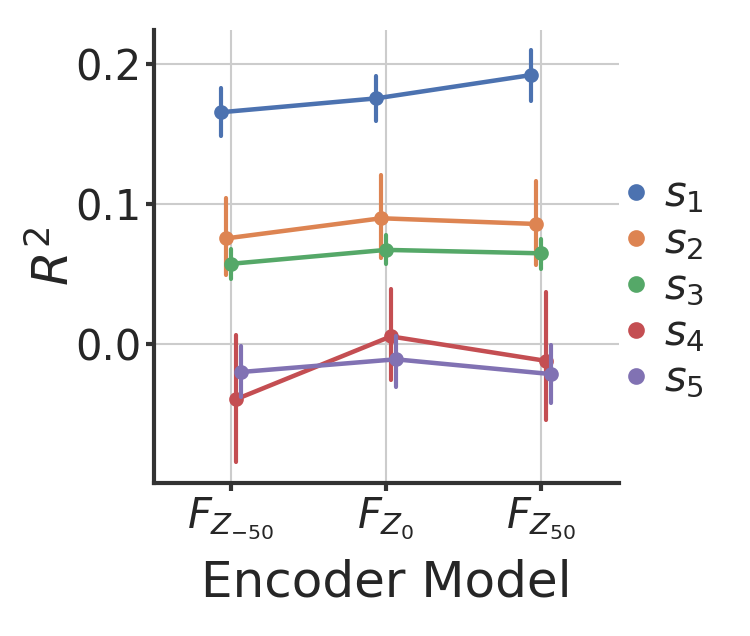

In [639]:
subjects = info.subjects[:5]
n_subjects = len(subjects)
palette = 'deep'

dpi=600
fn = 'encoder_lag_type_x_subject.png'
colors = sns.palettes.color_palette(palette,n_colors=n_subjects)

f,ax=plt.subplots(figsize=(2,2), dpi=300)

sns.pointplot(data=el_m[(el_m.split=='test')  & (el_m.unit_type=='cell')], x='lag', y='score', estimator=np.mean, 
              hue='subject', hue_order=subjects, ax=ax,dodge=True, palette=palette, scale=0.5, errwidth=1)
ax.set_ylabel(f'$R^2$', fontsize=fontsize, labelpad=-1)
ax.set_xlabel('Encoder Model', fontsize=fontsize)
name_map = {-50:r'$F_{Z_{-50}}$', 
            0:r'$F_{Z_{0}}$', 
            50:r'$F_{Z_{50}}$'}

ax.set_xticklabels(name_map.values(), fontsize=fontsize)
ax.get_legend().remove()

leg_pos = [1.1, 0.1]
legend_elements=[]
leg_name_map = [f"$s_{i+1}$" for i in range(n_hues)]
leg_name_map = dict(zip(subjects, leg_name_map))
for ii, ss in enumerate(subjects):
    legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=colors[ii], lw=0, label=leg_name_map[ss],
                                        markerfacecolor=colors[ii], markersize=3))

ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
             fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

sns.despine(ax=ax)
ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

for sp in ['bottom', 'left']:
    ax.spines[sp].set_linewidth(1)
    ax.spines[sp].set_color('0.2')

ax.grid(linewidth=0.5)

f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')



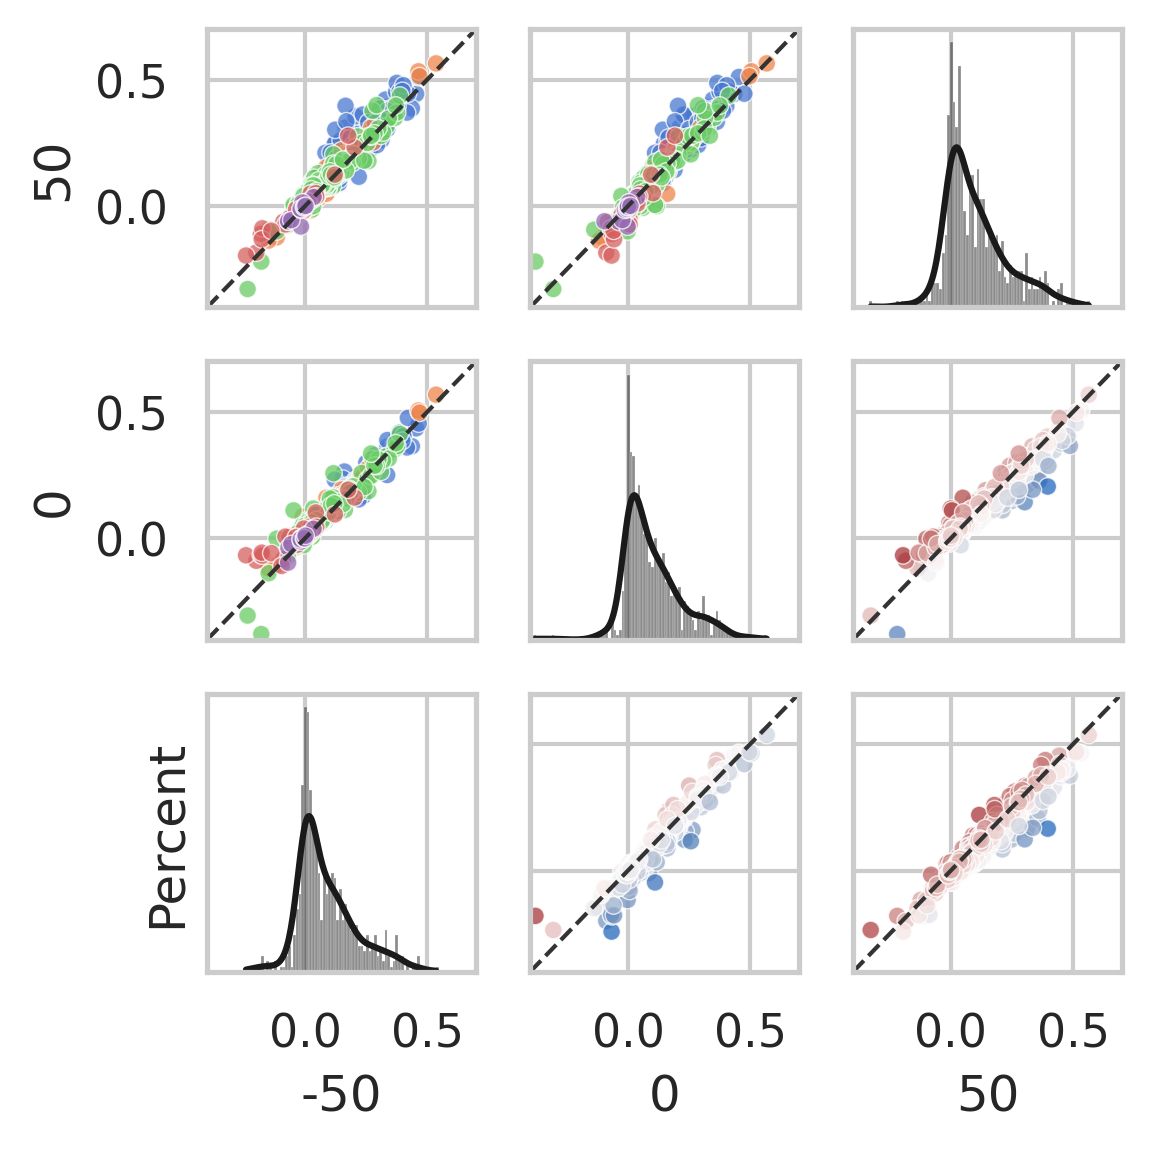

In [242]:
unit_type = 'cell'
split = 'test'

el_m2 = el.loc[(el.split==split) & (el.unit_type==unit_type)].groupby(['subject','session', 'task', 'unit_id', 'lag'])[['score']].mean().reset_index()
el_m2.loc[el_m2.score < -1, 'score']=np.nan
el_m2['lag'] = el_m2['lag'].astype('category')
el_m2 = el_m2.pivot(index='unit_id', values='score', columns='lag')

subj_unit_xtab = pd.crosstab(el_m.unit_id, el_m.subject)>0
subj_by_unit = subj_unit_xtab.idxmax(axis=1)

el_m2['subject'] = subj_by_unit[el_m2.index]

min_val = np.nanmin(el_m2[lags].values)
max_val = np.nanmax(el_m2[lags].values)

min_val = np.around(min_val*1.1,1)
max_val = np.around(max_val*1.2,1)

f,ax=plt.subplots(3,3, figsize=(4,4), dpi=300, tight_layout=True)

lags=[-50, 0, 50]
for ii, lag1 in enumerate(lags[::-1]):
    
    for jj, lag2 in enumerate(lags):
        
        el_m2['delta'] = el_m2[lag1]-el_m2[lag2]
        if lag1==lag2:
            sns.histplot(x=lag1, data=el_m2,  ax=ax[ii,jj], color='0.1', binrange=[min_val, max_val], bins=100, stat='percent', kde=True)
            ax[ii,jj].set_yticks([])
        else:
            if ( (ii==jj==0) | ((ii==1) & (jj==0)) | ((ii==0) & (jj==1))  ):
                sns.scatterplot(x=lag2, y=lag1, data=el_m2,ax=ax[ii,jj], hue='subject', size=0.1, legend=False, alpha=0.75)
            else:
                sns.scatterplot(x=lag2, y=lag1, data=el_m2,ax=ax[ii,jj], hue='delta', size=0.1, legend=False, palette='vlag', alpha=0.75)
            
            ax[ii,jj].set_ylim([min_val, max_val])
            ax[ii,jj].plot([min_val, max_val], [min_val, max_val], '--', color='0.2', lw=1)    
                
        ax[ii,jj].set_xlim([min_val, max_val])
    
        if (ii<2):
            ax[ii,jj].set_xticklabels([])
            ax[ii,jj].set_xlabel('')
        if (jj>0):
            ax[ii,jj].set_yticklabels([])
            ax[ii,jj].set_ylabel('')
            
        #ax[ii,jj].scatter(x,y, s=5)
        #print(ii,jj)
        


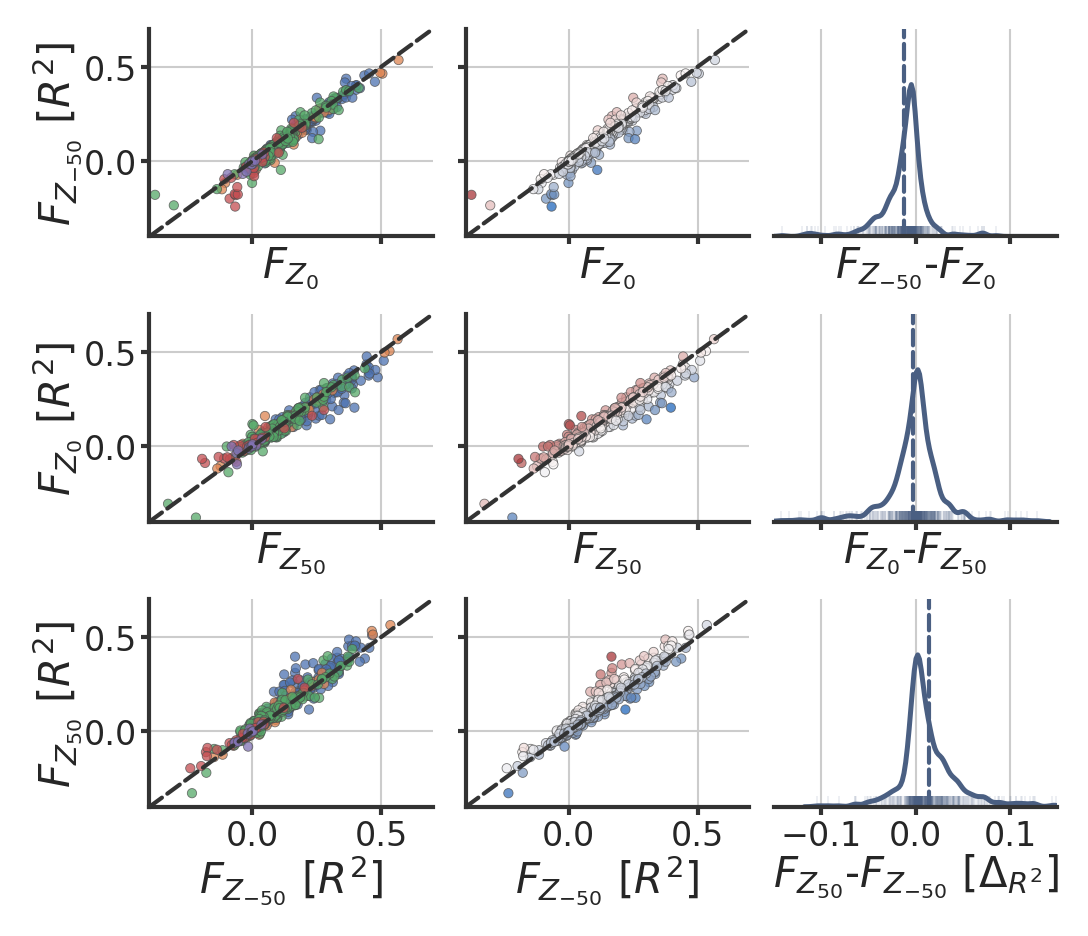

In [643]:
dpi=600
fn = 'encoder_lag_pairs.png'
fontsize = 10

unit_type = 'cell'
split = 'test'
lags = [-50, 0, 50]
name_map = {-50:r'$F_{Z_{-50}}$', 
            0:r'$F_{Z_{0}}$', 
            50:r'$F_{Z_{50}}$'}

df =el_m[(el_m.split==split) & (el_m.unit_type==unit_type)].pivot(index='unit_id', values='score', columns='lag')

subj_unit_xtab = pd.crosstab(el.unit_id, el.subject)>0
subj_by_unit = subj_unit_xtab.idxmax(axis=1)

df['subject'] = subj_by_unit[df.index]

min_val = np.nanmin(df[lags].values)
max_val = np.nanmax(df[lags].values)

min_val = np.around(min_val*1.1,1)
max_val = np.around(max_val*1.2,1)

f,ax=plt.subplots(3,3, figsize=(3.5,3), dpi=300, constrained_layout=True)

comps = [(0, -50),
         (50, 0), 
         (-50,50)]

scatter_dot_size = 5
scatter_dot_ec = '0.3'
scatter_dot_lw = 0.2
for ii in range(3):
    for jj in range(3):
        lag1, lag2 = comps[ii]
        
        name1 = name_map[lag1]
        name2 = name_map[lag2]
        df['delta'] = df[lag2]-df[lag1]
        
        
        # by subject
        if jj==0:
            sns.scatterplot(x=lag1, y=lag2, data=df,ax=ax[ii,jj], hue='subject', s=scatter_dot_size, hue_order=info.subjects, legend=False, palette='deep', alpha=0.75,
                                                      **{'linewidth': scatter_dot_lw, 'edgecolor': scatter_dot_ec})

            ax[ii,jj].set_ylim([min_val, max_val])
            ax[ii,jj].plot([min_val, max_val], [min_val, max_val], '--', color='0.2', lw=1)   
        # by unit and delta
        elif jj==1:
            sns.scatterplot(x=lag1, y=lag2, data=df,ax=ax[ii,jj], hue='delta', s=scatter_dot_size, legend=False, palette='vlag', alpha=0.75,
                                                      **{'linewidth': scatter_dot_lw, 'edgecolor': scatter_dot_ec})
            ax[ii,jj].set_ylim([min_val, max_val])
            ax[ii,jj].plot([min_val, max_val], [min_val, max_val], '--', color='0.2', lw=1)    
        # delta
        elif jj==2:
            #sns.histplot(x='delta', data=df,  ax=ax[ii,jj], color='#7095CD', bins=50, stat='percent', kde=True)
            sns.kdeplot(x='delta', data=df,  ax=ax[ii,jj], color='#4A5F82', bw_adjust=0.5)
            sns.rugplot(x='delta', data=df,  ax=ax[ii,jj], color='#4A5F82', expand_margins=False, lw=0.05, alpha=0.9, height=0.05)
            #sns.boxplot(x='delta', data=el_m2,  ax=ax[ii,jj])
            ax[ii,jj].set_yticks([])
            ax_w, ax_h = ax[ii,jj].get_ylim()
            ax[ii,jj].set_ylim([ax_w, ax_h*1.3])
            ax[ii,jj].axvline(df.delta.mean(), linestyle='--', color='#4A5F82', lw=1)
            ax[ii,jj].set_xlim([-0.15, 0.15])

            
        sns.despine(ax=ax[ii,jj])
        ax[ii,jj].tick_params(axis='both', labelsize=fontsize-2, pad=0, color='0.2',  length=2, width=1, which='major')
        if jj <2:
            ax[ii,jj].set_xlim([min_val, max_val])
            for sp in ['bottom', 'left']:
                ax[ii,jj].spines[sp].set_linewidth(1)
                ax[ii,jj].spines[sp].set_color('0.2')
        else:
            for sp in ['bottom']:
                ax[ii,jj].spines[sp].set_linewidth(1)
                ax[ii,jj].spines[sp].set_color('0.2')
            ax[ii,jj].spines['left'].set_visible(False)
            
           
        if (ii<2):
            ax[ii,jj].set_xticklabels([])
            ax[ii,jj].set_xlabel('')
        else:
            ax[ii,jj].tick_params(axis="x", direction="out", length=2, width=1, color='0.2', which='major',
                       pad=1, labelsize=fontsize-2, bottom=True, left=True)
        if (jj>0):
            ax[ii,jj].set_yticklabels([])
            ax[ii,jj].set_ylabel('')
        else:
            ax[ii,jj].tick_params(axis="y", direction="out", length=2, width=1, color='0.2', which='major',
                       pad=1, labelsize=fontsize-2, bottom=True, left=True)
        
        if ii==2:
            if jj==2:
                ax[ii,jj].set_xlabel(name2 + '-' + name1 + f" $[\Delta_{{R^2}}]$", fontsize=fontsize, labelpad=0)
            else:
                ax[ii,jj].set_xlabel(name1 +  f" $[R^2]$", fontsize=fontsize, labelpad=0)
        else:
            if (jj==2):
                ax[ii,jj].set_xlabel(name2 + '-' + name1, fontsize=fontsize, labelpad=0)
            else:
                ax[ii,jj].set_xlabel(name1, fontsize=fontsize, labelpad=0)
        
        if jj==0:
            ax[ii,jj].set_ylabel(name2 +  f" $[R^2]$", fontsize=fontsize, labelpad=0)
        
        ax[ii,jj].grid(linewidth=0.5)
        
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

In [371]:
vc_formula ={}
vc_formula['task'] = "1+C(task)"
mdf = smf.mixedlm(formula="score ~ 1 + lag + unit_type + split",
                  groups='subject', vc_formula=vc_formula, data=el_m).fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  score     
No. Observations:   11754    Method:              REML      
No. Groups:         5        Scale:               0.0069    
Min. group size:    303      Log-Likelihood:      12495.9749
Max. group size:    5070     Converged:           Yes       
Mean group size:    2350.8                                  
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         0.075    0.015   4.990 0.000  0.045  0.104
lag[T.0]          0.008    0.002   4.361 0.000  0.005  0.012
lag[T.50]         0.008    0.002   4.399 0.000  0.005  0.012
unit_type[T.mua] -0.063    0.002 -36.779 0.000 -0.066 -0.060
split[T.train]    0.024    0.002  15.520 0.000  0.021  0.027
task Var          0.001    0.007                            
============================================================

"""

In [377]:
lags = [-50, 0, 50]
for lag1 in lags[:-1]:
    for lag2 in lags[1:]:
        if lag1==lag2:
            continue
        print(f"T-Test on fitted values between lag1={lag1} and lag2={lag2}")
        print(scipy.stats.ttest_ind(mdf.fittedvalues.loc[el_m.lag==lag1], mdf.fittedvalues.loc[el_m.lag==lag2], nan_policy='omit'))

T-Test on residuals between lag1=-50 and lag2=0
Ttest_indResult(statistic=-8.477506638309372, pvalue=2.7225279078518462e-17)
T-Test on residuals between lag1=-50 and lag2=50
Ttest_indResult(statistic=-8.599341569815458, pvalue=9.58074801535204e-18)
T-Test on residuals between lag1=0 and lag2=50
Ttest_indResult(statistic=-0.12142285988856363, pvalue=0.9033592250565967)


In [378]:
lags = [-50, 0, 50]
for lag1 in lags[:-1]:
    for lag2 in lags[1:]:
        if lag1==lag2:
            continue
        print(f"T-Test on data values between lag1={lag1} and lag2={lag2}")
        print(scipy.stats.ttest_ind(el_m.loc[el_m.lag==lag1].score, el_m.loc[el_m.lag==lag2].score, nan_policy='omit'))

T-Test on data values between lag1=-50 and lag2=0
Ttest_indResult(statistic=-3.9455403664361706, pvalue=8.031545647380727e-05)
T-Test on data values between lag1=-50 and lag2=50
Ttest_indResult(statistic=-3.842439614227275, pvalue=0.0001227799643462837)
T-Test on data values between lag1=0 and lag2=50
Ttest_indResult(statistic=-0.0548593483716404, pvalue=0.9562519171178145)


<AxesSubplot:xlabel='lag', ylabel='score_hat'>

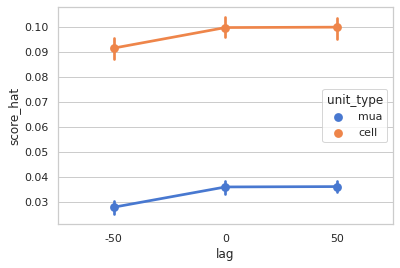

In [87]:
el_m['score_hat'] = mdf.fittedvalues
sns.pointplot(data=el_m[el_m.split=='test'], x='lag', y='score_hat', hue='unit_type', ci=100)


<AxesSubplot:xlabel='lag', ylabel='score_hat'>

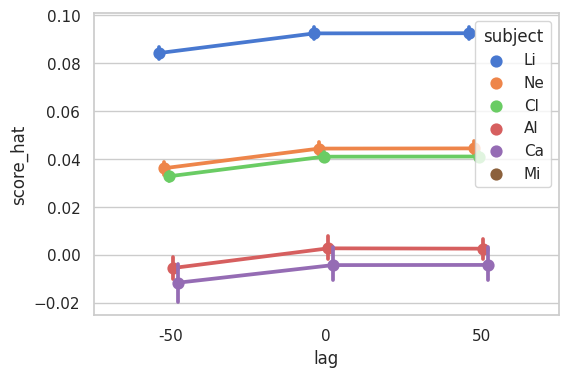

In [88]:
f,ax=plt.subplots(dpi=100)
#sns.pointplot(data=el_m[el_m.unit_type=='cell'], x='lag', y='score', estimator=np.median, hue='subject', hue_order=info.subjects,ax=ax,dodge=True)
sns.pointplot(data=el_m[el_m.split=='test'], x='lag', y='score_hat', estimator=np.mean, hue='subject', hue_order=info.subjects,ax=ax,dodge=True)

In [67]:
rs.get_r2(el2.score.values, mdf.fittedvalues.values)

array([0.1935304])

In [379]:
mdf = smf.mixedlm(formula="score ~ 1 + max_lag + unit_type ", groups='subject', vc_formula=vc_formula, data=el).fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:               MixedLM  Dependent Variable:  score    
No. Observations:    4752     Method:              REML     
No. Groups:          5        Scale:               0.0059   
Min. group size:     120      Log-Likelihood:      5259.5795
Max. group size:     1878     Converged:           Yes      
Mean group size:     950.4                                  
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         0.052    0.033   1.612 0.107 -0.011  0.116
max_lag[T.0]      0.009    0.003   3.228 0.001  0.003  0.014
max_lag[T.50]     0.008    0.003   3.066 0.002  0.003  0.014
unit_type[T.mua] -0.063    0.003 -24.279 0.000 -0.068 -0.058
session Var       0.003    0.007                            
task Var          0.002    0.023                            
============================================================

"""

In [380]:
mdnf =  smf.mixedlm(formula="score ~ 1 + unit_type", groups='subject', vc_formula=vc_formula, data=el).fit()
mdnf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:               MixedLM  Dependent Variable:  score    
No. Observations:    4752     Method:              REML     
No. Groups:          5        Scale:               0.0060   
Min. group size:     120      Log-Likelihood:      5263.0737
Max. group size:     1878     Converged:           Yes      
Mean group size:     950.4                                  
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         0.058    0.032   1.793 0.073 -0.005  0.122
unit_type[T.mua] -0.063    0.003 -24.250 0.000 -0.068 -0.058
session Var       0.003    0.007                            
task Var          0.002    0.023                            
============================================================

"""

In [381]:
mdf.llf-mdnf.llf

-3.4942404853536573

# Encoder Cue Type

In [714]:
%%time
ec = info.get_zone_encoder_cue(overwrite=False)

CPU times: user 75.5 ms, sys: 12 ms, total: 87.5 ms
Wall time: 85.8 ms


In [238]:
ec.shape

(58800, 17)

In [715]:
%%time
ec_m = ec[ec.split=='test'].groupby(['unit_id', 'session', 'subject', 'task','unit_type','cue_type'], dropna=True, observed=True)['score'].mean().reset_index()
ec_m.loc[ec_m.score<-1]=np.nan
ec_m['cue_type'] = ec_m['cue_type'].astype(pd.api.types.CategoricalDtype(['none', 'fixed', 'inter']))
ec_m = ec_m.dropna()

CPU times: user 40.9 ms, sys: 18 µs, total: 40.9 ms
Wall time: 39 ms


### plot by unit type

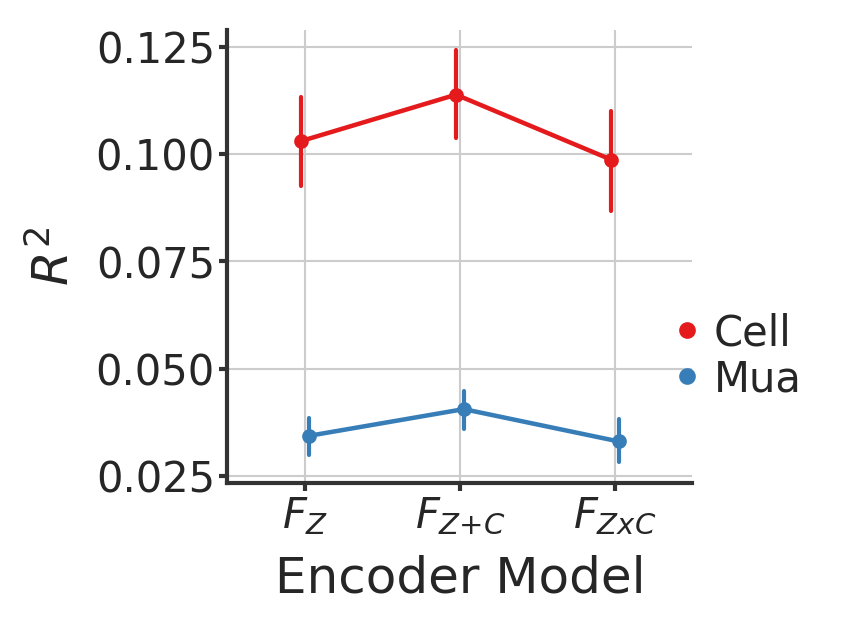

In [716]:
f,ax=plt.subplots(figsize=(2,2), dpi=300)

dpi=600
fn = 'encoder_cue_type_x_cell_type.png'
fontsize = 12
palette = 'Set1'
colors = sns.palettes.color_palette(palette,n_colors=2)

sns.pointplot(data=ec_m, x='cue_type', y='score', estimator=np.mean, 
              hue='unit_type', hue_order=['cell','mua'], ax=ax,dodge=True, palette=palette, scale=0.5, errwidth=1)
ax.set_ylabel(r'$R^2$', fontsize=fontsize)
ax.set_xlabel('Encoder Model', fontsize=fontsize)

name_map = {'none' : r'$F_{Z}$', 
            'fixed': r'$F_{Z \plus C}$', 
            'inter': r'$F_{Z x C}$'}

ax.set_xticklabels(name_map.values(), fontsize=fontsize)
ax.get_legend().remove()

leg_pos = [1.1, 0.1]
legend_elements = [mpl.lines.Line2D([0], [0], marker='o', color=colors[0], lw=0, label='Cell',
                                    markerfacecolor=colors[0], markersize=3),
                   mpl.lines.Line2D([0], [0], marker='o', color=colors[1], lw=0, label='Mua',
                                    markerfacecolor=colors[1], markersize=3),]

ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
             fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

sns.despine(ax=ax)
ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

for sp in ['bottom', 'left']:
    ax.spines[sp].set_linewidth(1)
    ax.spines[sp].set_color('0.2')

ax.grid(linewidth=0.5)

f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

### plot by subject cells only

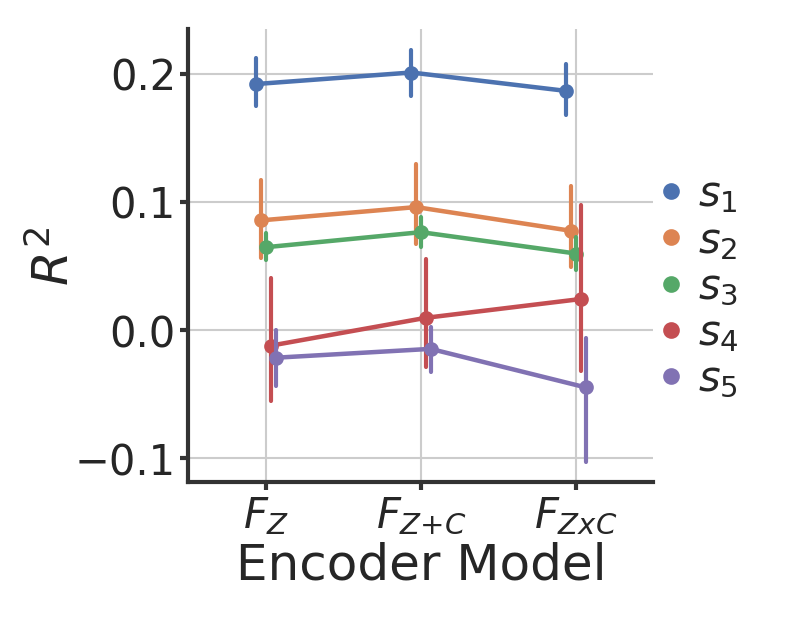

In [719]:
subjects = info.subjects[:5]
n_subjects = len(subjects)
palette = 'deep'

dpi=600
fn = 'encoder_cue_type_x_subject.png'
fontsize = 12
colors = sns.palettes.color_palette(palette,n_colors=n_subjects)

f,ax=plt.subplots(figsize=(2,2), dpi=300)



sns.pointplot(data=ec_m[(ec_m.unit_type=='cell')], x='cue_type', y='score', estimator=np.mean, 
               hue='subject', hue_order=subjects, ax=ax,dodge=True, palette=palette, scale=0.5, errwidth=1)

# sns.pointplot(data=ec_m[(ec_m.split=='test')  & (ec_m.unit_type=='cell')], x='cue_type', y='score', estimator=np.mean, 
#               hue='subject', hue_order=subjects, ax=ax,dodge=True, palette=palette, scale=0.5, errwidth=1)
ax.set_ylabel(f'$R^2$', fontsize=fontsize, labelpad=-1)
ax.set_xlabel('Encoder Model', fontsize=fontsize, labelpad=1)
name_map = {'none' : r'$F_{Z}$', 
            'fixed': r'$F_{Z \plus C}$', 
            'inter': r'$F_{Z x C}$'}

ax.set_xticklabels(name_map.values(), fontsize=fontsize)
ax.get_legend().remove()

leg_pos = [1.1, 0.1]
legend_elements=[]
leg_name_map = [f"$s_{i+1}$" for i in range(n_hues)]
leg_name_map = dict(zip(subjects, leg_name_map))
for ii, ss in enumerate(subjects):
    legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=colors[ii], lw=0, label=leg_name_map[ss],
                                        markerfacecolor=colors[ii], markersize=3))


ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
             fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

sns.despine(ax=ax)
ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

for sp in ['bottom', 'left']:
    ax.spines[sp].set_linewidth(1)
    ax.spines[sp].set_color('0.2')

ax.grid(linewidth=0.5)

f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')



In [241]:
vc_formula ={}
vc_formula['task'] = "1+C(task)"
mdf = smf.mixedlm(formula="score ~ -1 + cue_type + unit_type", groups='subject', vc_formula=vc_formula, data=ec_m).fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:               MixedLM  Dependent Variable:  score    
No. Observations:    5608     Method:              REML     
No. Groups:          5        Scale:               0.0084   
Min. group size:     144      Log-Likelihood:      5423.7854
Max. group size:     2432     Converged:           Yes      
Mean group size:     1121.6                                 
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
cue_type[none]    0.077    0.020   3.805 0.000  0.038  0.117
cue_type[fixed]   0.085    0.020   4.181 0.000  0.045  0.125
cue_type[inter]   0.074    0.020   3.623 0.000  0.034  0.114
unit_type[T.mua] -0.067    0.003 -24.811 0.000 -0.073 -0.062
task Var          0.002    0.012                            
============================================================

"""

In [445]:
unit_type = 'cell'
split = 'test'
cue_types = ['none', 'fixed', 'inter']
for cue1 in cue_types[:-1]:
    idx1 = (ec_m.cue_type==cue1) & (ec_m.split==split) & (ec_m.unit_type==unit_type)
    for cue2 in cue_types[1:]:
        if cue1==cue2:
            continue
        idx2 = (ec_m.cue_type==cue2) & (ec_m.split==split) & (ec_m.unit_type==unit_type)

        print(f"T-Test on fittted values between cue_type1={cue1} and cue_type2={cue2}")
        print(scipy.stats.ttest_ind(mdf.fittedvalues.loc[idx1], mdf.fittedvalues.loc[idx2],nan_policy='omit'))

T-Test on fittted values between cue_type1=none and cue_type2=fixed
Ttest_indResult(statistic=-4.6981123298785334, pvalue=2.9505726947316946e-06)
T-Test on fittted values between cue_type1=none and cue_type2=inter
Ttest_indResult(statistic=-2.266487338642679, pvalue=0.02362416505338628)
T-Test on fittted values between cue_type1=fixed and cue_type2=inter
Ttest_indResult(statistic=2.328945829760648, pvalue=0.02005059222646577)


In [404]:
unit_type = 'cell'
split = 'test'
cue_types = ['none', 'fixed', 'inter']
for cue1 in cue_types[:-1]:
    idx1 = (ec_m.cue_type==cue1) & (ec_m.split==split) & (ec_m.unit_type==unit_type)
    for cue2 in cue_types[1:]:
        if cue1==cue2:
            continue
        idx2 = (ec_m.cue_type==cue2) & (ec_m.split==split) & (ec_m.unit_type==unit_type)
        print(f"T-Test on data between cue_type1={cue1} and cue_type2={cue2}")
        print(scipy.stats.ttest_ind(ec_m.score[idx1], ec_m.score[idx2],nan_policy='omit'))

T-Test on data between cue_type1=none and cue_type2=fixed
Ttest_indResult(statistic=-1.4205416186477828, pvalue=0.15572763876159043)
T-Test on data between cue_type1=none and cue_type2=inter
Ttest_indResult(statistic=0.5436949080014094, pvalue=0.5867667421750625)
T-Test on data between cue_type1=fixed and cue_type2=inter
Ttest_indResult(statistic=1.9109064381796255, pvalue=0.05628818172481067)


### plot pairwise

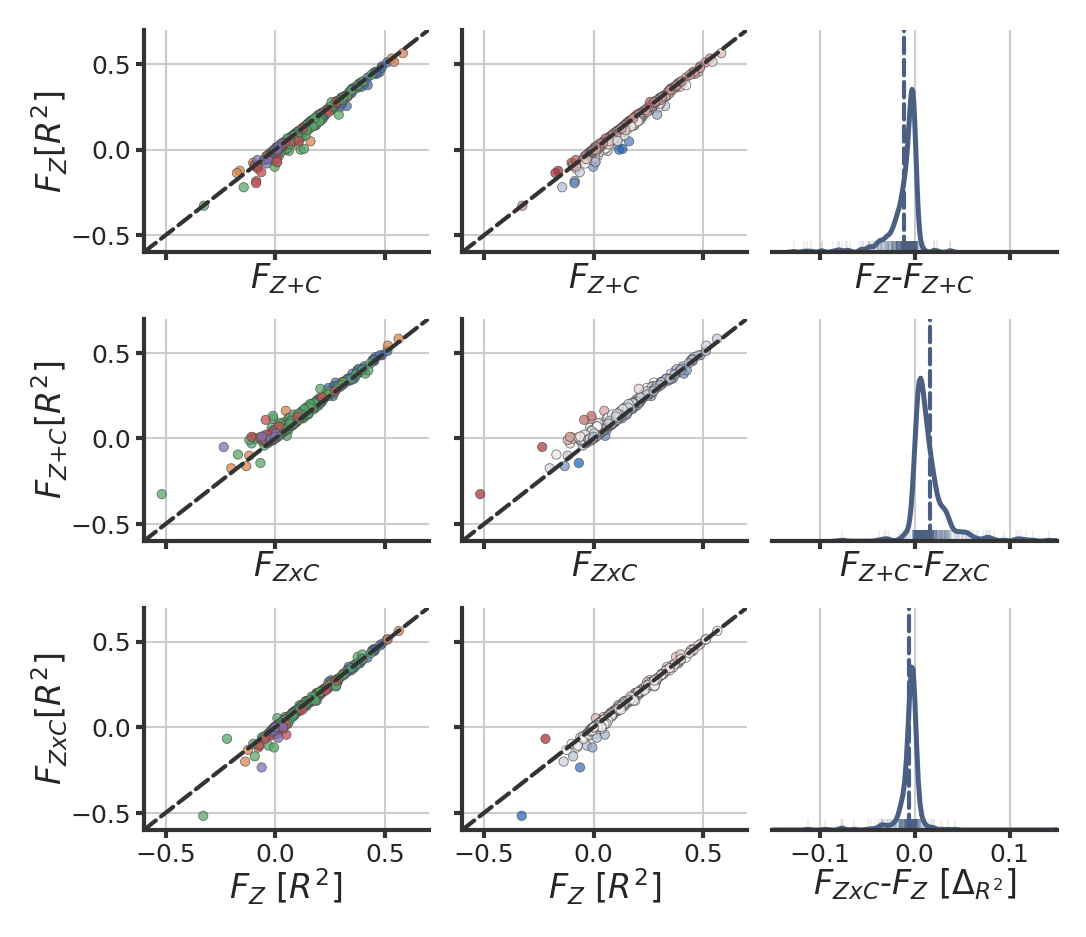

In [722]:
dpi=600
fn = 'encoder_cue_type_pairs.png'
fontsize = 8

unit_type = 'cell'
split = 'test'
cue_types = ['none', 'fixed', 'inter']
name_map = {'none' : r'$F_{Z}$', 
            'fixed': r'$F_{Z \plus C}$', 
            'inter': r'$F_{Z x C}$'}


#df =ec_m[(ec_m.split==split) & (ec_m.unit_type==unit_type)].pivot(index='unit_id', values='score', columns='cue_type')
df =ec_m[(ec_m.unit_type==unit_type)].pivot(index='unit_id', values='score', columns='cue_type')


subj_unit_xtab = pd.crosstab(ec.unit_id, ec.subject)>0
subj_by_unit = subj_unit_xtab.idxmax(axis=1)

df['subject'] = subj_by_unit[df.index]

min_val = np.nanmin(df[cue_types].values)
max_val = np.nanmax(df[cue_types].values)

min_val = np.around(min_val*1.1,1)
max_val = np.around(max_val*1.2,1)

f,ax=plt.subplots(3,3, figsize=(3.5,3), dpi=300, constrained_layout=True)

comps = [('fixed', 'none'),
         ('inter', 'fixed'), 
         ('none', 'inter')]

scatter_dot_size = 5
scatter_dot_ec = '0.3'
scatter_dot_lw = 0.2
for ii in range(3):
    for jj in range(3):
        lag1, lag2 = comps[ii]
        
        name1 = name_map[lag1]
        name2 = name_map[lag2]
        df['delta'] = df[lag2]-df[lag1]
        
        
        # by subject
        if jj==0:
            sns.scatterplot(x=lag1, y=lag2, data=df,ax=ax[ii,jj], hue='subject', s=scatter_dot_size, hue_order=info.subjects, legend=False, palette='deep', alpha=0.75,
                                                      **{'linewidth': scatter_dot_lw, 'edgecolor': scatter_dot_ec})

            ax[ii,jj].set_ylim([min_val, max_val])
            ax[ii,jj].plot([min_val, max_val], [min_val, max_val], '--', color='0.2', lw=1)   
        # by unit and delta
        elif jj==1:
            sns.scatterplot(x=lag1, y=lag2, data=df,ax=ax[ii,jj], hue='delta', s=scatter_dot_size, legend=False, palette='vlag', alpha=0.75,
                                                      **{'linewidth': scatter_dot_lw, 'edgecolor': scatter_dot_ec})
            ax[ii,jj].set_ylim([min_val, max_val])
            ax[ii,jj].plot([min_val, max_val], [min_val, max_val], '--', color='0.2', lw=1)    
        # delta
        elif jj==2:
            #sns.histplot(x='delta', data=df,  ax=ax[ii,jj], color='#7095CD', bins=50, stat='percent', kde=True)
            sns.kdeplot(x='delta', data=df,  ax=ax[ii,jj], color='#4A5F82', bw_adjust=0.5)
            sns.rugplot(x='delta', data=df,  ax=ax[ii,jj], color='#4A5F82', expand_margins=False, lw=0.05, alpha=0.9, height=0.05)
            #sns.boxplot(x='delta', data=el_m2,  ax=ax[ii,jj])
            ax[ii,jj].set_yticks([])
            ax_w, ax_h = ax[ii,jj].get_ylim()
            ax[ii,jj].set_ylim([ax_w, ax_h*1.3])
            ax[ii,jj].axvline(df.delta.mean(), linestyle='--', color='#4A5F82', lw=1)
            ax[ii,jj].set_xlim([-0.15, 0.15])

          
        sns.despine(ax=ax[ii,jj])
        ax[ii,jj].tick_params(axis='both', labelsize=fontsize-2, pad=0, color='0.2',  length=2, width=1, which='major')
        if jj <2:
            ax[ii,jj].set_xlim([min_val, max_val])
            for sp in ['bottom', 'left']:
                ax[ii,jj].spines[sp].set_linewidth(1)
                ax[ii,jj].spines[sp].set_color('0.2')
        else:
            for sp in ['bottom']:
                ax[ii,jj].spines[sp].set_linewidth(1)
                ax[ii,jj].spines[sp].set_color('0.2')
            ax[ii,jj].spines['left'].set_visible(False)
            
           
        if (ii<2):
            ax[ii,jj].set_xticklabels([])
            ax[ii,jj].set_xlabel('')
        else:
            ax[ii,jj].tick_params(axis="x", direction="out", length=2, width=1, color='0.2', which='major',
                       pad=1, labelsize=fontsize-2, bottom=True, left=True)
        if (jj>0):
            ax[ii,jj].set_yticklabels([])
            ax[ii,jj].set_ylabel('')
        else:
            ax[ii,jj].tick_params(axis="y", direction="out", length=2, width=1, color='0.2', which='major',
                       pad=1, labelsize=fontsize-2, bottom=True, left=True)
#         sns.despine(ax=ax[ii,jj])
#         ax[ii,jj].tick_params(axis='both', labelsize=fontsize-2, pad=0, color='0.2', which='major')
#         if jj <2:
#             ax[ii,jj].set_xlim([min_val, max_val])
#             for sp in ['bottom', 'left']:
#                 ax[ii,jj].spines[sp].set_linewidth(1)
#                 ax[ii,jj].spines[sp].set_color('0.2')
#         else:
#             for sp in ['bottom']:
#                 ax[ii,jj].spines[sp].set_linewidth(1)
#                 ax[ii,jj].spines[sp].set_color('0.2')
#             ax[ii,jj].spines['left'].set_visible(False)
            
           
#         if (ii<2):
#             ax[ii,jj].set_xticklabels([])
#             ax[ii,jj].set_xlabel('')
#         else:
#             ax[ii,jj].tick_params(axis="x", direction="out", length=2, width=1, color='0.2', which='major',
#                        pad=1, labelsize=fontsize-2, bottom=True, left=True)
#         if (jj>0):
#             ax[ii,jj].set_yticklabels([])
#             ax[ii,jj].set_ylabel('')
#         else:
#             ax[ii,jj].tick_params(axis="y", direction="out", length=2, width=1, color='0.2', which='major',
#                        pad=1, labelsize=fontsize-2, bottom=True, left=True)

        if ii==2:
            if jj==2:
                ax[ii,jj].set_xlabel(name2 + '-' + name1 + f" $[\Delta_{{R^2}}]$", fontsize=fontsize, labelpad=0)
            else:
                ax[ii,jj].set_xlabel(name1 +  f" $[R^2]$", fontsize=fontsize, labelpad=0)
        else:
            if (jj==2):
                ax[ii,jj].set_xlabel(name2 + '-' + name1, fontsize=fontsize, labelpad=0)
            else:
                ax[ii,jj].set_xlabel(name1, fontsize=fontsize, labelpad=0)
        
        if jj==0:
            ax[ii,jj].set_ylabel(name2 +  f" $[R^2]$", fontsize=fontsize, labelpad=0)
            
        
#         if ii==2:
#             if jj==2:
#                 #ax[ii,jj].set_xlabel(f"$F_{{{name2}}}-F_{{{name1}}} [\Delta_{{R^2}}]$", fontsize=fontsize, labelpad=0)
#                 ax[ii,jj].set_xlabel(f"{name2} - {name1} $ [\Delta_{{R^2}}]$", fontsize=fontsize, labelpad=0)
#             else:
#                 ax[ii,jj].set_xlabel(name1 + f"$ [R^2]$", fontsize=fontsize, labelpad=0)
#         else:
#             if (jj==2):
#                 ax[ii,jj].set_xlabel(name2 + '-' + name1 , fontsize=fontsize, labelpad=-2)
#             else:
#                 ax[ii,jj].set_xlabel(name1, fontsize=fontsize, labelpad=-2)
        
#         if jj==0:
            ax[ii,jj].set_ylabel(name2 + f"$ [R^2]$", fontsize=fontsize, labelpad=0)
        
        ax[ii,jj].grid(linewidth=0.5)
        
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

# Decoder

In [243]:
%%time
ov = False
de = info.get_zone_decoder(overwrite=ov)

CPU times: user 1.92 s, sys: 64.1 ms, total: 1.98 s
Wall time: 1.98 s


In [244]:
de.head()

encoder_type feature_type target_type  fold zones cue       acc       bac  \
0            Z      encoder         cue     0     H   L  0.400000  0.485714   
1            Z      encoder         cue     0     H   R  0.571429  0.485714   
2            Z      encoder         cue     0   a_0   L  1.000000  0.500000   
3            Z      encoder         cue     0   a_0   R  0.000000  0.500000   
4            Z      encoder         cue     0   a_1   L  1.000000  0.500000   

       dist  logit_dist subject        session task  n_units  
0  0.600000    0.013773      Li  Li_T3g_052818  T3g        2  
1  0.428571    0.012643      Li  Li_T3g_052818  T3g        2  
2  0.000000    0.000000      Li  Li_T3g_052818  T3g        2  
3  1.000000    0.966969      Li  Li_T3g_052818  T3g        2  
4  0.000000    0.000000      Li  Li_T3g_052818  T3g        2

In [245]:
target_types = de.target_type.unique()
feature_types = de.feature_type.unique()
encoder_types = de.encoder_type.unique()
zones = de.zones.unique()
subjects = info.subjects[:5]
cue = ['L', 'R']

## cue decoding

In [801]:
%%time
target = 'cue'
de_cue = de.loc[(de.target_type==target)].groupby(['encoder_type', 'zones', 'subject', 'session', 'task'], dropna=True, observed=True).mean().reset_index()
de_cue = de_cue.dropna()

CPU times: user 165 ms, sys: 0 ns, total: 165 ms
Wall time: 162 ms



## plot cue decoder accuracy x zone x encoder type

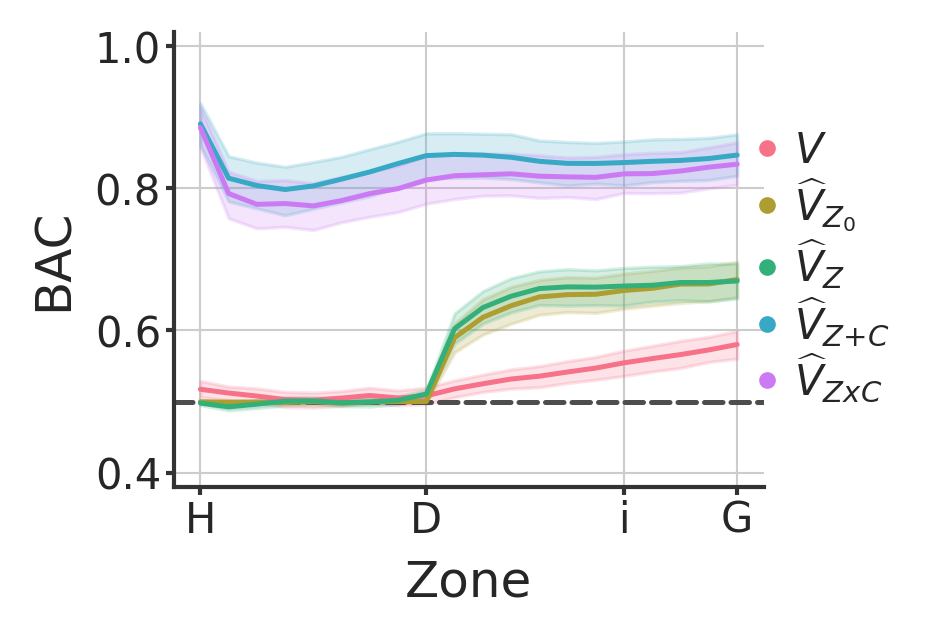

In [724]:

# dpi=600
# fontsize = 12
# fn = "cue_decoder_perf_zone_x_enc.png"


# hue = 'encoder_type'
# name_map = {'neural': r'$V$',
#             'Z0':r'$\widehat{V}_{Z_0}$',
#             'Z': r'$\widehat{V}_Z$', 
#             'Z+C':r'$\widehat{V}_{Z \plus C}$',
#             'ZxC':r'$\widehat{V}_{Z x C}$'}

# encoder_name_map = name_map
# n_hues = len(name_map)
# palette = sns.color_palette("husl", n_hues)
# metric = 'bac'

# f,ax=plt.subplots(figsize=(3,2), dpi=300, constrained_layout=True)


# sns.lineplot(data=de_cue, x='zones', y='bac', hue=hue, hue_order=name_map.keys(), palette=palette, markers=False, ax=ax)
# ax.get_legend().remove()
# ax.set_xticks([0,8,15,19])
# ax.set_ylim([0.38,1.02])
# ax.axhline(0.5, linestyle='--', color='0.3', zorder=1)

# ax.set_xlabel('Zone', fontsize=fontsize)
# ax.set_ylabel('BAC', fontsize=fontsize)

# leg_pos = [1.1, 0.1]

# legend_elements = []
# for ii, k in enumerate(name_map.keys()):
    
#     legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[ii], lw=0, label=name_map[k],
#                                         markerfacecolor=palette[ii], markersize=3))
    
# ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
#              fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

# sns.despine(ax=ax)
# ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

# for sp in ['bottom', 'left']:
#     ax.spines[sp].set_linewidth(1)
#     ax.spines[sp].set_color('0.2')

# ax.grid(linewidth=0.5)


# f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')


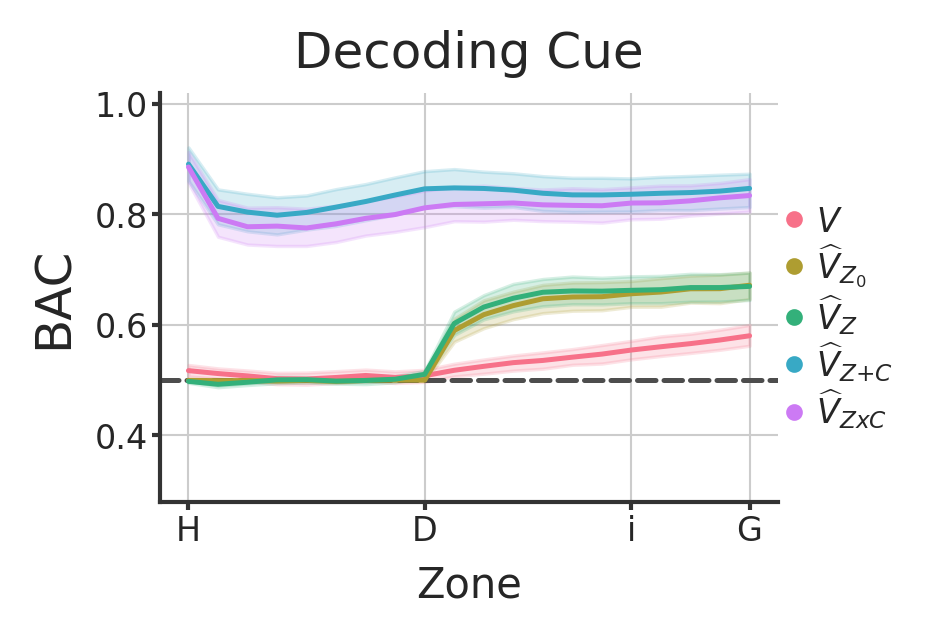

In [805]:
dpi=600
fontsize = 12
fn = "cue_decoder_perf_zone_x_enc.png"

hue_var = 'encoder_type'
hue_names = ['neural', 'Z0', 'Z', 'Z+C', 'ZxC']
f,ax = decoder_perf_x_zone(data_table=de_cue, hue_var=hue_var, hue_names=hue_names)
ax.set_ylabel('BAC', fontsize=fontsize)
ax.set_title('Decoding Cue',fontsize=fontsize)
ax.axhline(0.5,linestyle='--', color='0.3', zorder=1)
ax.set_ylim([0.28,1.02])

f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')


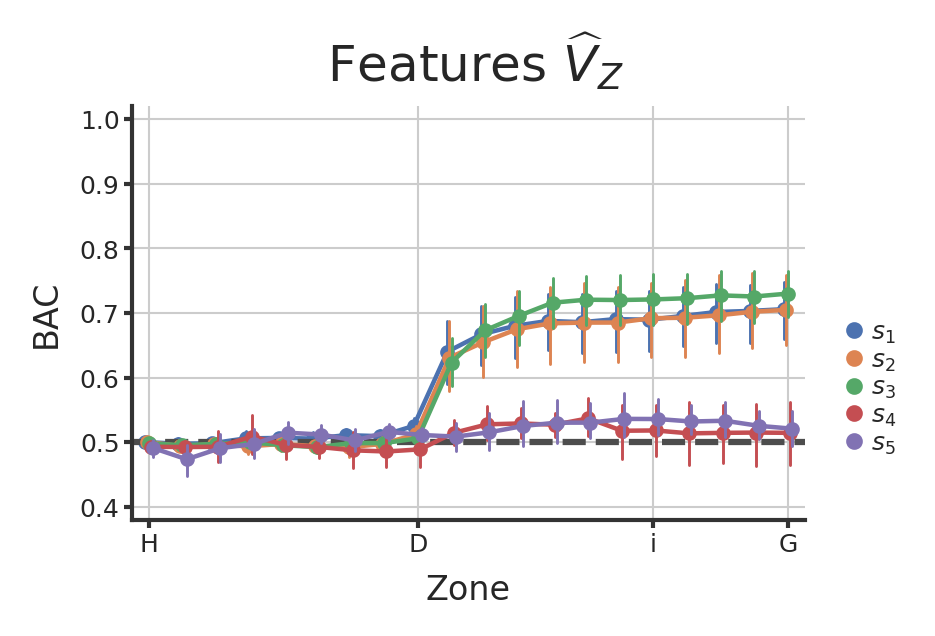

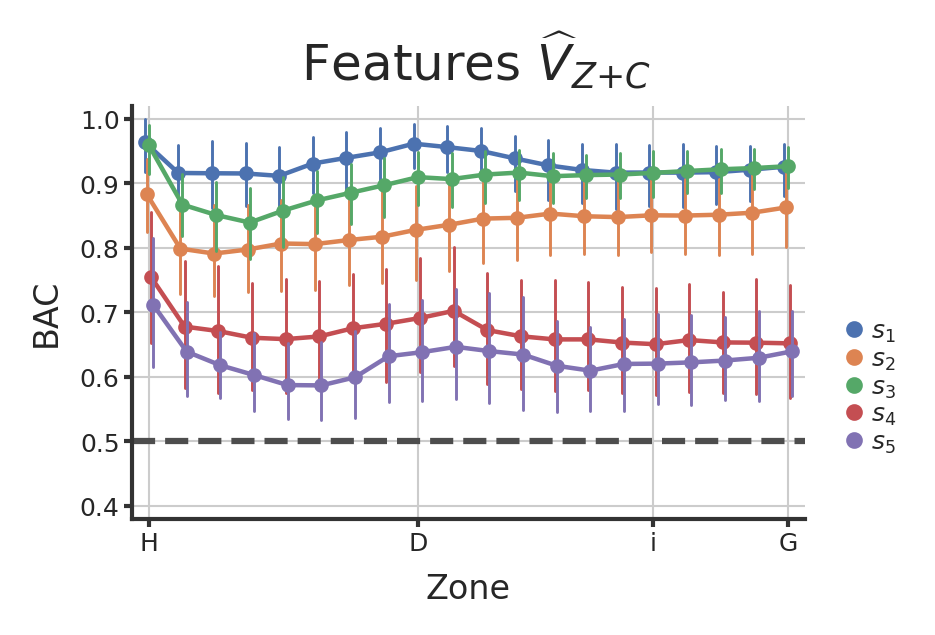

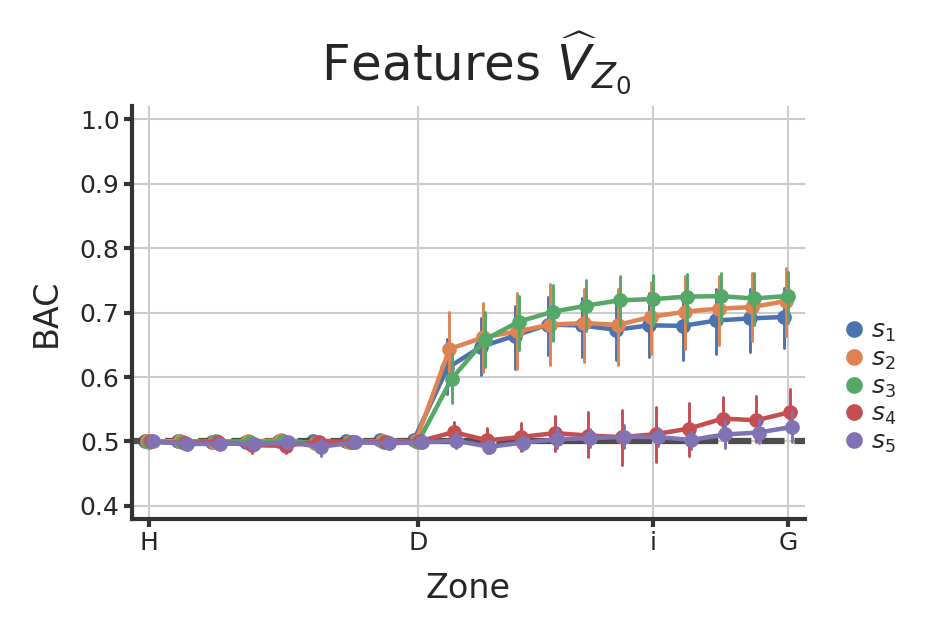

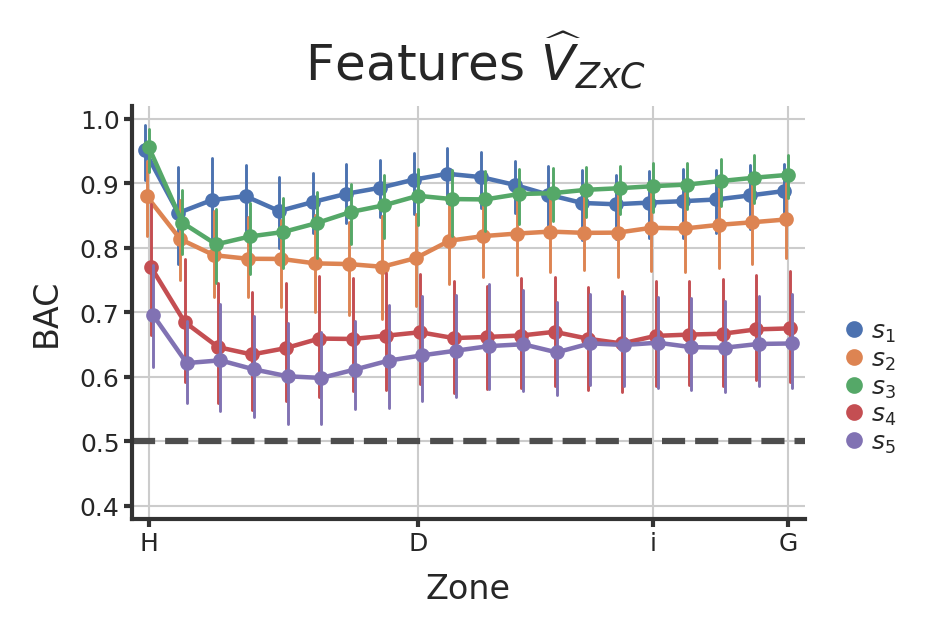

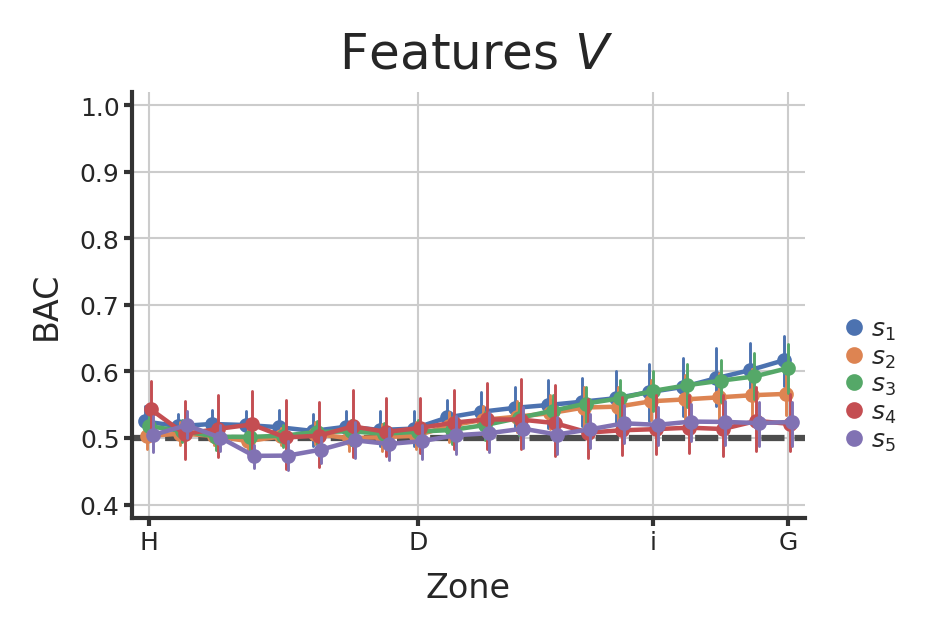

In [737]:

dpi=600

encoder = 'Z'

for encoder in encoder_types:
    fn = f"decoder_perf_zone_enc_{encoder}_subj.png"

    hue = 'subject'

    n_hues = len(subjects)
    palette = sns.color_palette('deep', n_hues)
    metric = 'bac'

    f,ax=plt.subplots(figsize=(3,2), dpi=300, constrained_layout=True)


    #sns.lineplot(data=de_cue[de_cue.encoder_type=='Z+C'], x='zones', y='bac', hue=hue, hue_order=subjects, palette=palette, markers=False, ax=ax)
    sns.pointplot(data=de_cue[de_cue.encoder_type==encoder], x='zones', y='bac', hue=hue, hue_order=subjects, palette=palette, ax=ax, dodge=0.25, scale=0.4, errwidth=0.7)

    ax.get_legend().remove()
    ax.set_xticks([0,8,15,19])
    ax.set_ylim([0.38,1.02])
    ax.axhline(0.5, linestyle='--', color='0.3', zorder=1)

    ax.set_xlabel('Zone', fontsize=fontsize)
    ax.set_ylabel('BAC', fontsize=fontsize)
    ax.set_title(f" Features {encoder_name_map[encoder]}")

    leg_pos = [1.1, 0.1]

    legend_elements = []
    subjects2 = [f"$s_{i+1}$" for i in range(n_hues)]
    name_map = dict(zip(subjects,subjects2))
    for ii, k in enumerate(subjects):
        legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[ii], lw=0, label=name_map[k],
                                            markerfacecolor=palette[ii], markersize=3))

    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                 fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)

    f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

In [677]:
zones[9:]

['be_0', 'be_1', 'be_2', 'be_3', 'be_4', ..., 'i', 'cdfg_0', 'cdfg_1', 'cdfg_2', 'G']
Length: 11
Categories (20, object): ['H', 'a_0', 'a_1', 'a_2', ..., 'cdfg_0', 'cdfg_1', 'cdfg_2', 'G']

In [689]:
stem_zones = zones[:9]
branch_zones = zones[9:]

de_cue2 = de_cue.copy()
de_cue2.loc[ de_cue.zones.isin(stem_zones) ,'seg'] = 'stem'
de_cue2.loc[ de_cue.zones.isin(branch_zones) ,'seg'] = 'branch'

de_cue2 = de_cue2.groupby(['encoder_type', 'subject', 'session','task', 'seg'])['bac', 'logit_dist','n_units'].mean().reset_index()

de_cue2


/tmp/ipykernel_31631/1129404050.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  de_cue2 = de_cue2.groupby(['encoder_type', 'subject', 'session','task', 'seg'])['bac', 'logit_dist','n_units'].mean().reset_index()


encoder_type subject        session task     seg       bac  logit_dist  \
0               Z      Al  AL_T3g_101218  T3g  branch  0.502929    1.605722   
1               Z      Al  AL_T3g_101218  T3g    stem  0.506111    0.583513   
2               Z      Al  Al_T3g_092618  T3g  branch  0.409091    4.630088   
3               Z      Al  Al_T3g_092618  T3g    stem  0.494444    0.918628   
4               Z      Al  Al_T3g_092718  T3g  branch  0.566667    4.927120   
...           ...     ...            ...  ...     ...       ...         ...   
1405       neural      Ne  NE_T3j_062918  T3j    stem  0.602778    0.370565   
1406       neural      Ne  Ne_T3g_060118  T3g  branch  0.610606    1.886712   
1407       neural      Ne  Ne_T3g_060118  T3g    stem  0.546296    0.819868   
1408       neural      Ne  Ne_T3i_060818  T3i  branch  0.576028    0.584667   
1409       neural      Ne  Ne_T3i_060818  T3i    stem  0.523611    0.200170   

      n_units  
0         1.0  
1         1.0  
2        10.0  
3        10.0  
4        28.0  
...       ...  
1405      2.0  
1406     20.0  
1407     20.0  
1408      4.0  
1409      4.0  

[1410 rows x 8 columns]

### encoder perf by subject

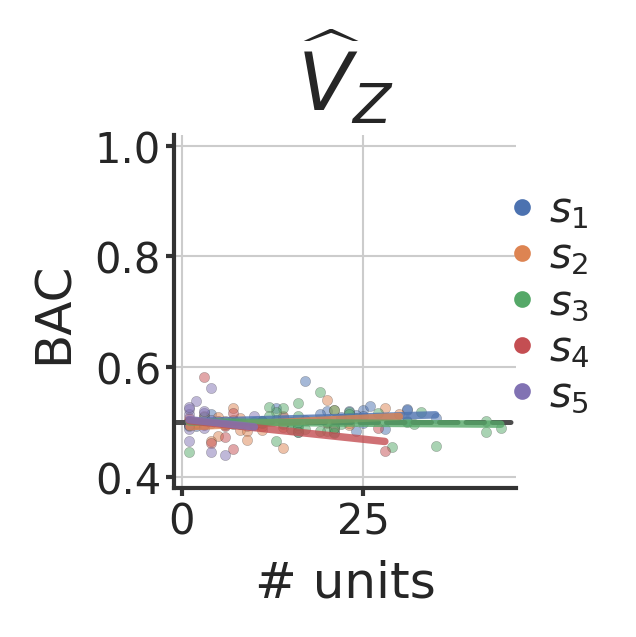

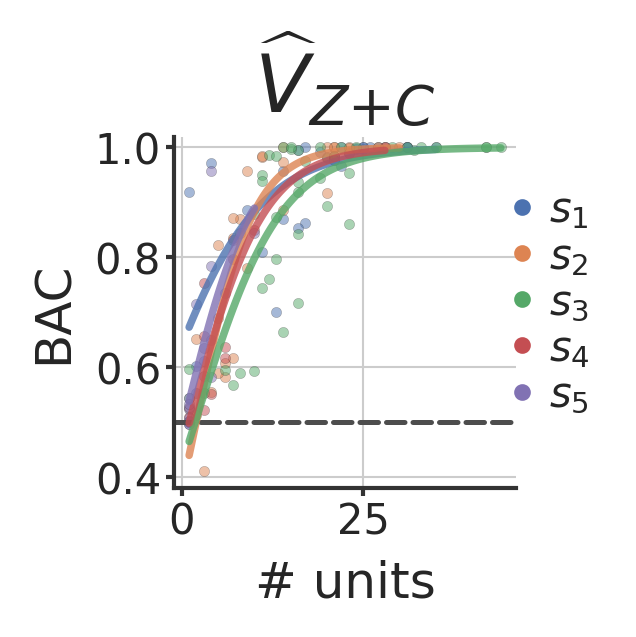

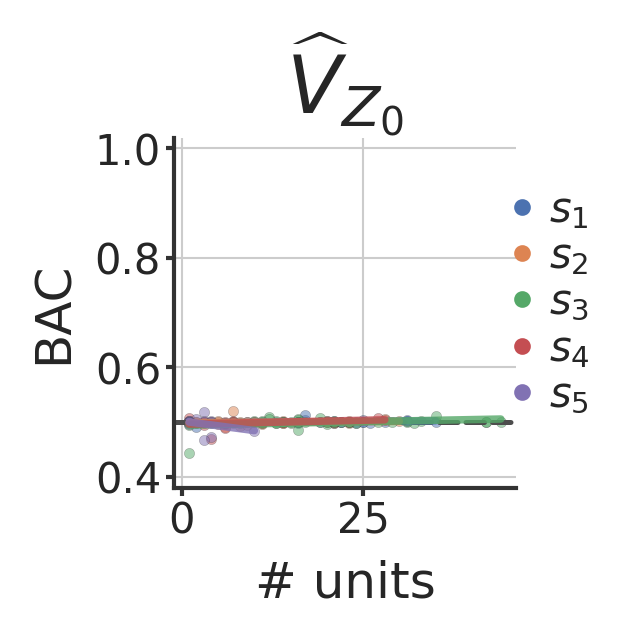

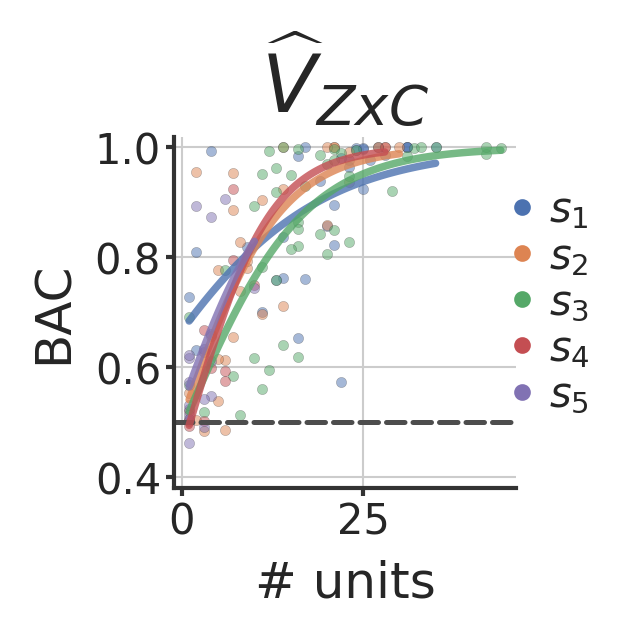

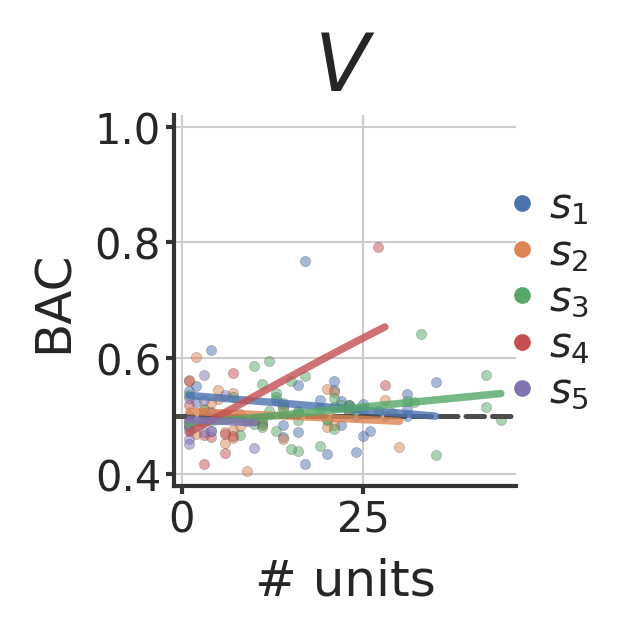

In [725]:
metric = 'bac'
seg = 'stem'

n_hues = len(subjects)
palette = sns.color_palette('deep', n_hues)

for encoder in encoder_types:

    fn = f"decoder_perf_unit_enc_{encoder}_subj.png"

    f,ax=plt.subplots(figsize=(2,2), dpi=300, constrained_layout=True)

    for ii, ss in enumerate(subjects):
        sns.regplot(x='n_units', y='bac', logistic=True, ci=None, color=palette[ii], scatter_kws=dict(alpha=0.5, lw=0.1, s=6,edgecolors='0.2'), line_kws=dict(alpha=0.8),
               data=de_cue2[ (de_cue2.encoder_type==encoder) & (de_cue2.subject==ss) & (de_cue2.seg==seg)], ax=ax)

    ax.set_ylim([0.38,1.02])
    ax.axhline(0.5, linestyle='--', color='0.3', zorder=1)
    ax.set_xlabel('# units', fontsize=fontsize)
    ax.set_ylabel('BAC', fontsize=fontsize)
    ax.set_title(f"{encoder_name_map[encoder]}")

    leg_pos = [1.1, 0.1]

    legend_elements = []
    subjects2 = [f"$s_{i+1}$" for i in range(n_hues)]
    name_map = dict(zip(subjects,subjects2))
    for ii, k in enumerate(subjects):
        legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[ii], lw=0, label=name_map[k],
                                            markerfacecolor=palette[ii], markersize=3))

    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                 fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)

    f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

### stem and branch by unit and encoder type

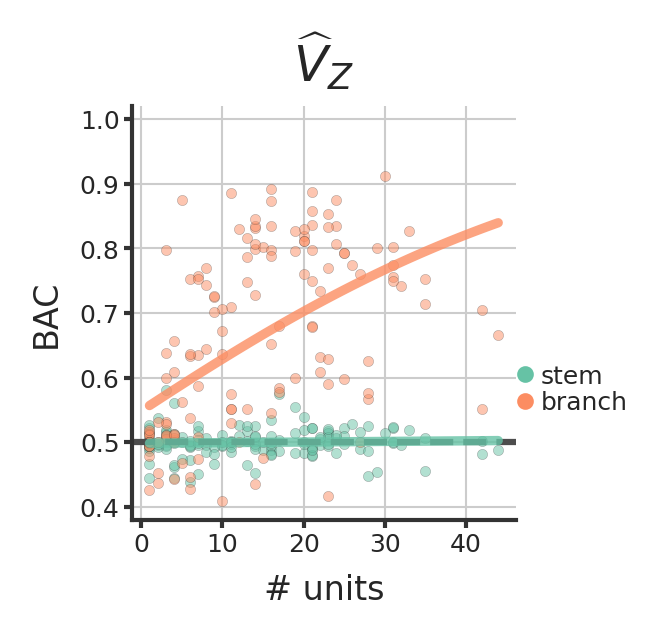

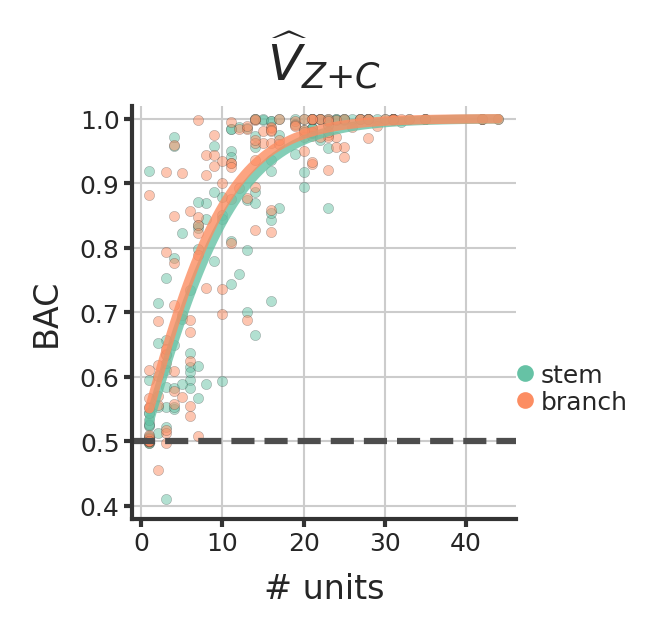

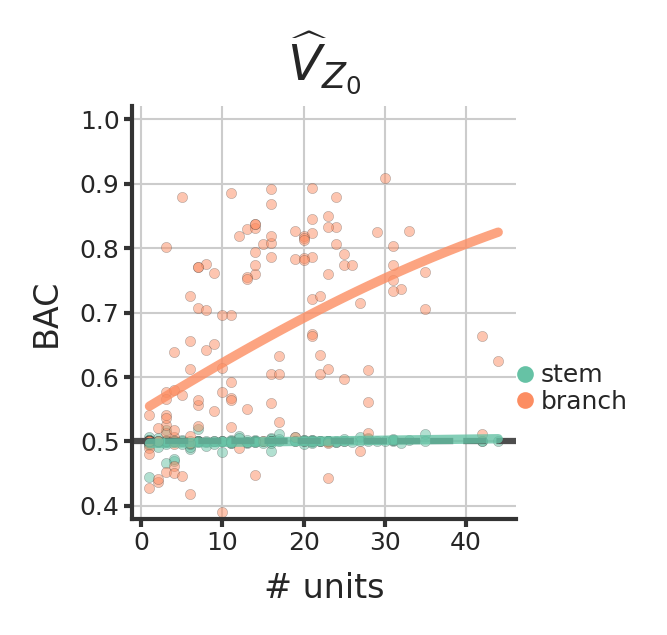

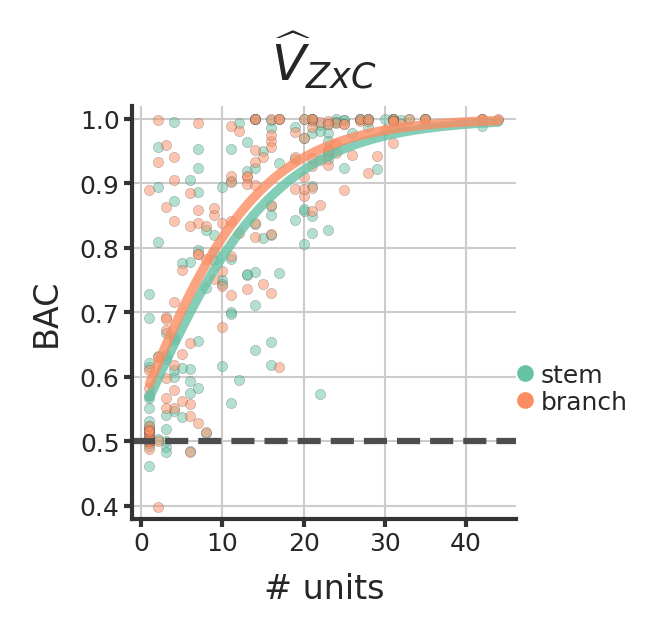

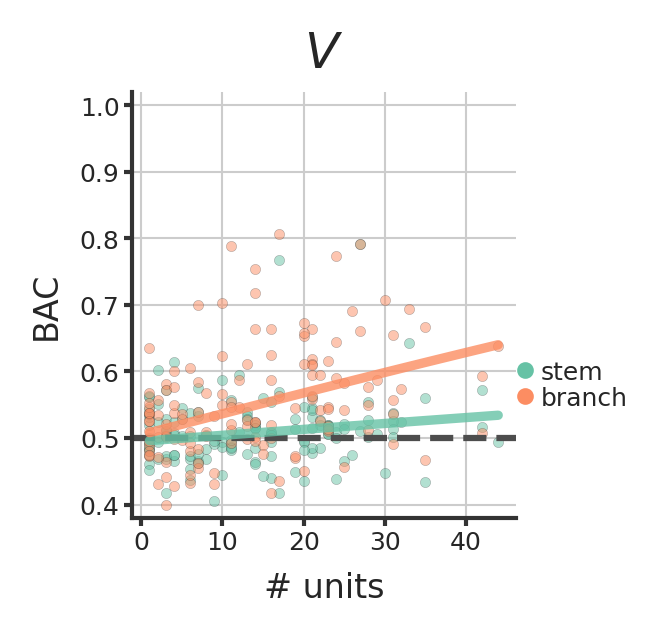

In [742]:
metric = 'bac'

segments = ['stem', 'branch']
n_hues = 2
palette = sns.color_palette('Set2', n_hues)

for encoder in encoder_types:

    fn = f"decoder_perf_unit_enc_{encoder}_seg.png"

    f,ax=plt.subplots(figsize=(2.1,2), dpi=300, constrained_layout=True)

    for ii, ss in enumerate(segments):
        sns.regplot(x='n_units', y='bac', logistic=True, ci=None, color=palette[ii], scatter_kws=dict(alpha=0.5, lw=0.1, s=6,edgecolors='0.2'), line_kws=dict(alpha=0.8),
               data=de_cue2[ (de_cue2.encoder_type==encoder) & (de_cue2.seg==ss)], ax=ax)

    ax.set_ylim([0.38,1.02])
    ax.axhline(0.5, linestyle='--', color='0.3', zorder=1)
    ax.set_xlabel('# units', fontsize=fontsize)
    ax.set_ylabel('BAC', fontsize=fontsize)
    ax.set_title(f"{encoder_name_map[encoder]}")

    leg_pos = [1.15, 0.2]

    legend_elements = []
    for ii, k in enumerate(segments):
        legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[ii], lw=0, label=k,
                                            markerfacecolor=palette[ii], markersize=3))

    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                 fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)

    f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

### plot stem and branch perf by # units

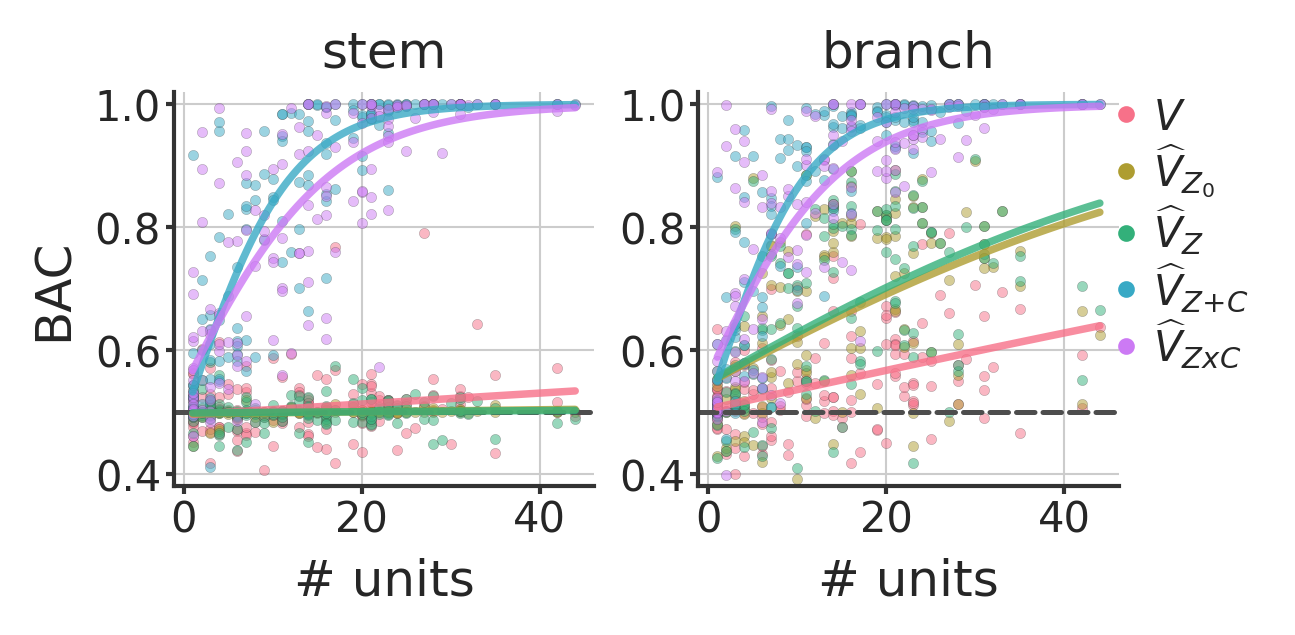

In [727]:
metric = 'bac'

n_hues = len(encoder_types)
palette = sns.color_palette("husl", n_hues)
segments = ['stem', 'branch']

fn = f"decoder_perf_unit_enc_x_seg.png"

f,axs=plt.subplots(1,2, figsize=(4.2,2), dpi=300, constrained_layout=True)

for ii, seg in enumerate(segments):
    ax = axs[ii]
    for jj, enc in enumerate(encoder_name_map.keys()):
        sns.regplot(x='n_units', y='bac', logistic=True, ci=None, color=palette[jj], 
                    scatter_kws=dict(alpha=0.5, lw=0.1, s=6,edgecolors='0.2'), 
                    line_kws=dict(alpha=0.8),
                    data=de_cue2[ (de_cue2.encoder_type==enc) & (de_cue2.seg==seg)], ax=ax)


    ax.set_ylim([0.38,1.02])
    ax.axhline(0.5, linestyle='--', color='0.3', zorder=1)
    ax.set_xlabel('# units', fontsize=fontsize)
    ax.set_ylabel('BAC', fontsize=fontsize)
    ax.set_title(f"{seg}", fontsize=fontsize)

    leg_pos = [1.15, 0.2]

    if ii==1:
        ax.set_ylabel('', fontsize=fontsize)
        legend_elements = []
        for jj, k in enumerate(encoder_name_map.keys()):
            legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[jj], lw=0, label=encoder_name_map[k],
                                                markerfacecolor=palette[jj], markersize=3))

        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                     fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)

f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

### encoder/decoder relationship

In [264]:
ec_m2 = ec_m.copy()
ec_m2['cue_type'] = ec_m2['cue_type'].replace({'none':'Z', 'fixed':'Z+C', 'inter': 'ZxC'})

stem_zones = zones[:9]
branch_zones = zones[9:]

de_cue2 = de_cue.copy()
de_cue2.loc[ de_cue2.zones.isin(stem_zones) ,'seg'] = 'stem'
de_cue2.loc[ de_cue2.zones.isin(branch_zones) ,'seg'] = 'branch'
de_cue2 = de_cue2.groupby(['encoder_type', 'session', 'task', 'subject', 'seg'], dropna=True, observed=True).mean().reset_index()


In [266]:
encoder = 'Z'
print(ec_m2[ec_m2.cue_type==encoder].shape)
print(de_cue2[de_cue2.encoder_type==encoder].shape)

(1957, 7)
(282, 11)


In [273]:
df = ec_m2.copy()

In [279]:
df.head()

unit_id        session subject task unit_type cue_type     score
0      0.0  Li_T3g_052818      Li  T3g       mua        Z  0.081993
1      0.0  Li_T3g_052818      Li  T3g       mua      Z+C  0.085707
2      0.0  Li_T3g_052818      Li  T3g       mua      ZxC  0.072131
3      1.0  Li_T3g_052818      Li  T3g       mua        Z  0.018713
4      1.0  Li_T3g_052818      Li  T3g       mua      Z+C  0.020300

In [312]:
df = ec_m2.copy()
sessions = de_cue2.session.unique()
for se in sessions:
    for encoder in ['Z', 'Z+C', 'ZxC']:
        for seg in ['stem', 'branch']:
            df.loc[(df.cue_type==encoder) & (df.session==se), 'decoder_acc_'+seg] = de_cue2[(de_cue2.encoder_type==encoder) & (de_cue2.seg==seg) & (de_cue2.session==se)]['acc'].values[0]
    df.loc[(df.session==se), 'n_units'] = de_cue2[(de_cue2.session==se)]['n_units'].values[0]

<AxesSubplot:xlabel='score', ylabel='decoder_acc_stem'>

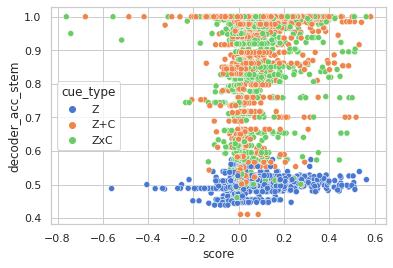

In [313]:
sns.scatterplot(data=df, x='score', y='decoder_acc_stem', hue='cue_type')

In [310]:
df_m =df.groupby(['session', 'subject', 'task', 'cue_type'],dropna=True, observed=True).mean().reset_index()
df_m.head()

session subject task cue_type  unit_id     score  decoder_acc_stem  \
0  AL_T3g_101218      Al  T3g        Z   1896.0  0.018273          0.506111   
1  AL_T3g_101218      Al  T3g      Z+C   1896.0  0.026613          0.508232   
2  AL_T3g_101218      Al  T3g      ZxC   1896.0  0.001894          0.519242   
3  Al_T3g_092618      Al  T3g        Z   1805.5 -0.044118          0.494444   
4  Al_T3g_092618      Al  T3g      Z+C   1805.5 -0.040131          0.850000   

   decoder_acc_branch  
0            0.502929  
1            0.500000  
2            0.513499  
3            0.409091  
4            0.736364

In [315]:
vc_formula ={}
vc_formula['task'] = "1+C(task)"
mdf = smf.mixedlm(formula="decoder_acc_stem ~ -1 + cue_type  + score*n_units", groups='subject', vc_formula=vc_formula, data=df).fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: decoder_acc_stem
No. Observations: 5608    Method:             REML            
No. Groups:       5       Scale:              0.0074          
Min. group size:  144     Log-Likelihood:     5763.4368       
Max. group size:  2432    Converged:          Yes             
Mean group size:  1121.6                                      
---------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
cue_type[Z]      0.374     0.022  16.790  0.000   0.330   0.417
cue_type[Z+C]    0.808     0.022  36.288  0.000   0.764   0.852
cue_type[ZxC]    0.771     0.022  34.629  0.000   0.728   0.815
score           -0.141     0.033  -4.252  0.000  -0.205  -0.076
n_units          0.005     0.000  34.952  0.000   0.005   0.006
score:n_units    0.004     0.001   3.007  0.003   0.002   0.007
task Var         0.002     0.014                               
==============================================================

"""

In [296]:
se = 'Li_T3g_052818'
de_cue2[(de_cue2.encoder_type==encoder) & (de_cue2.seg==seg) & (de_cue2.session==se)]['acc']

159    0.495608
Name: acc, dtype: float64

### stats

In [754]:
de_cue2

encoder_type subject        session task     seg       bac  logit_dist  \
0               Z      Al  AL_T3g_101218  T3g  branch  0.502929    1.605722   
1               Z      Al  AL_T3g_101218  T3g    stem  0.506111    0.583513   
2               Z      Al  Al_T3g_092618  T3g  branch  0.409091    4.630088   
3               Z      Al  Al_T3g_092618  T3g    stem  0.494444    0.918628   
4               Z      Al  Al_T3g_092718  T3g  branch  0.566667    4.927120   
...           ...     ...            ...  ...     ...       ...         ...   
1405       neural      Ne  NE_T3j_062918  T3j    stem  0.602778    0.370565   
1406       neural      Ne  Ne_T3g_060118  T3g  branch  0.610606    1.886712   
1407       neural      Ne  Ne_T3g_060118  T3g    stem  0.546296    0.819868   
1408       neural      Ne  Ne_T3i_060818  T3i  branch  0.576028    0.584667   
1409       neural      Ne  Ne_T3i_060818  T3i    stem  0.523611    0.200170   

      n_units  
0         1.0  
1         1.0  
2        10.0  
3        10.0  
4        28.0  
...       ...  
1405      2.0  
1406     20.0  
1407     20.0  
1408      4.0  
1409      4.0  

[1410 rows x 8 columns]

In [765]:
vc_formula ={}
vc_formula['task'] = "1+C(task)"
mdf = smf.mixedlm(formula="bac ~ -1 + encoder_type + seg  + n_units", groups='subject', vc_formula=vc_formula, data=de_cue2).fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:               MixedLM    Dependent Variable:    bac      
No. Observations:    1410       Method:                REML     
No. Groups:          5          Scale:                 0.0132   
Min. group size:     150        Log-Likelihood:        1011.3072
Max. group size:     460        Converged:             Yes      
Mean group size:     282.0                                      
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
encoder_type[Z]       0.525    0.019  27.186 0.000  0.487  0.563
encoder_type[Z+C]     0.781    0.019  40.437 0.000  0.743  0.819
encoder_type[Z0]      0.521    0.019  26.973 0.000  0.483  0.559
encoder_type[ZxC]     0.759    0.019  39.270 0.000  0.721  0.796
encoder_type[neural]  0.476    0.019  24.654 0.000  0.438  0.514
seg[T.stem]          -0.076    0.006 -12.392 0.000 -0.088 -0.064
n_units               0.006    0.000  16.685 0.000  0.005  0.007
task Var              0.001    0.007                            
================================================================

"""

In [778]:
b_table = info.get_behav_perf()
b_table.head()

n_trials  n_sw_trials  n_vsw_trials  n_L_trials  n_R_trials  pct_correct  \
0        61           28            21          27          34     0.704918   
1       179           64            52          86          93     0.843575   
2       146           58            43          64          82     0.780822   
3       161           77            65          78          83     0.795031   
4       176           65            52          85          91     0.823864   

   pct_sw_correct  pct_vsw_correct  pct_L_correct  pct_R_correct  \
0        0.750000         0.809524       0.666667       0.735294   
1        0.843750         0.865385       0.825581       0.860215   
2        0.844828         0.813953       0.625000       0.902439   
3        0.844156         0.861538       0.692308       0.891566   
4        0.861538         0.942308       0.788235       0.857143   

         session task subject  n_units  n_cells  n_mua  
0  Li_T3g_052818  T3g      Li        2        0      2  
1  Li_T3g_052918  T3g      Li       14        6      8  
2  Li_T3g_053018  T3g      Li        9        5      4  
3  Li_T3g_053118  T3g      Li       16        5     11  
4  Li_T3g_060118  T3g      Li       14        5      9

In [789]:
de_cue2['behav_perf'] = b_table.set_index('session').pct_correct.loc[de_cue2.session].values
de_cue2['bac_hat'] = mdf.fittedvalues

print(rs.get_r2(de_cue2.bac.values, de_cue2.bac_hat.values))
de_cue2.head()


[0.65215569]


encoder_type subject        session task     seg       bac  logit_dist  \
0            Z      Al  AL_T3g_101218  T3g  branch  0.502929    1.605722   
1            Z      Al  AL_T3g_101218  T3g    stem  0.506111    0.583513   
2            Z      Al  Al_T3g_092618  T3g  branch  0.409091    4.630088   
3            Z      Al  Al_T3g_092618  T3g    stem  0.494444    0.918628   
4            Z      Al  Al_T3g_092718  T3g  branch  0.566667    4.927120   

   n_units  behav_perf   bac_hat  
0      1.0    0.684685  0.489701  
1      1.0    0.684685  0.413834  
2     10.0    0.473684  0.544135  
3     10.0    0.473684  0.468268  
4     28.0    0.552632  0.653002

In [846]:
encoder = 'Z+C'
seg = 'stem'

subset = (de_cue2.encoder_type==encoder) & (de_cue2.seg==seg)
vc_formula ={}
vc_formula['task'] = "1+C(task)"
mdf2 = smf.mixedlm(formula="behav_perf ~ bac_hat", groups='subject', vc_formula=vc_formula, data=de_cue2[subset]).fit()
mdf2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: behav_perf
No. Observations: 141     Method:             REML      
No. Groups:       5       Scale:              0.0094    
Min. group size:  15      Log-Likelihood:     113.0468  
Max. group size:  46      Converged:          Yes       
Mean group size:  28.2                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.842    0.137  6.124 0.000  0.572  1.111
bac_hat       -0.159    0.160 -0.991 0.322 -0.473  0.155
task Var       0.016    0.092                           
========================================================

"""

0.45078310353644013


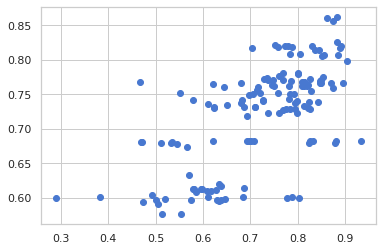

In [847]:
print(rs.kendall(de_cue2[subset].behav_perf, mdf2.fittedvalues))
plt.scatter(de_cue2[subset].behav_perf, mdf2.fittedvalues)

0.021109899894371474


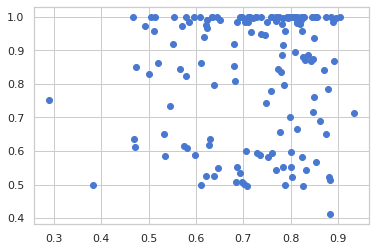

In [848]:
print(rs.kendall(de_cue2[subset].bac, de_cue2[subset].behav_perf))
plt.scatter( de_cue2[subset].behav_perf, de_cue2[subset].bac)

# Decode decision

In [836]:
%%time
target = 'dec'
de_dec = de.loc[(de.target_type==target)].groupby(['encoder_type', 'zones', 'subject', 'session', 'task']).mean().reset_index()
de_dec = de_dec.dropna()

CPU times: user 1.51 s, sys: 11.9 ms, total: 1.52 s
Wall time: 1.52 s


In [768]:
de_dec.head()

encoder_type zones subject        session task  fold       acc       bac  \
0             Z     H      Al  AL_T3g_101218  T3g   2.0  0.608485  0.487451   
4             Z     H      Al  Al_T3g_092718  T3g   2.0  0.483333  0.491667   
8             Z     H      Al  Al_T3g_092818  T3g   2.0  0.566667  0.440000   
12            Z     H      Al  Al_T3g_100218  T3g   2.0  0.573214  0.598214   
16            Z     H      Al  Al_T3g_100318  T3g   2.0  0.514286  0.500000   

        dist  logit_dist  n_units  
0   0.391515    0.020056      1.0  
4   0.516667    0.136448     28.0  
8   0.433333    0.157824     27.0  
12  0.426786    0.091904      6.0  
16  0.485714    0.547783      6.0

In [730]:
def decoder_perf_x_zone(data_table, hue_var, hue_names, metric='bac', hue_name_map=None,  palette=None, legend=True, ax=None):
    
    n_hues = len(hue_names)
    if hue_var == 'encoder_type':
        if palette is None:
            palette = sns.color_palette("husl", n_hues)
            
        if hue_name_map is None:
            hue_name_map = {'neural': r'$V$',
                            'Z0':r'$\widehat{V}_{Z_0}$',
                            'Z': r'$\widehat{V}_Z$', 
                            'Z+C':r'$\widehat{V}_{Z \plus C}$',
                            'ZxC':r'$\widehat{V}_{Z x C}$'}
            
    elif hue_var == 'subject':
        if palette is None:
            palette = sns.color_palette('deep', n_hues)
            
        if hue_name_map is None:
            hue_name_map = [f"$s_{i+1}$" for i in range(n_hues)]
            hue_name_map = dict(zip(hue_names, hue_name_map))
            

    if ax is None:
        f,ax=plt.subplots(figsize=(3,2), dpi=300, constrained_layout=True)
    else:
        f = ax.figure

    sns.lineplot(data=data_table, x='zones', y=metric, hue=hue_var, hue_order=hue_names, palette=palette, markers=False, ax=ax)
    
    ax.get_legend().remove()
    ax.set_xticks([0,8,15,19])
    ax.set_ylim([0.38,1.02])
    ax.axhline(0.5, linestyle='--', color='0.3', zorder=1)

    ax.set_xlabel('Zone', fontsize=fontsize)
    if metric == 'bac':
        ax.set_ylabel('BAC', fontsize=fontsize)
        leg_pos = [1.1, 0.1]

    if legend:
        legend_elements = []
        for ii, k in enumerate(hue_names):
            legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[ii], lw=0, label=hue_name_map[k],
                                                markerfacecolor=palette[ii], markersize=3))

        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                     fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)
    
    return f, ax

### plot decision decoder by zone and encoder type

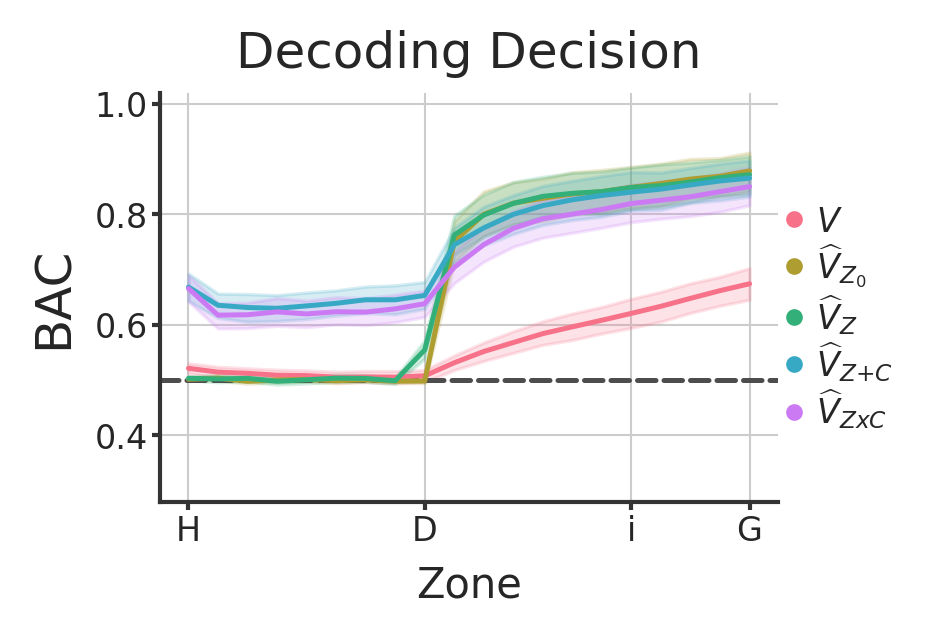

In [804]:
dpi=600
fontsize = 12
fn = "dec_decoder_perf_zone_x_enc.png"

hue_var = 'encoder_type'
hue_names = ['neural', 'Z0', 'Z', 'Z+C', 'ZxC']
f,ax = decoder_perf_x_zone(data_table=de_dec, hue_var=hue_var, hue_names=hue_names)
ax.set_ylabel('BAC', fontsize=fontsize)
ax.set_title('Decoding Decision',fontsize=fontsize)
    
ax.axhline(0.5,linestyle='--', color='0.3', zorder=1)
ax.set_ylim([0.28,1.02])

f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')


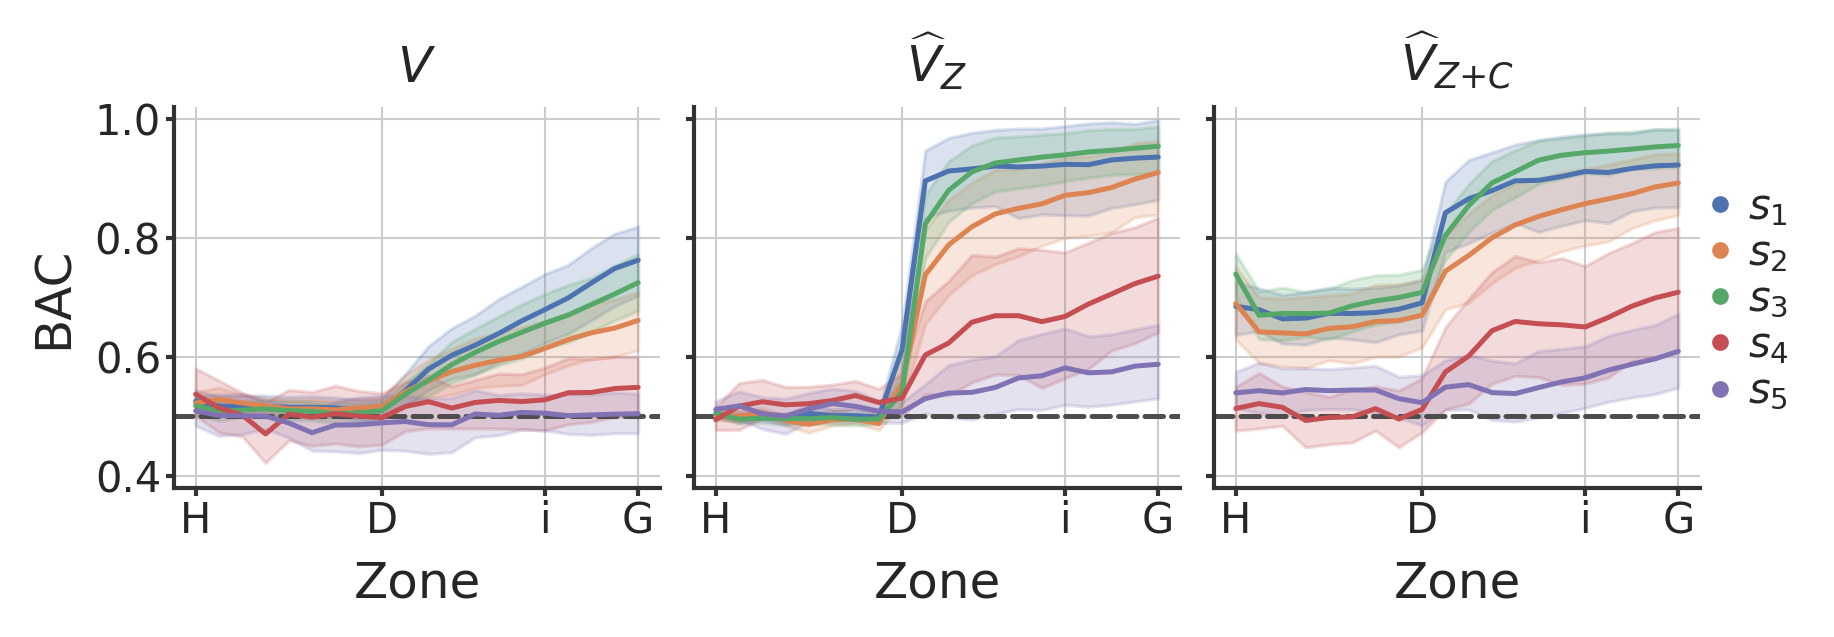

In [732]:
dpi=600
fontsize = 12 
fn = "dec_decoder_perf_zone_x_subj.png"

hue_var = 'subject'
hue_names = subjects

encoders = ['neural', 'Z', 'Z+C']

encoder_name_map = {'neural': r'$V$',
                    'Z0':r'$\widehat{V}_{Z_0}$',
                    'Z': r'$\widehat{V}_Z$', 
                    'Z+C':r'$\widehat{V}_{Z \plus C}$',
                    'ZxC':r'$\widehat{V}_{Z x C}$'}
f,axs=plt.subplots(1,3, figsize=(6,2), dpi=300, constrained_layout=True)
legend = False
for ii, enc in enumerate(encoders):
    if ii == 2:
        legend=True
        
    decoder_perf_x_zone(data_table=de_dec[de_dec.encoder_type==enc], hue_var=hue_var, hue_names=hue_names, legend=legend, ax=axs[ii])

    if ii>0:
        axs[ii].set_ylabel('')
        axs[ii].set_yticklabels('')
        
    axs[ii].set_title(encoder_name_map[enc], fontsize=fontsize)
    
    
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

In [837]:
stem_zones = zones[:9]
branch_zones = zones[9:]

de_dec2 = de_dec.copy()
de_dec2.loc[ de_dec.zones.isin(stem_zones) ,'seg'] = 'stem'
de_dec2.loc[ de_dec.zones.isin(branch_zones) ,'seg'] = 'branch'

de_dec2 = de_dec2.groupby(['encoder_type', 'subject', 'session','task', 'seg'])['bac', 'logit_dist','n_units'].mean().reset_index()

de_dec2.head()

/tmp/ipykernel_9714/1724662600.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  de_dec2 = de_dec2.groupby(['encoder_type', 'subject', 'session','task', 'seg'])['bac', 'logit_dist','n_units'].mean().reset_index()


encoder_type subject        session task     seg       bac  logit_dist  \
0            Z      Al  AL_T3g_101218  T3g  branch  0.501970    1.763696   
1            Z      Al  AL_T3g_101218  T3g    stem  0.504259    0.663553   
2            Z      Al  Al_T3g_092718  T3g  branch  0.992424    0.062669   
3            Z      Al  Al_T3g_092718  T3g    stem  0.492222    1.384374   
4            Z      Al  Al_T3g_092818  T3g  branch  0.952727    1.582786   

   n_units  
0      1.0  
1      1.0  
2     28.0  
3     28.0  
4     27.0

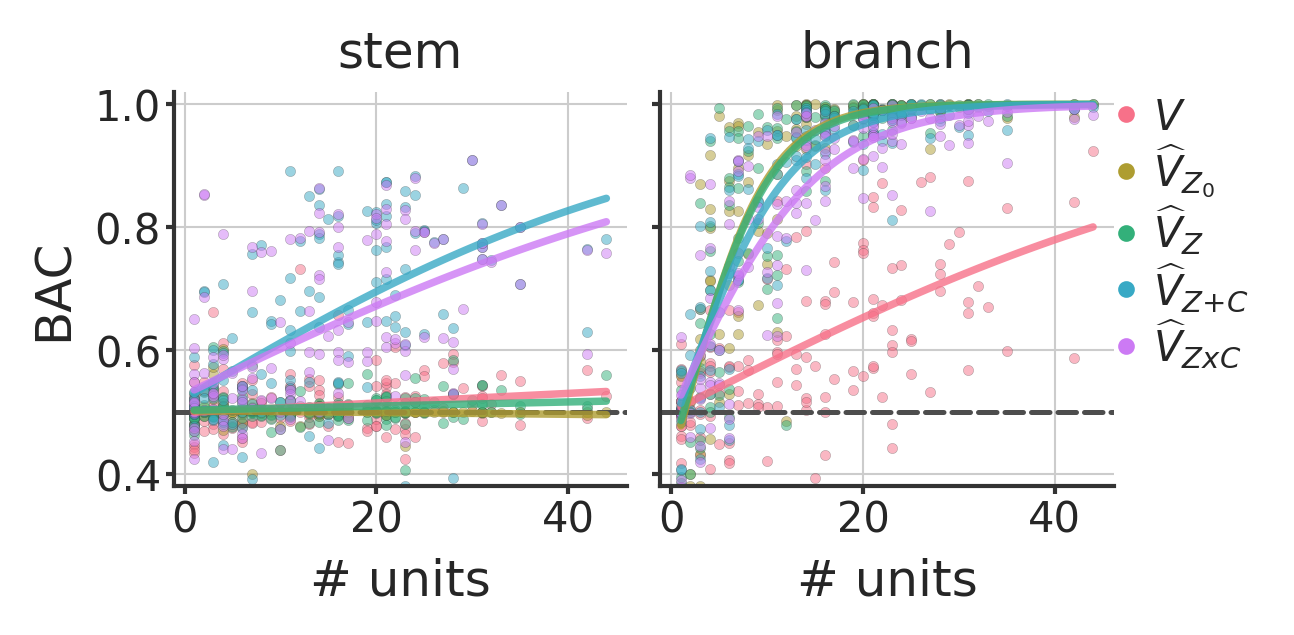

In [817]:
metric = 'bac'

fontsize=12
n_hues = len(encoder_types)
palette = sns.color_palette("husl", n_hues)
segments = ['stem', 'branch']

fn = f"dec_decoder_perf_unit_enc_x_seg.png"

f,axs=plt.subplots(1,2, figsize=(4.2,2), dpi=300, constrained_layout=True)

for ii, seg in enumerate(segments):
    ax = axs[ii]
    for jj, enc in enumerate(encoder_name_map.keys()):
        sns.regplot(x='n_units', y='bac', logistic=True, ci=None, color=palette[jj], 
                    scatter_kws=dict(alpha=0.5, lw=0.1, s=6,edgecolors='0.2'), 
                    line_kws=dict(alpha=0.8),
                    data=de_dec2[ (de_dec2.encoder_type==enc) & (de_cue2.seg==seg)], ax=ax)


    ax.set_ylim([0.38,1.02])
    ax.axhline(0.5, linestyle='--', color='0.3', zorder=1)
    ax.set_xlabel('# units', fontsize=fontsize)
    ax.set_ylabel('BAC', fontsize=fontsize)
    ax.set_title(f"{seg}", fontsize=fontsize)

    leg_pos = [1.15, 0.2]

    if ii==1:
        ax.set_ylabel('', fontsize=fontsize)
        legend_elements = []
        for jj, k in enumerate(encoder_name_map.keys()):
            legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[jj], lw=0, label=encoder_name_map[k],
                                                markerfacecolor=palette[jj], markersize=3))

        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                     fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

        ax.set_yticklabels('')

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)

f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

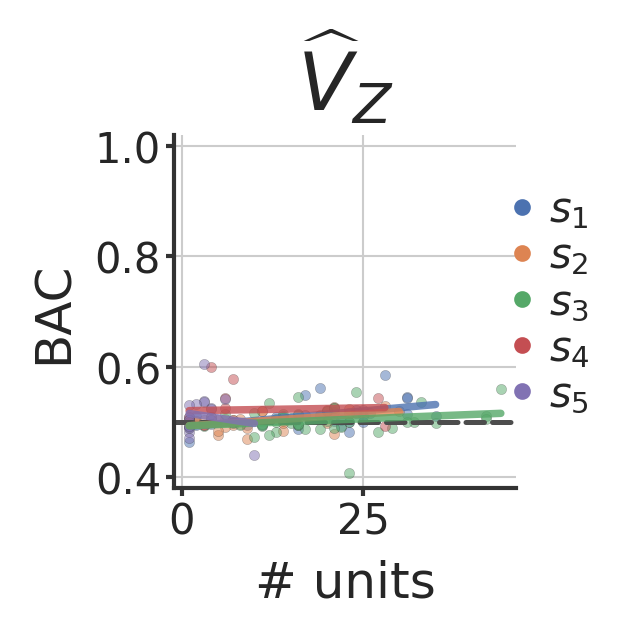

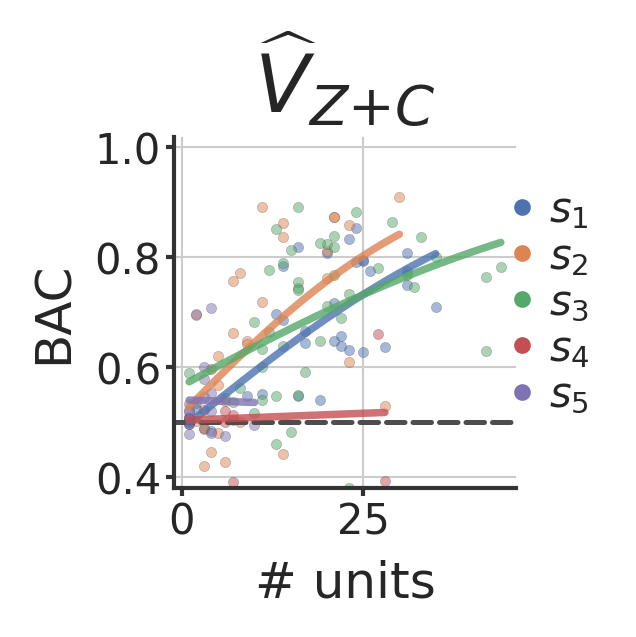

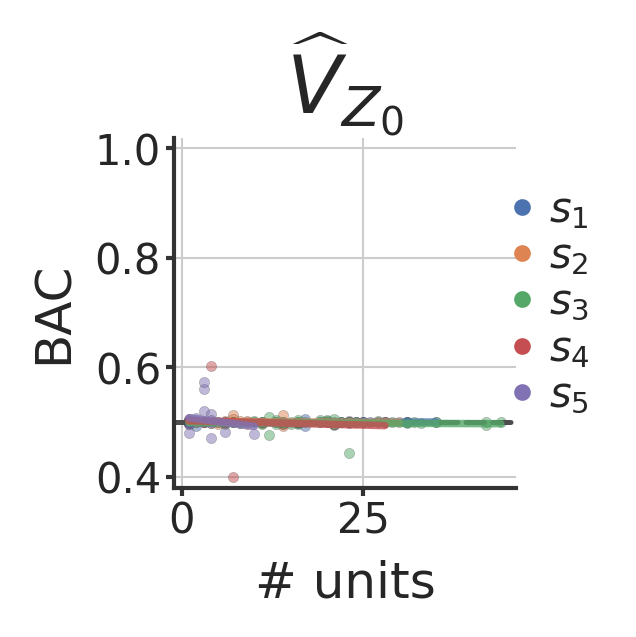

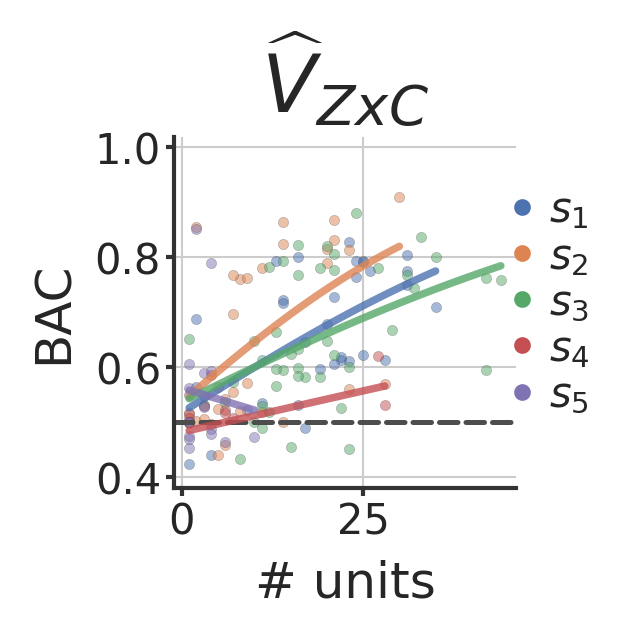

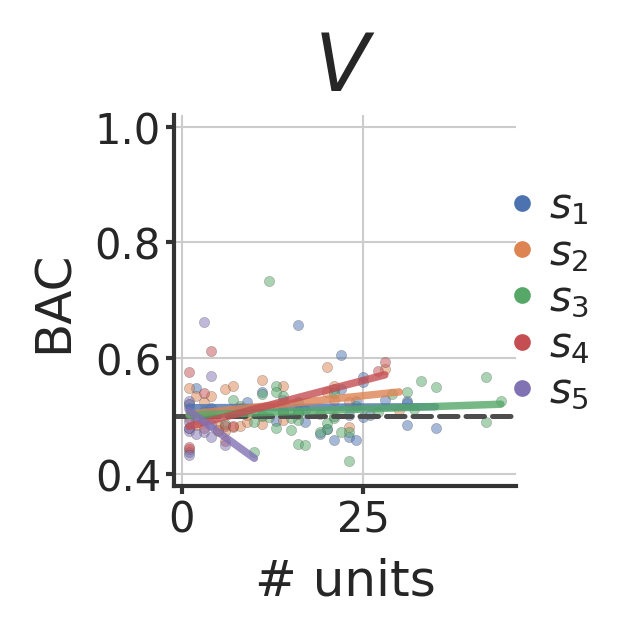

In [809]:
metric = 'bac'
seg = 'stem'

fontsize=12
n_hues = len(subjects)
palette = sns.color_palette('deep', n_hues)

for encoder in encoder_types:

    fn = f"dec_decoder_perf_unit_enc_{encoder}_subj.png"

    f,ax=plt.subplots(figsize=(2,2), dpi=300, constrained_layout=True)

    for ii, ss in enumerate(subjects):
        sns.regplot(x='n_units', y='bac', logistic=True, ci=None, color=palette[ii], scatter_kws=dict(alpha=0.5, lw=0.1, s=6,edgecolors='0.2'), line_kws=dict(alpha=0.8),
               data=de_dec2[ (de_dec2.encoder_type==encoder) & (de_dec2.subject==ss) & (de_dec2.seg==seg)], ax=ax)

    ax.set_ylim([0.38,1.02])
    ax.axhline(0.5, linestyle='--', color='0.3', zorder=1)
    ax.set_xlabel('# units', fontsize=fontsize)
    ax.set_ylabel('BAC', fontsize=fontsize)
    ax.set_title(f"{encoder_name_map[encoder]}")

    leg_pos = [1.1, 0.1]

    legend_elements = []
    subjects2 = [f"$s_{i+1}$" for i in range(n_hues)]
    name_map = dict(zip(subjects,subjects2))
    for ii, k in enumerate(subjects):
        legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[ii], lw=0, label=name_map[k],
                                            markerfacecolor=palette[ii], markersize=3))

    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                 fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)

    f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

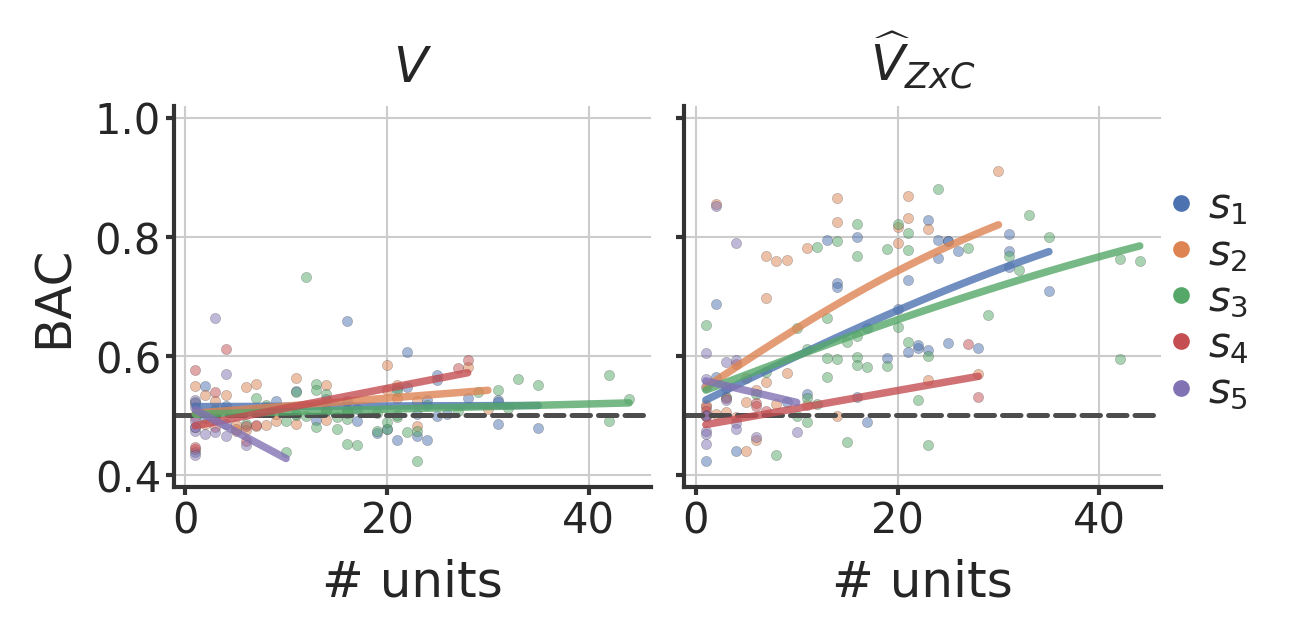

In [838]:
metric = 'bac'
seg = 'stem'

fn = f"dec_decoder_perf_unit_enc_2_subj.png"

f,axs=plt.subplots(1,2, figsize=(4.2,2), dpi=300, constrained_layout=True)

fontsize=12
n_hues = len(subjects)
palette = sns.color_palette('deep', n_hues)

for jj, encoder in enumerate(['neural', 'ZxC']):

    ax=axs[jj]

    for ii, ss in enumerate(subjects):
        sns.regplot(x='n_units', y='bac', logistic=True, ci=None, color=palette[ii], scatter_kws=dict(alpha=0.5, lw=0.1, s=6,edgecolors='0.2'), line_kws=dict(alpha=0.8),
               data=de_dec2[ (de_dec2.encoder_type==encoder) & (de_dec2.subject==ss) & (de_dec2.seg==seg)], ax=ax)

    ax.set_ylim([0.38,1.02])
    ax.axhline(0.5, linestyle='--', color='0.3', zorder=1)
    ax.set_xlabel('# units', fontsize=fontsize)
    ax.set_ylabel('BAC', fontsize=fontsize)
    ax.set_title(f"{encoder_name_map[encoder]}", fontsize=fontsize)

    if jj==1:
        leg_pos = [1.1, 0.1]

        legend_elements = []
        subjects2 = [f"$s_{i+1}$" for i in range(n_hues)]
        name_map = dict(zip(subjects,subjects2))
        for ii, k in enumerate(subjects):
            legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[ii], lw=0, label=name_map[k],
                                                markerfacecolor=palette[ii], markersize=3))

        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                     fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)
        ax.set_yticklabels('')
        ax.set_ylabel('')

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)
    

f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

### stats

In [836]:
vc_formula ={}
vc_formula['task'] = "1+C(task)"
mdf = smf.mixedlm(formula="bac ~ -1 + encoder_type + seg + n_units", groups='subject', vc_formula=vc_formula, data=de_dec2).fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM    Dependent Variable:    bac     
No. Observations:     1380       Method:                REML    
No. Groups:           5          Scale:                 0.0163  
Min. group size:      130        Log-Likelihood:        843.8799
Max. group size:      450        Converged:             Yes     
Mean group size:      276.0                                     
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
encoder_type[Z]       0.676    0.019  34.792 0.000  0.638  0.714
encoder_type[Z+C]     0.737    0.019  37.964 0.000  0.699  0.776
encoder_type[Z0]      0.672    0.019  34.611 0.000  0.634  0.710
encoder_type[ZxC]     0.718    0.019  36.984 0.000  0.680  0.756
encoder_type[neural]  0.563    0.019  28.985 0.000  0.525  0.601
seg[T.stem]          -0.222    0.007 -32.302 0.000 -0.236 -0.209
n_units               0.007    0.000  17.034 0.000  0.006  0.008
task Var              0.001    0.006                            
================================================================

"""

## relate to behavior

In [837]:
de_dec2['behav_perf'] = b_table.set_index('session').pct_correct.loc[de_dec2.session].values
de_dec2['bac_hat'] = mdf.fittedvalues

print(rs.get_r2(de_dec2.bac.values, de_dec2.bac_hat.values))
de_dec2.head()

[0.59886829]


encoder_type subject        session task     seg       bac  logit_dist  \
0            Z      Al  AL_T3g_101218  T3g  branch  0.501970    1.763696   
1            Z      Al  AL_T3g_101218  T3g    stem  0.504259    0.663553   
2            Z      Al  Al_T3g_092718  T3g  branch  0.992424    0.062669   
3            Z      Al  Al_T3g_092718  T3g    stem  0.492222    1.384374   
4            Z      Al  Al_T3g_092818  T3g  branch  0.952727    1.582786   

   n_units  behav_perf   bac_hat  
0      1.0    0.684685  0.641092  
1      1.0    0.684685  0.418726  
2     28.0    0.552632  0.830640  
3     28.0    0.552632  0.608274  
4     27.0    0.514286  0.823620

In [839]:
encoder = 'Z+C'
seg = 'stem'

subset = (de_dec2.encoder_type==encoder) & (de_dec2.seg==seg)
vc_formula ={}
vc_formula['task'] = "1+C(task)"
mdf2 = smf.mixedlm(formula="behav_perf ~ bac_hat", groups='subject', vc_formula=vc_formula, data=de_dec2[subset]).fit()
mdf2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: behav_perf
No. Observations: 138     Method:             REML      
No. Groups:       5       Scale:              0.0087    
Min. group size:  13      Log-Likelihood:     115.5676  
Max. group size:  45      Converged:          Yes       
Mean group size:  27.6                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.821    0.099  8.326 0.000  0.628  1.015
bac_hat       -0.161    0.135 -1.195 0.232 -0.426  0.103
task Var       0.015    0.092                           
========================================================

"""

0.42762961223210794


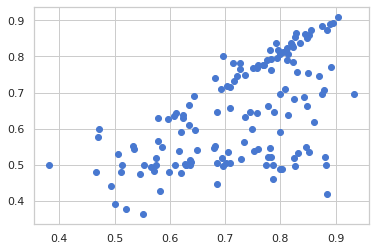

In [849]:
print(rs.kendall(de_dec2[subset].bac, de_dec2[subset].behav_perf))
plt.scatter( de_dec2[subset].behav_perf, de_dec2[subset].bac)

In [ ]:
print(rs.kendall(de_dec2[subset].bac, de_dec2[subset].behav_perf))
plt.scatter( de_dec2[subset].behav_perf, de_dec2[subset].bac)

## decision decoder additional details

In [733]:
ei = reload(ei)
info = ei.SummaryInfo()

In [839]:
%%time
overwrite=False
decision_decoder = info.get_zone_decoder_2_subj_behav(overwrite)

CPU times: user 529 ms, sys: 0 ns, total: 529 ms
Wall time: 528 ms


In [840]:
print(decision_decoder.shape)
decision_decoder.head()

(27900, 12)


encoder_type target_type zones   seg       acc  cue_bias  subj_perf  \
0            Z         cue     H  stem  0.473684  0.473684   0.736842   
1            Z         cue   a_0  stem  0.368421  0.368421   0.736842   
2            Z         cue   a_1  stem  0.438596  0.438596   0.736842   
3            Z         cue   a_2  stem  0.473684  0.473684   0.736842   
4            Z         cue   a_3  stem  0.438596  0.438596   0.736842   

   subj_perf_match subject        session task  n_units  
0         0.350877      Li  Li_T3g_052818  T3g        2  
1         0.263158      Li  Li_T3g_052818  T3g        2  
2         0.315789      Li  Li_T3g_052818  T3g        2  
3         0.350877      Li  Li_T3g_052818  T3g        2  
4         0.333333      Li  Li_T3g_052818  T3g        2

<AxesSubplot:xlabel='zones', ylabel='cue_bias'>

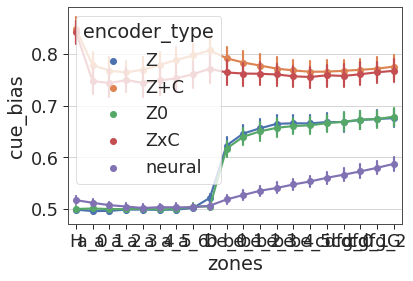

In [841]:
sns.pointplot(data=decision_decoder, x='zones', y='cue_bias', hue='encoder_type')

In [842]:
encoder_types = decision_decoder.encoder_type.unique()
zones = decision_decoder.zones.unique()
subjects = info.subjects[:5]
cue = ['L', 'R']

In [843]:


de_dec2 = decision_decoder.groupby(['session', 'subject', 'task', 'encoder_type', 'seg', 'target_type'])[['acc', 'cue_bias', 'subj_perf', 'subj_perf_match', 'n_units', 'subject', 'task']].mean().reset_index()

de_dec2['decoder_v_subject'] = np.log(de_dec2['cue_bias']/de_dec2['subj_perf'])
de_dec2['encoder_type'] = de_dec2['encoder_type'].astype(pd.api.types.CategoricalDtype(['neural', 'Z0', 'Z', 'Z+C', 'ZxC']))
de_dec2['seg'] = de_dec2['seg'].astype(pd.api.types.CategoricalDtype(['stem','branch']))

In [844]:
print(de_dec2.shape)
de_dec2.head()

(2790, 12)


session subject task encoder_type     seg target_type       acc  \
0  AL_T3g_101218      Al  T3g            Z  branch         cue  0.540309   
1  AL_T3g_101218      Al  T3g            Z  branch         dec  0.389365   
2  AL_T3g_101218      Al  T3g            Z    stem         cue  0.534591   
3  AL_T3g_101218      Al  T3g            Z    stem         dec  0.417191   
4  AL_T3g_101218      Al  T3g          Z+C  branch         cue  0.462264   

   cue_bias  subj_perf  subj_perf_match  n_units  decoder_v_subject  
0  0.540309   0.707547         0.304460      1.0          -0.269664  
1  0.530875   0.707547         0.313894      1.0          -0.287278  
2  0.534591   0.707547         0.319706      1.0          -0.280302  
3  0.529350   0.707547         0.327044      1.0          -0.290154  
4  0.462264   0.707547         0.405660      1.0          -0.425668

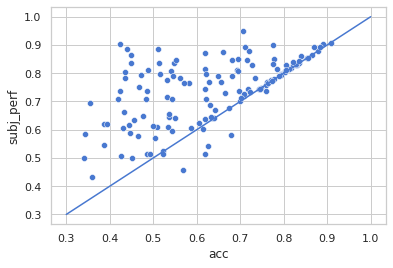

In [64]:
sns.scatterplot(data=de_dec2[(de_dec2.seg=='stem') & (de_dec2.encoder_type=='Z+C')], x='acc', y='subj_perf')
plt.plot([0.3,1],[0.3,1])

<AxesSubplot:xlabel='decoder_v_subject', ylabel='encoder_type'>

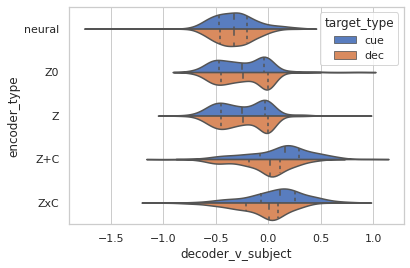

In [99]:
sns.violinplot(data=de_dec2, y='encoder_type', x = 'decoder_v_subject', hue='target_type', split=True, inner='quartile')

<AxesSubplot:xlabel='subj_perf', ylabel='cue_bias'>

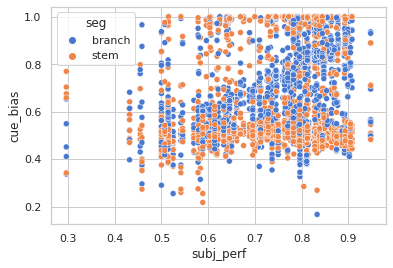

In [91]:
sns.scatterplot(x='subj_perf', y='cue_bias', hue='seg',data=de_dec2)

In [65]:
data=de_dec2[(de_dec2.seg=='stem') & (de_dec2.encoder_type=='ZxC')]

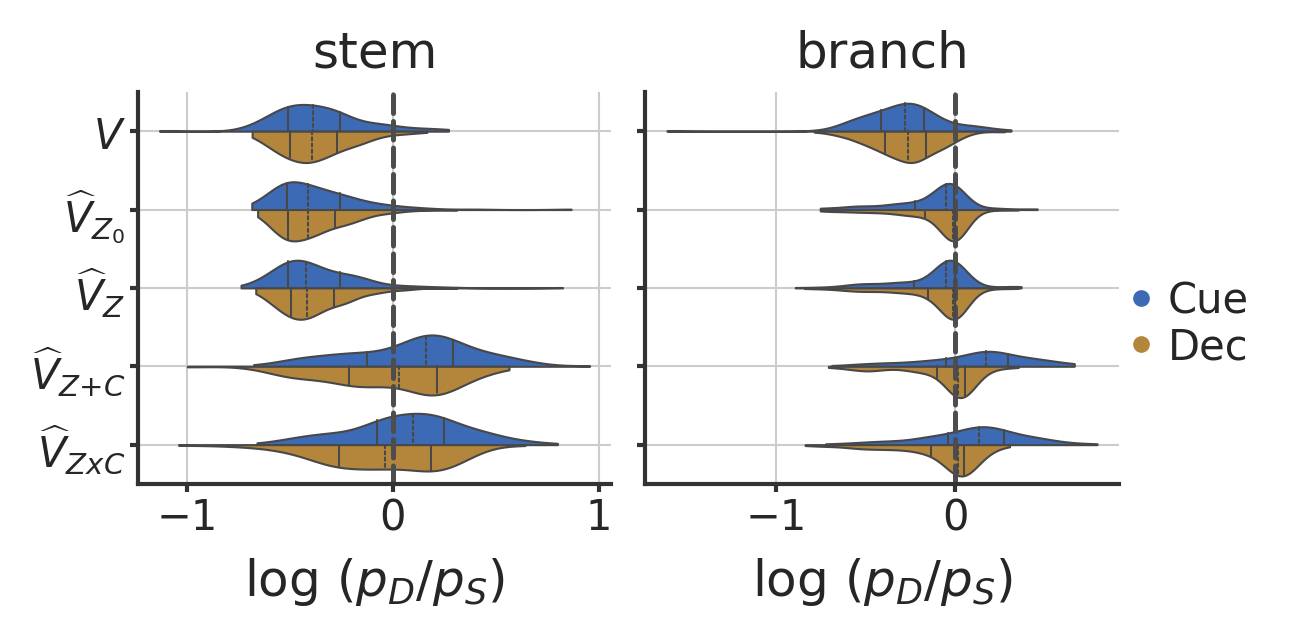

In [845]:
metric = 'decoder_v_subject'
fontsize = 12
targets = ['cue', 'dec']
target_names = ['Cue', 'Dec']
segments = ['stem', 'branch']

palette = ['#3C6AB4', '#B4863C']
fn = f"decoder_v_subject_perf_by_seg_encoder.png"
dpi=600

f,axs=plt.subplots(1,2, figsize=(4.2,2), dpi=300, constrained_layout=True)

for ii, seg in enumerate(segments):
    ax = axs[ii]
    sns.violinplot(data=de_dec2[de_dec2.seg==seg], y='encoder_type', x = 'decoder_v_subject', hue='target_type', 
                   split=True, palette=palette, inner='quartile', linewidth=0.5, saturation=1, cut=0, ax=ax)
    ax.get_legend().remove()


    ax.axvline(0, linestyle='--', color='0.3', zorder=1)
    ax.set_xlabel(f'log $ (p_D/p_S) $', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
    ax.set_title(f"{seg}", fontsize=fontsize)

    leg_pos = [1.15, 0.2]

    if ii==1:
        ax.set_ylabel('', fontsize=fontsize)
        ax.set_yticklabels('')
        legend_elements = []
        for jj, k in enumerate(target_names):
            legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[jj], lw=0, label=k,
                                                markerfacecolor=palette[jj], markersize=3))

        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                     fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    if ii==0:
        new_labels = {'neural': r'$V$',
        'Z0':r'$\widehat{V}_{Z_0}$',
        'Z': r'$\widehat{V}_Z$', 
        'Z+C':r'$\widehat{V}_{Z \plus C}$',
        'ZxC':r'$\widehat{V}_{Z x C}$'}
    
        ax.set_yticklabels(new_labels.values())
        
    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)

f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

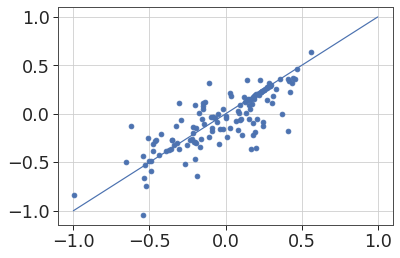

In [853]:
seg='stem'
encoder1 = 'Z+C'
encoder2 = 'ZxC'
target='dec'

x = de_dec2.loc[(de_dec2.seg==seg)&(de_dec2.encoder_type==encoder1)&(de_dec2.target_type==target), 'decoder_v_subject']
y = de_dec2.loc[(de_dec2.seg==seg)&(de_dec2.encoder_type==encoder2)&(de_dec2.target_type==target), 'decoder_v_subject']

plt.scatter(x,y)
plt.plot([-1,1],[-1,1])

In [862]:
scipy.stats.ttest_1samp(x.values-y.values,0)

Ttest_1sampResult(statistic=2.2279377607862325e+00, pvalue=0.02751518324241493)

In [861]:
x.values-y.values

array([ 4.29185208e-03, -2.08544752e-01, -4.52565916e-02, -6.08001990e-02,
        9.29461125e-02, -3.49278811e-02, -4.31877208e-01,  1.03011718e-01,
        1.23162285e-01, -1.51518050e-02, -1.46344075e-02, -9.61076480e-04,
        4.98367389e-01,  8.85533973e-02, -1.65079750e-01, -8.63846142e-02,
       -1.96051750e-01,  2.53195896e-01, -2.57334916e-01,  4.00323709e-01,
        1.22624172e-03, -1.77896771e-01,  1.02531088e-01, -1.07744670e-01,
        1.30587079e-01, -2.26527649e-01, -1.89299952e-01, -5.66573754e-03,
       -1.51747980e-02, -7.92292365e-02,  2.99216799e-02,  3.70881016e-01,
        4.44517626e-02,  1.43884917e-03,  1.22282092e-01, -7.93654960e-03,
       -9.29013693e-02,  7.80643111e-02,  3.74302024e-02,  1.23450662e-01,
        8.04024432e-03,  7.40272586e-02, -4.96950277e-01, -3.40726966e-02,
       -1.07144637e-01,  6.97094606e-02,  3.84833308e-01,  3.30741562e-01,
        4.53082752e-01,  2.62135980e-01,  2.67800702e-01,  2.00222767e-01,
        0.00000000e+00,  

## Zone Decoder

In [135]:
de_zone = de[de.target_type=='zones'].groupby(['encoder_type', 'subject', 'session', 'task', 'zones'], observed=True, dropna=True).mean().reset_index()

In [757]:
def decoder_perf_x_zone(data_table, hue_var, metric='bac', hue_names=None, hue_name_map=None,  palette=None, legend=True, ax=None):
    
    fontsize=10
    if hue_var == 'encoder_type':
        if hue_names is None:
             hue_names =['neural', 'Z0', 'Z', 'Z+C', 'ZxC']
            
        n_hues = len(hue_names)
        if palette is None:
            palette = sns.color_palette("husl", n_hues)
            

        if hue_name_map is None:
            hue_name_map = {'neural': r'$V$',
                            'Z0':r'$\widehat{V}_{Z_0}$',
                            'Z': r'$\widehat{V}_Z$', 
                            'Z+C':r'$\widehat{V}_{Z \plus C}$',
                            'ZxC':r'$\widehat{V}_{Z x C}$'}
            
    elif hue_var == 'subject':
        
        if hue_names is None:
             hue_names =info.subjects[:5]
            
        n_hues = len(hue_names)
        if palette is None:
            palette = sns.color_palette('deep', n_hues)
            
        if hue_name_map is None:
            hue_name_map = [f"$s_{i+1}$" for i in range(n_hues)]
            hue_name_map = dict(zip(hue_names, hue_name_map))
            

    if ax is None:
        f,ax=plt.subplots(figsize=(3,2), dpi=300, constrained_layout=True)
    else:
        f = ax.figure

    sns.lineplot(data=data_table, x='zones', y=metric, hue=hue_var, hue_order=hue_names, palette=palette, markers=False, ax=ax)
    
    ax.get_legend().remove()
    ax.set_xticks([0,8,15,19])

    ax.set_xlabel('Zone', fontsize=fontsize)
    
    leg_pos = [1.1, 0.1]
    if legend:
        legend_elements = []
        for ii, k in enumerate(hue_names):
            legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', color=palette[ii], lw=0, label=hue_name_map[k],
                                                markerfacecolor=palette[ii], markersize=3))

        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=leg_pos, frameon=False,
                     fontsize=fontsize-2, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)

    sns.despine(ax=ax)
    ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

    for sp in ['bottom', 'left']:
        ax.spines[sp].set_linewidth(1)
        ax.spines[sp].set_color('0.2')

    ax.grid(linewidth=0.5)
    
    return f, ax

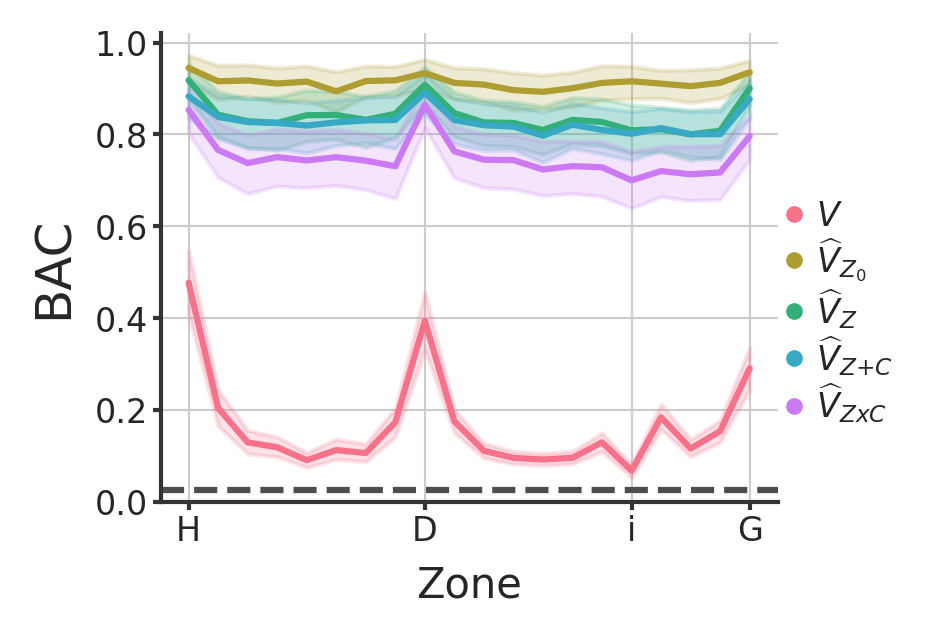

In [185]:
metric = 'bac'
hue_var = 'encoder_type'

f, ax = decoder_perf_x_zone(data_table=de_zone, hue_var=hue_var,  metric=metric)

if metric =='dist':
    ax.set_ylabel('Distance Error (mm)')
    
if metric =='bac':
    ax.set_ylabel('BAC')
    ax.axhline(1/39,linestyle='--', color='0.3', zorder=1)
    ax.set_ylim([0,1.02])
    
fn = f"zone_decoder_{metric}_x_{hue_var}"
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

Text(0, 0.5, 'Distance Error (mm)')

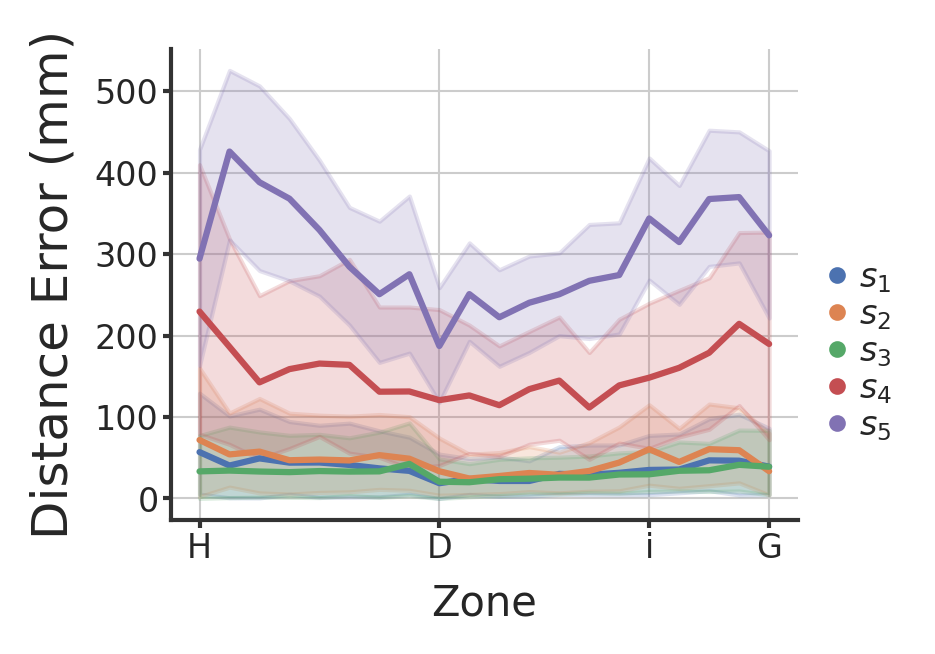

In [151]:
metric = 'dist'
f, ax = decoder_perf_x_zone(data_table=de_zone[de_zone.encoder_type=='Z+C'], hue_var='subject', hue_names =info.subjects[:5],  metric=metric)
ax.set_ylabel('Distance Error (mm)')

## Decode Goal

In [162]:
de_goal = de[de.target_type=='first_goal'].groupby(['encoder_type', 'subject', 'session', 'task', 'zones'], observed=True, dropna=True).mean().reset_index()

In [163]:
de_goal.head()

encoder_type subject        session task zones  fold       acc       bac  \
0            Z      Al  AL_T3g_101218  T3g     H   2.0  0.249444  0.293651   
1            Z      Al  AL_T3g_101218  T3g   a_0   2.0  0.352424  0.349206   
2            Z      Al  AL_T3g_101218  T3g   a_1   2.0  0.335000  0.333333   
3            Z      Al  AL_T3g_101218  T3g   a_2   2.0  0.335000  0.333333   
4            Z      Al  AL_T3g_101218  T3g   a_3   2.0  0.335000  0.333333   

       dist  logit_dist  n_units  
0  1.132828    0.036989      1.0  
1  1.215859    0.192014      1.0  
2  1.260707    0.387518      1.0  
3  1.270707    0.539177      1.0  
4  1.281818    0.748253      1.0

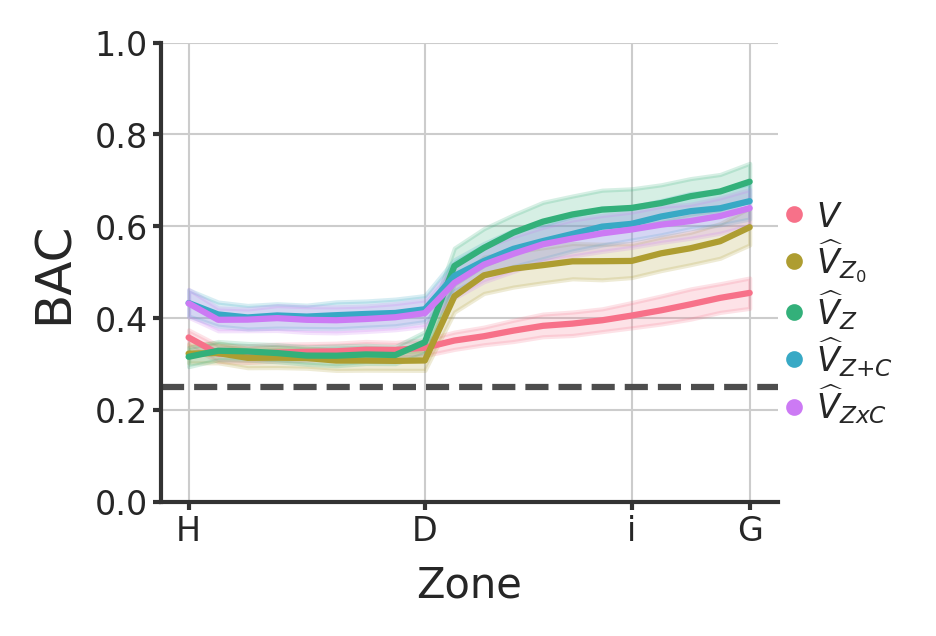

In [181]:
metric = 'bac'
hue_var = 'encoder_type'

f, ax = decoder_perf_x_zone(data_table=de_goal, hue_var=hue_var,  metric=metric)

if metric =='dist':
    ax.set_ylabel('Distance Error')
    ax.axhline(1.25,linestyle='--', color='0.3', zorder=1)
    ax.set_ylim([0,2])
if metric =='bac':
    ax.set_ylabel('BAC')
    ax.axhline(0.25,linestyle='--', color='0.3', zorder=1)
    ax.set_ylim([0,1])

fn = f"goal_decoder_{metric}_x_{hue_var}"
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

In [177]:
de_rwgoal = de[de.target_type=='rw_goal'].groupby(['encoder_type', 'subject', 'session', 'task', 'zones'], observed=True, dropna=True).mean().reset_index()

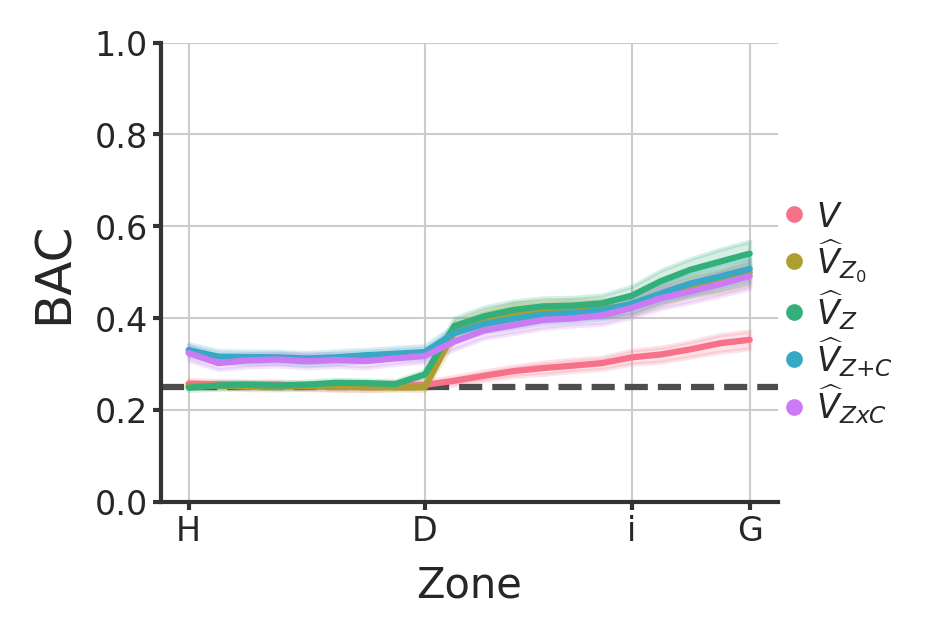

In [184]:
metric = 'bac'
hue_var = 'encoder_type'

f, ax = decoder_perf_x_zone(data_table=de_rwgoal, hue_var=hue_var,  metric=metric)

if metric =='dist':
    ax.set_ylabel('Distance Error')
    ax.axhline(1.25,linestyle='--', color='0.3', zorder=1)
    ax.set_ylim([0,2])
if metric =='bac':
    ax.set_ylabel('BAC')
    ax.axhline(0.25,linestyle='--', color='0.3', zorder=1)
    ax.set_ylim([0,1])

fn = f"rwgoal_decoder_{metric}_x_{hue_var}"
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')

# remapping figures

In [341]:
%%time
pf = reload(pf)
f1 = pf.Fig1()

CPU times: user 842 ms, sys: 7.93 ms, total: 850 ms
Wall time: 857 ms


<Figure size 6200x3700 with 0 Axes>

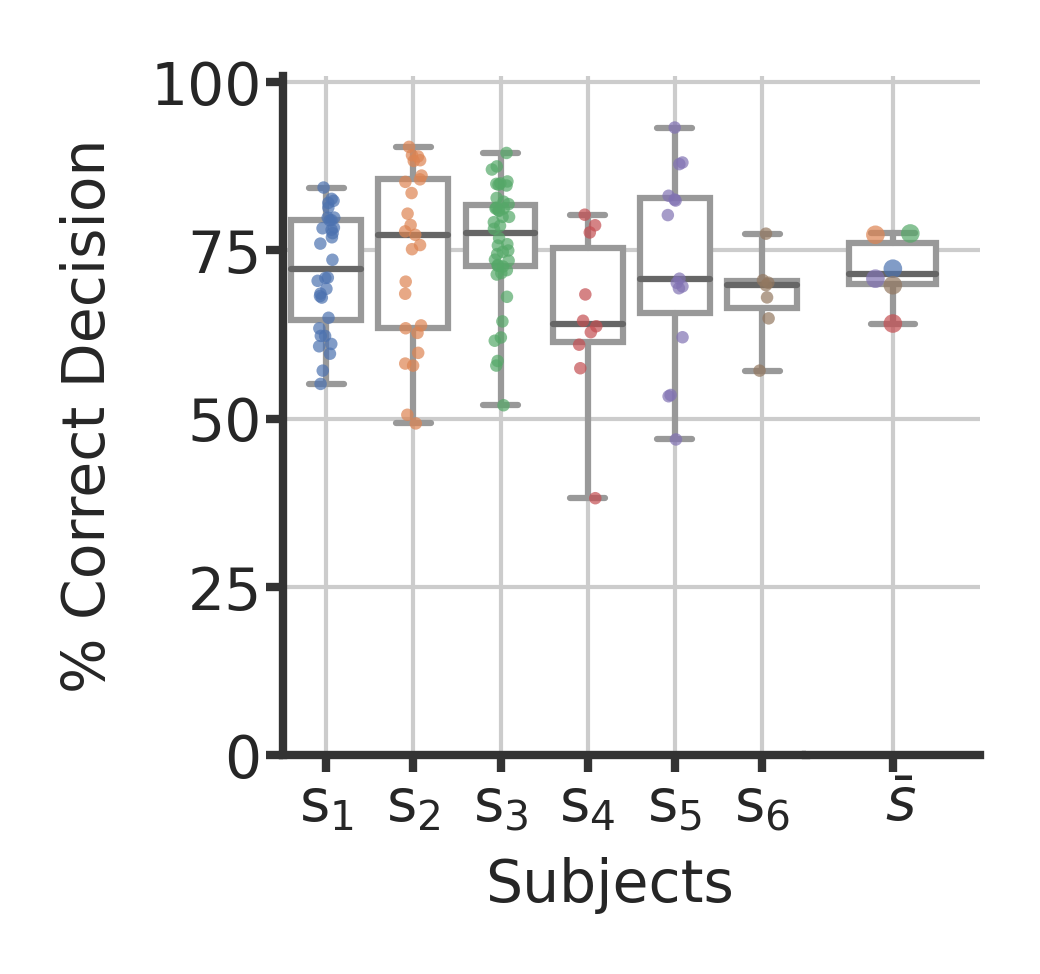

In [342]:
f = f1.panel_d()

In [343]:
fn = "behav_perf.png"
f.figure.savefig(fig_path/fn, dpi=600, bbox_inches='tight')

In [344]:
%%time
pf = reload(pf)
f2 = pf.Fig2()

CPU times: user 1min 43s, sys: 1.86 s, total: 1min 45s
Wall time: 16.7 s


<Figure size 5000x4000 with 0 Axes>

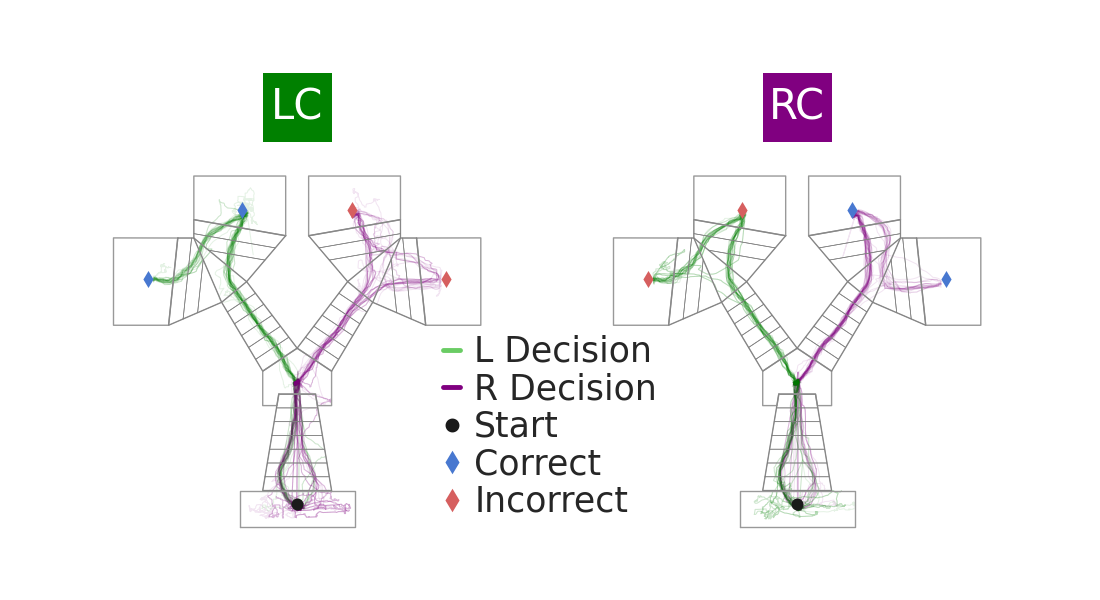

In [204]:
ax = f2.panel_a()

In [219]:
fn = "Layout_and_trajctories.png"
ax[0].figure.savefig(fig_path/fn, dpi=600, bbox_inches='tight')

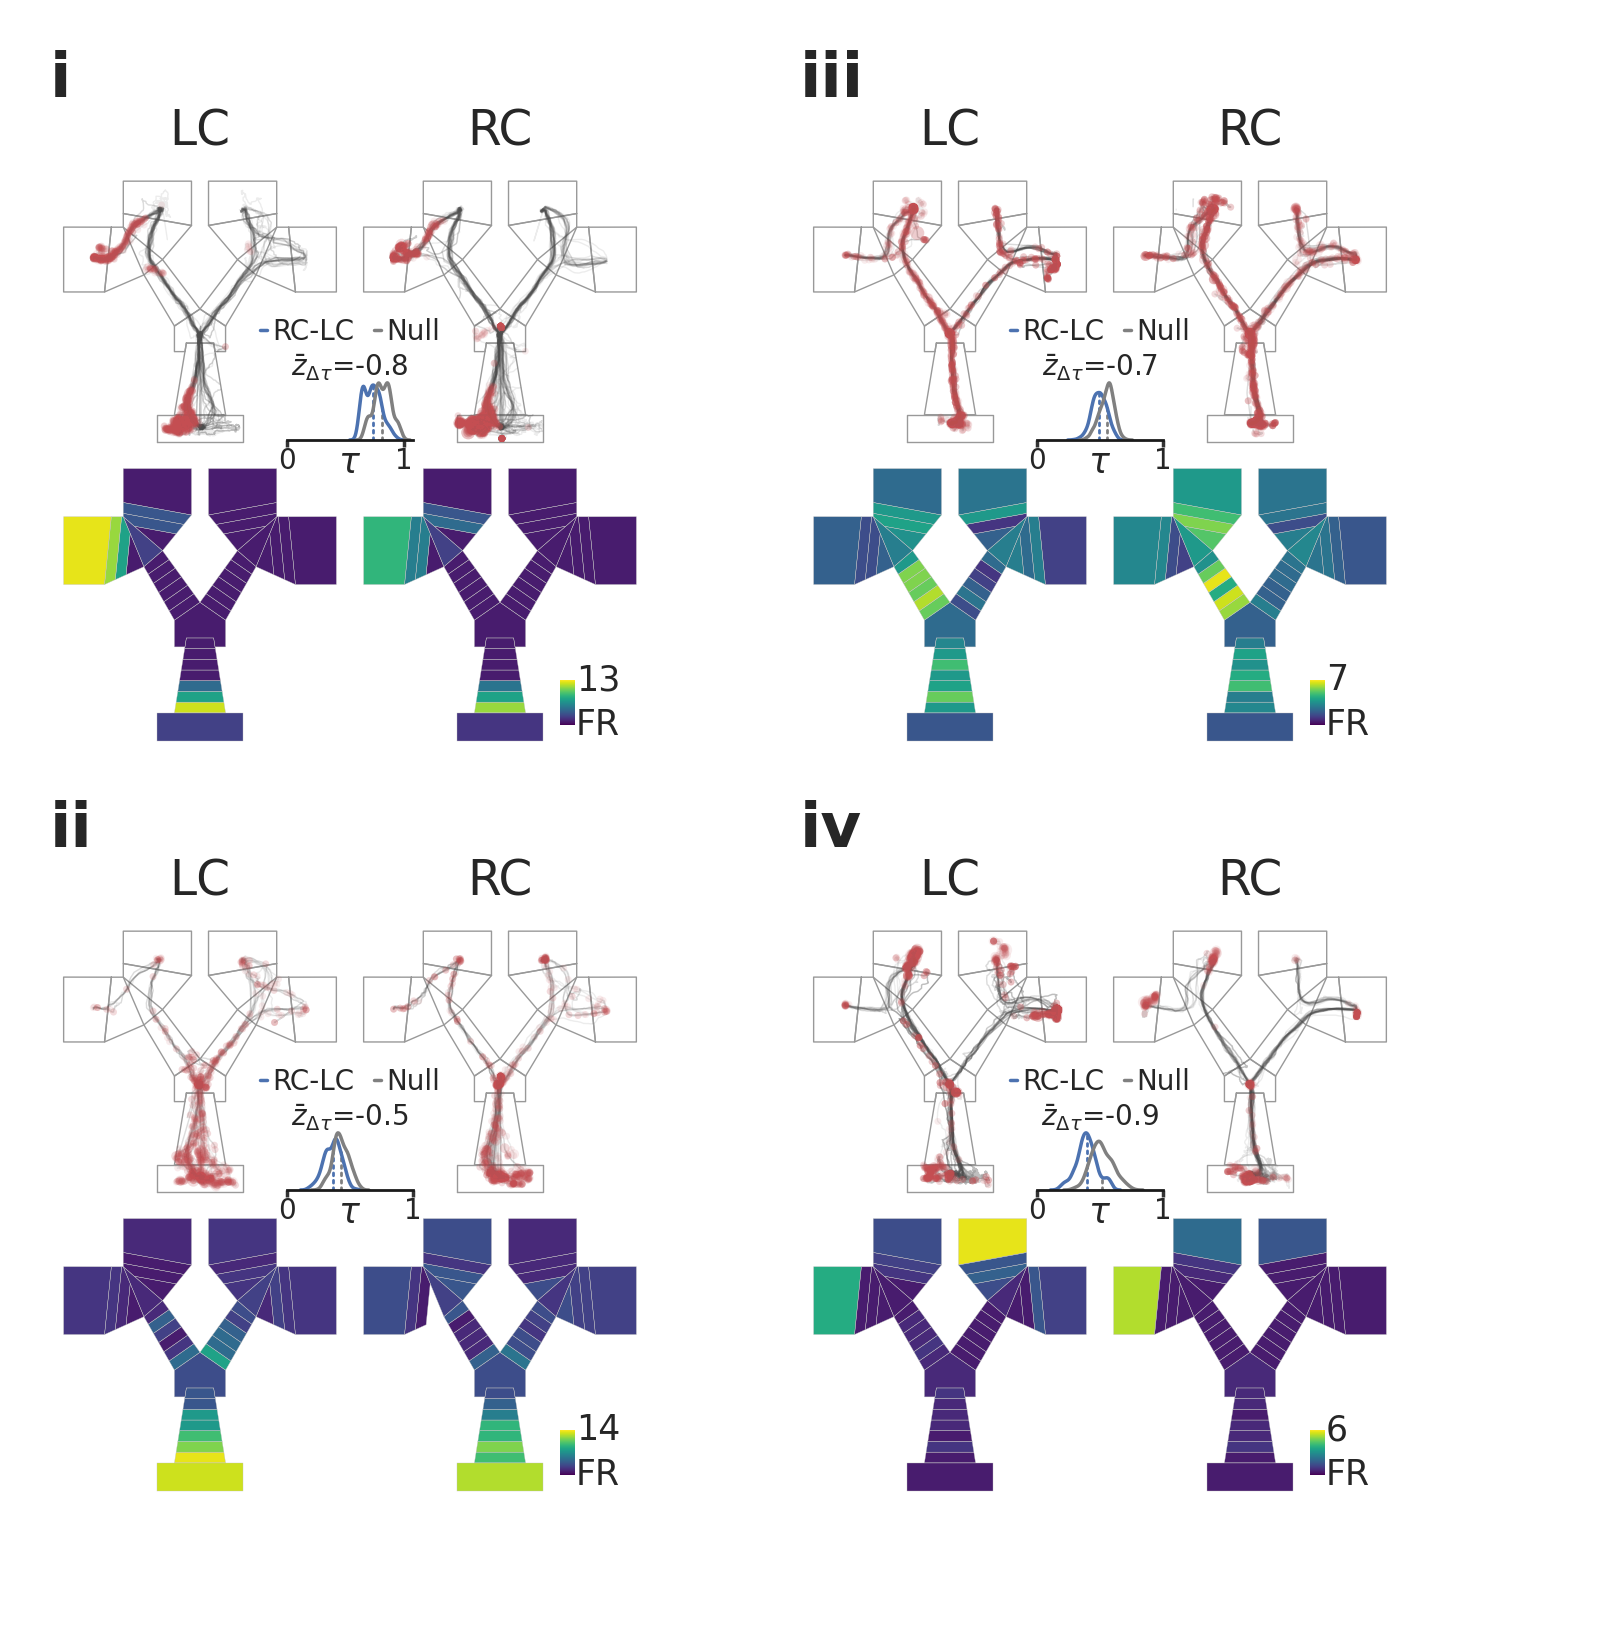

In [345]:
f = f2.panel_b()

In [220]:
fn = "Example_Remapping.png"
f.savefig(fig_path/fn, dpi=600, bbox_inches='tight')

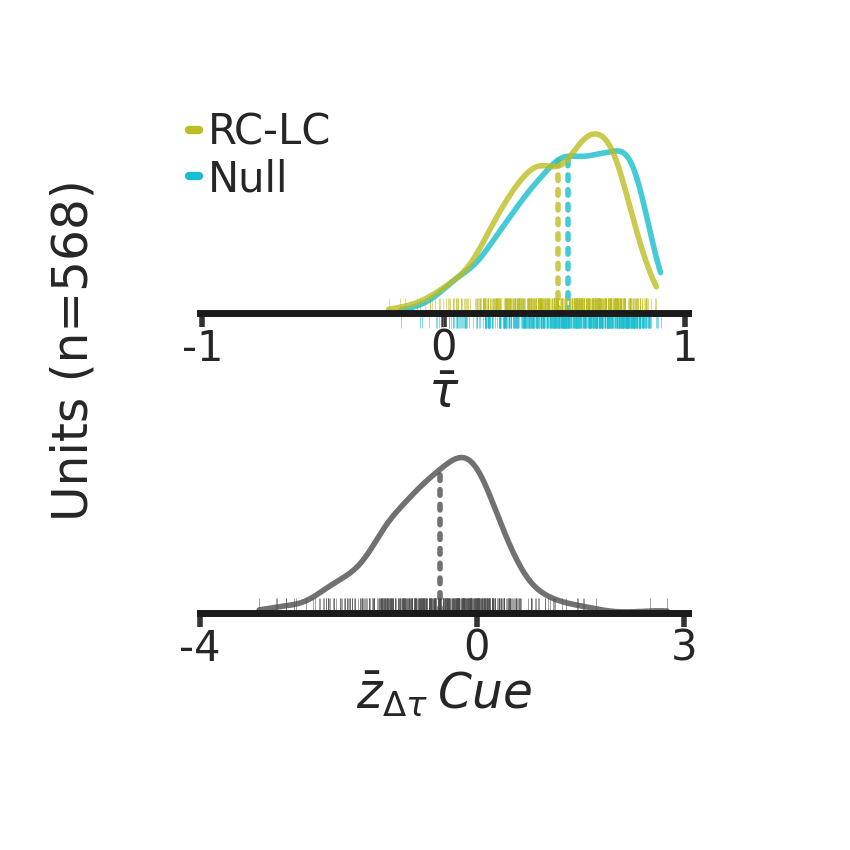

In [347]:
f = f2.panel_c()
fn = "units_remapping.png"
f.savefig(fig_path/fn, dpi=600, bbox_inches='tight')

In [353]:
%%time
pf = reload(pf)
f2 = pf.Fig2()

CPU times: user 1min 35s, sys: 1.81 s, total: 1min 37s
Wall time: 15.9 s


<Figure size 5000x4000 with 0 Axes>

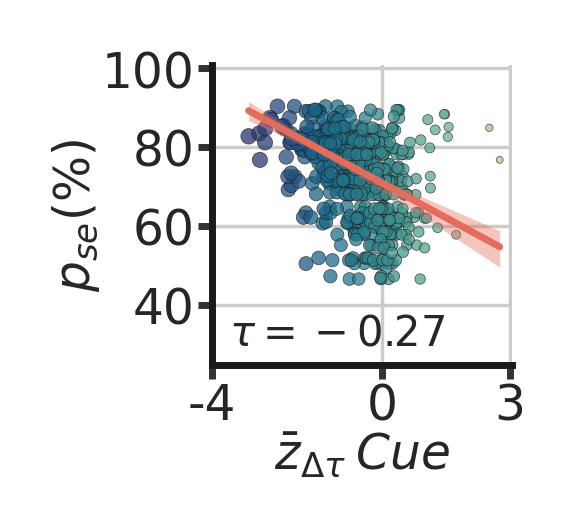

In [362]:
f = f2.panel_d()
fn = "behav_v_cue_remap_units.png"
ax = f.fig.get_children()[1]
ax.set_ylim([0.25,1.01])
ax.set_yticks([.40, .60, .80, 1])
ax.set_yticklabels([40, 60, 80, 100])

f.savefig(fig_path/fn, dpi=600, bbox_inches='tight')

<Axes:xlabel='$\\bar{z}_{\\Delta \\tau} \\: Cue$', ylabel='$p_{se} (\\%)$'>

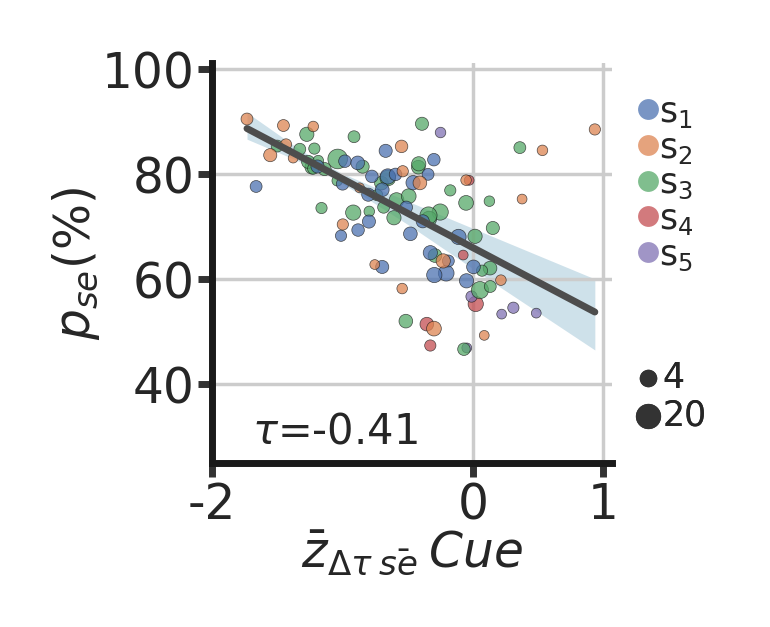

In [363]:
f = f2.panel_e()
fn = "behav_v_cue_remap_se.png"
f.savefig(fig_path/fn, dpi=600, bbox_inches='tight')

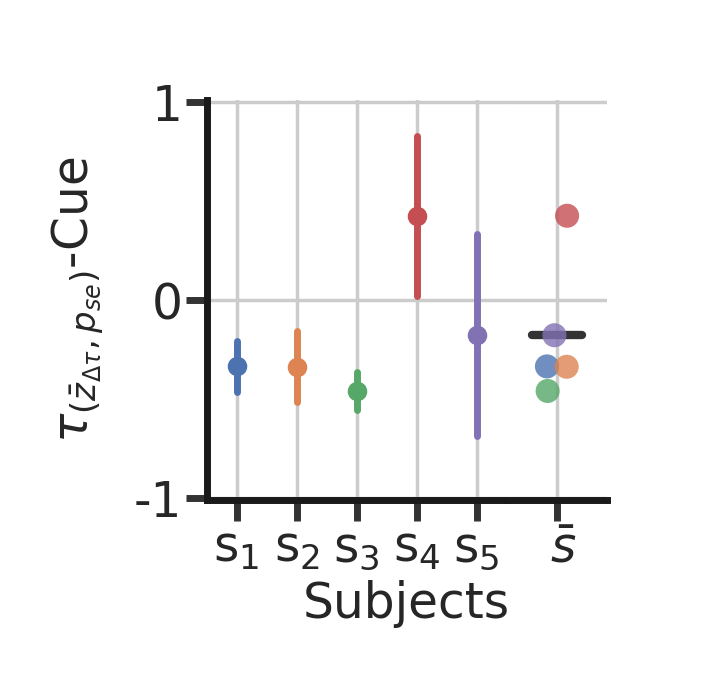

In [367]:
f = f2.panel_f()
fn = "behav_v_cue_remap_subj.png"
f.savefig(fig_path/fn, dpi=600, bbox_inches='tight')

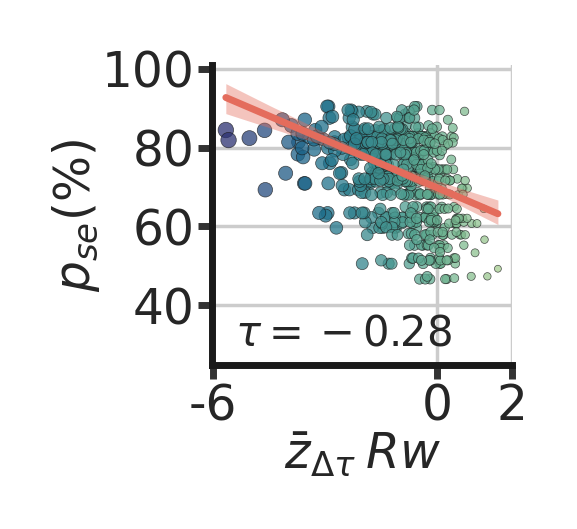

In [364]:
f = f2.panel_g()
fn = "behav_v_rw_remap_units.png"
ax = f.fig.get_children()[1]
ax.set_ylim([0.25,1.01])
ax.set_yticks([.40, .60, .80, 1])
ax.set_yticklabels([40, 60, 80, 100])
f.savefig(fig_path/fn, dpi=600, bbox_inches='tight')

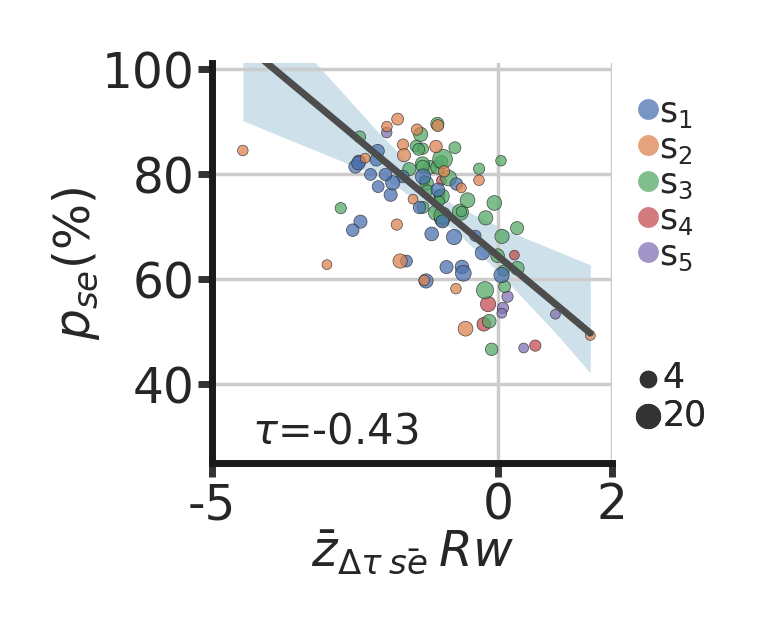

In [365]:
f = f2.panel_h()
fn = "behav_v_rw_remap_se.png"
f.savefig(fig_path/fn, dpi=600, bbox_inches='tight')

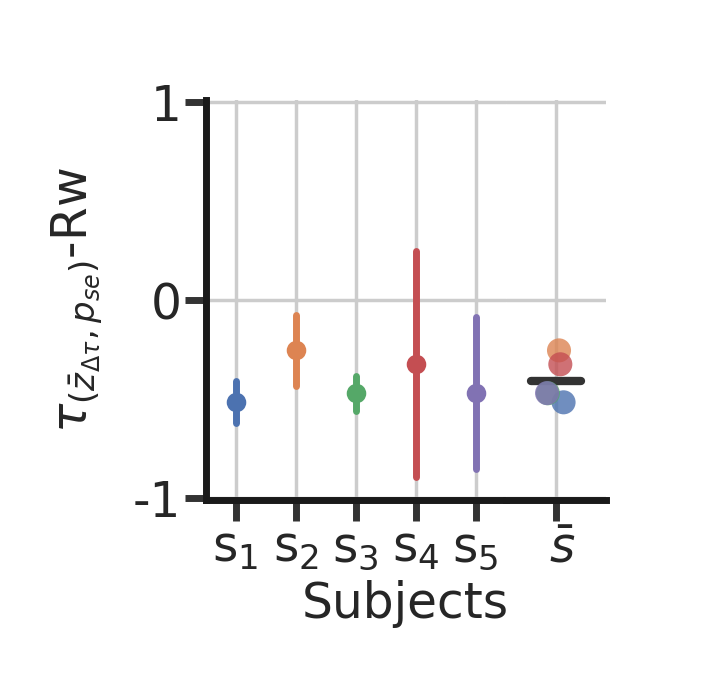

In [366]:
f = f2.panel_i()
fn = "behav_v_rw_remap_subj.png"
f.savefig(fig_path/fn, dpi=600, bbox_inches='tight')

# Individual session

In [1180]:
tmf = reload(tmf)
tmz = tmf.TreeMazeZones()

In [1181]:
subject = 'Li'
session = 'Li_T3g_062018'
session_info = ei.SubjectSessionInfo('Li', session)

In [1227]:
max_lag = 50
cue_type= 'none'
rw_type = 'fixed'
dir_type ='none'
trial_seg='in'

ze = tmf.ZoneEncoder(session_info)
ze.update_features(**dict(max_lag=max_lag, 
                          cue_type=cue_type, 
                          rw_type=rw_type,
                          dir_type=dir_type, 
                          trial_seg=trial_seg))

In [1228]:
ze.get_model_fits()

{0: LinearRegression(fit_intercept=False),
 1: LinearRegression(fit_intercept=False),
 2: LinearRegression(fit_intercept=False),
 3: LinearRegression(fit_intercept=False),
 4: LinearRegression(fit_intercept=False),
 5: LinearRegression(fit_intercept=False),
 6: LinearRegression(fit_intercept=False),
 7: LinearRegression(fit_intercept=False),
 8: LinearRegression(fit_intercept=False),
 9: LinearRegression(fit_intercept=False)}

In [1276]:
np.random.seed(3)
fold_num = 1
split = 'test'
n_display_trials = 3

fold_trials = ze.get_fold_trials(fold_num, split)
selected_trials = np.sort(np.random.choice(fold_trials,n_display_trials))

T = ze.trial_ts_splits[split][fold_num]
T_selected = np.isin(T,selected_trials)

Y = ze.get_fold_response(fold_num, split)[T_selected].T
Y_hat = ze.get_fold_prediction(fold_num, split)[T_selected].T
Z_m = ze.get_fold_features(fold_num, split)[T_selected]
Z = ze.get_fold_zone_ts(fold_num, split)[T_selected]
Pos = ze.get_fold_track_pos(fold_num, split)[T_selected]

[Text(296, 0, '5.56'), Text(564, 0, '11.18')]

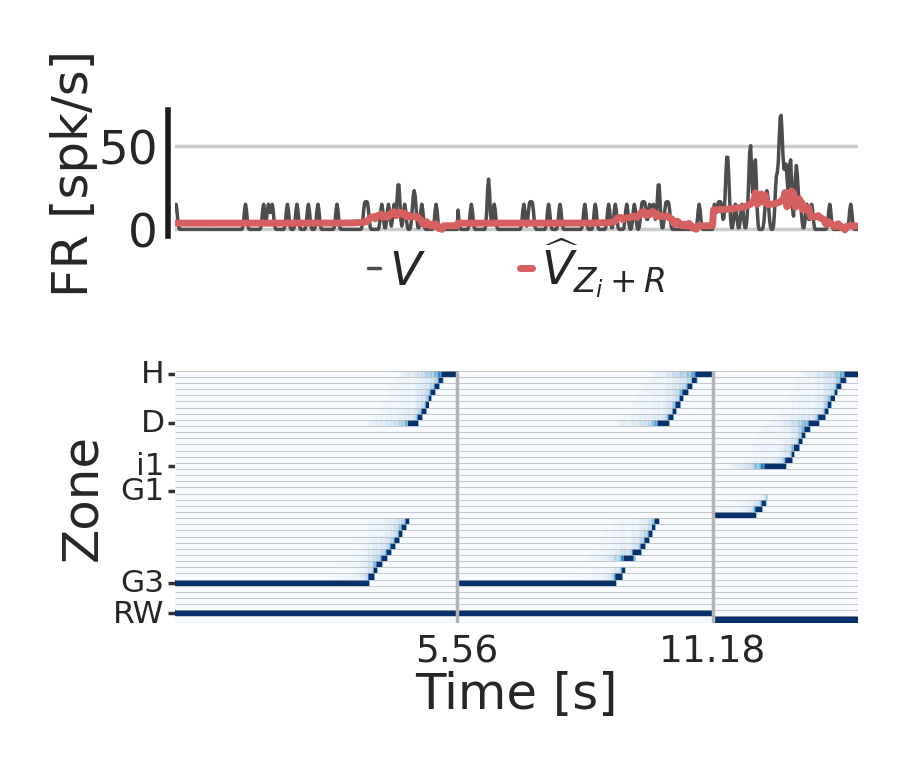

In [1278]:
unit=4
fontsize=9

fig = plt.figure(figsize=(1.7,1.3),dpi=500, constrained_layout=True)

gs = mpl.gridspec.GridSpec(3, 1, figure=fig, hspace=0.0)
ax1 = fig.add_subplot(gs[0])
ax1.tick_params(axis="both", direction="out", length=1, width=0.5, color='0.2', which='major', pad=0.5, labelsize=fontsize*0.75)

ax2 = fig.add_subplot(gs[1:])
ax2.tick_params(axis="both", direction="out", length=1, width=0.5, color='0.2', which='major', pad=0.5, labelsize=fontsize*0.75)

n_samps = len(Z_m.index)
samp_array = np.arange(n_samps)
ax1.plot(samp_array, Y[unit], lw=0.5, color='0.3', label=r'$V$')
 
labels = ['H', 'D', 'i1', 'G1', 'G3']
if cue_type=='fixed':
    labels += ['LC']
    plot_label = f'$\widehat{{V}}_{{Z+C}}$'
elif rw_type =='fixed':
    labels += ['RW']
    plot_label = f'$\widehat{{V}}_{{Z_i+R}}$'
else:
    raise NotImplementedError
ax1.plot(samp_array, Y_hat[unit], lw=1, color='r', label=plot_label)

ax1.set_xlim([0, n_samps])
ax1.set_xticks([])
sns.despine(ax=ax1, right=True, bottom=True, offset=1)
ax1.spines['left'].set_linewidth(0.8)
ax1.spines['left'].set_color('k')
ax1.grid(linewidth=0.5)
ax1.set_ylabel('FR [spk/s]', fontsize=fontsize*0.8, labelpad=0)

legend_params = dict(handlelength=0.25, handletextpad=0.2, bbox_to_anchor=[0.5,-0.25], loc='center',
                             frameon=False, labelspacing=0.02,
                             fontsize=fontsize*0.75, ncol=2)
ax1.legend(**legend_params)
 

# pos_
#tmz.plot_zone_ts_window()
sns.heatmap(Z_m.T,ax=ax2, cbar=False, cmap='Blues', rasterized=True)
#ax2.set_xticks([])
ax2.hlines(np.arange(Z_m.shape[1]+2),*ax2.get_xlim(), linewidth=0.1, color='0.7')
ax2.set_xticks([])
ax2.set_xlabel('Time [s]', fontsize=fontsize*0.8, labelpad=0)

y_ticks = ax2.get_yticks()
y_ticklabels = tmz.all_segs_names

ax2.set_yticks(np.where(np.isin(ze.feature_names, labels))[0]+0.5)

ax2.set_yticklabels(labels, ha='right', fontsize=fontsize*0.5)
ax2.tick_params(axis='y', which='major', left=True, width=0.5, length=1, labelrotation=0)
ax2.set_ylabel('Zone', fontsize=fontsize*0.8, labelpad=1)


trial_markers = np.where(np.diff(T[T_selected])>0)[0]
tt  = ze.trial_table.loc[selected_trials]
tt = np.cumsum((tt.tE_2-tt.t0)/50).values[:(n_display_trials-1)]

ax2.set_xticks(np.around(trial_markers,2))
ax2.vlines(trial_markers, *ax2.get_ylim(),linewidth=0.5, color='0.7' )
ax2.tick_params(axis='x', which='major', left=True, width=0.5, length=1, labelrotation=0, labelsize=fontsize*0.6)
ax2.set_xticklabels(tt)

In [1280]:
dpi=1500
fn = f"example_encoder_{session}_unit_{unit}_{max_lag}_ct_{cue_type}_rw_{rw_type}_dt_{dir_type}.svg"
fig.savefig(info.paths['figures']/fn, dpi=dpi, bbox_inches='tight', transpartent=True)

In [36]:
Z_m

H  a_0  a_1  a_2  a_3  a_4  a_5  a_6    D  b_0  ...  f_0  f_1  f_2  \
710   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
711   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
712   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
713   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
714   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9414  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9415  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9416  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9417  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9418  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       G3  g_0  g_1  g_2   G4  LC  RC  
710   0.0  0.0  0.0  0.0  0.0   0   1  
711   0.0  0.0  0.0  0.0  0.0   0   1  
712   0.0  0.0  0.0  0.0  0.0   0   1  
713   0.0  0.0  0.0  0.0  0.0   0   1  
714   0.0  0.0  0.0  0.0  0.0   0   1  
...   ...  ...  ...  ...  ...  ..  ..  
9414  1.0  0.0  0.0  0.0  0.0   1   0  
9415  1.0  0.0  0.0  0.0  0.0   1   0  
9416  1.0  0.0  0.0  0.0  0.0   1   0  
9417  1.0  0.0  0.0  0.0  0.0   1   0  
9418  1.0  0.0  0.0  0.0  0.0   1   0  

[1078 rows x 41 columns]

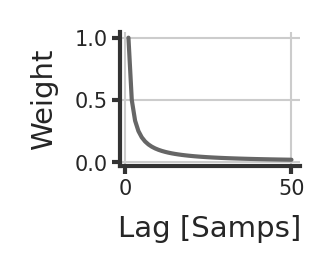

In [652]:
x= np.arange(50)+1
y = 1/x

f,ax =plt.subplots(figsize=(1,0.8),dpi=300, constrained_layout=True)
ax.plot(x, y,lw=1, color='0.4')

sns.despine(ax=ax)
ax.tick_params(axis='both', bottom=True, left=True, labelsize=fontsize-2, pad=1, length=2, width=1, color='0.2', which='major')

for sp in ['bottom', 'left']:
    ax.spines[sp].set_linewidth(1)
    ax.spines[sp].set_color('0.2')

ax.grid(linewidth=0.5)
ax.set_xlabel('Lag [Samps]', fontsize=fontsize)
ax.set_ylabel('Weight', fontsize=fontsize)
fn = "lag_weights.png"
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')


### Decoder

In [819]:
de_table =session_info.get_zone_decoder()

In [820]:
de_dec = de_table[de_table.target_type=='dec'].copy()
de_dec['cue_match'] = de_dec['pred'] == de_dec['cue']
de_dec['subj_perf'] = de_dec['correct'] == 1
de_dec['subj_perf_match'] = de_dec['subj_perf'] & (de_dec['acc'] == 1)

de_dec.loc[de_dec.zones.isin(stem_zones), 'seg'] = 'stem'
de_dec.loc[de_dec.zones.isin(branch_zones), 'seg'] = 'branch'
de_dec = de_dec.reset_index(drop=True)

In [759]:
de_dec

encoder_type feature_type target_type  fold  trial cue dec  correct  \
0               Z0      encoder         dec     0    0.0   L   L      1.0   
1               Z0      encoder         dec     4    1.0   L   R      0.0   
2               Z0      encoder         dec     4    2.0   L   L      1.0   
3               Z0      encoder         dec     2    3.0   L   L      1.0   
4               Z0      encoder         dec     0    4.0   L   R      0.0   
...            ...          ...         ...   ...    ...  ..  ..      ...   
13995       neural       neural         dec     1  139.0   R   R      1.0   
13996       neural       neural         dec     4  140.0   R   L      0.0   
13997       neural       neural         dec     4  141.0   R   R      1.0   
13998       neural       neural         dec     4  142.0   R   R      1.0   
13999       neural       neural         dec     4  143.0   R   L      0.0   

       long zones  ...  acc       bac  dist  pr_target   pr_pred  logit_dist  \
0       0.0     H  ...  0.0  0.500000   1.0   0.499875  0.500125    0.000999   
1       NaN     H  ...  1.0  0.500000   0.0   0.525372  0.525372    0.000000   
2       0.0     H  ...  0.0  0.500000   1.0   0.474628  0.525372    0.203151   
3       1.0     H  ...  0.0  0.500000   1.0   0.468048  0.531952    0.255964   
4       NaN     H  ...  1.0  0.500000   0.0   0.500125  0.500125    0.000000   
...     ...   ...  ...  ...       ...   ...        ...       ...         ...   
13995   0.0     G  ...  1.0  0.728365   0.0   0.801587  0.801587    0.000000   
13996   NaN     G  ...  1.0  0.582418   0.0   0.872849  0.872849    0.000000   
13997   0.0     G  ...  0.0  0.582418   1.0   0.179512  0.820488    3.039311   
13998   1.0     G  ...  0.0  0.582418   1.0   0.217955  0.782045    2.555253   
13999   NaN     G  ...  1.0  0.582418   0.0   0.929844  0.929844    0.000000   

       cue_match  subj_perf  subj_perf_match     seg  
0          False       True            False    stem  
1          False      False            False    stem  
2          False       True            False    stem  
3          False       True            False    stem  
4          False      False            False    stem  
...          ...        ...              ...     ...  
13995       True       True             True  branch  
13996      False      False            False  branch  
13997      False       True            False  branch  
13998      False       True            False  branch  
13999      False      False            False  branch  

[14000 rows x 22 columns]

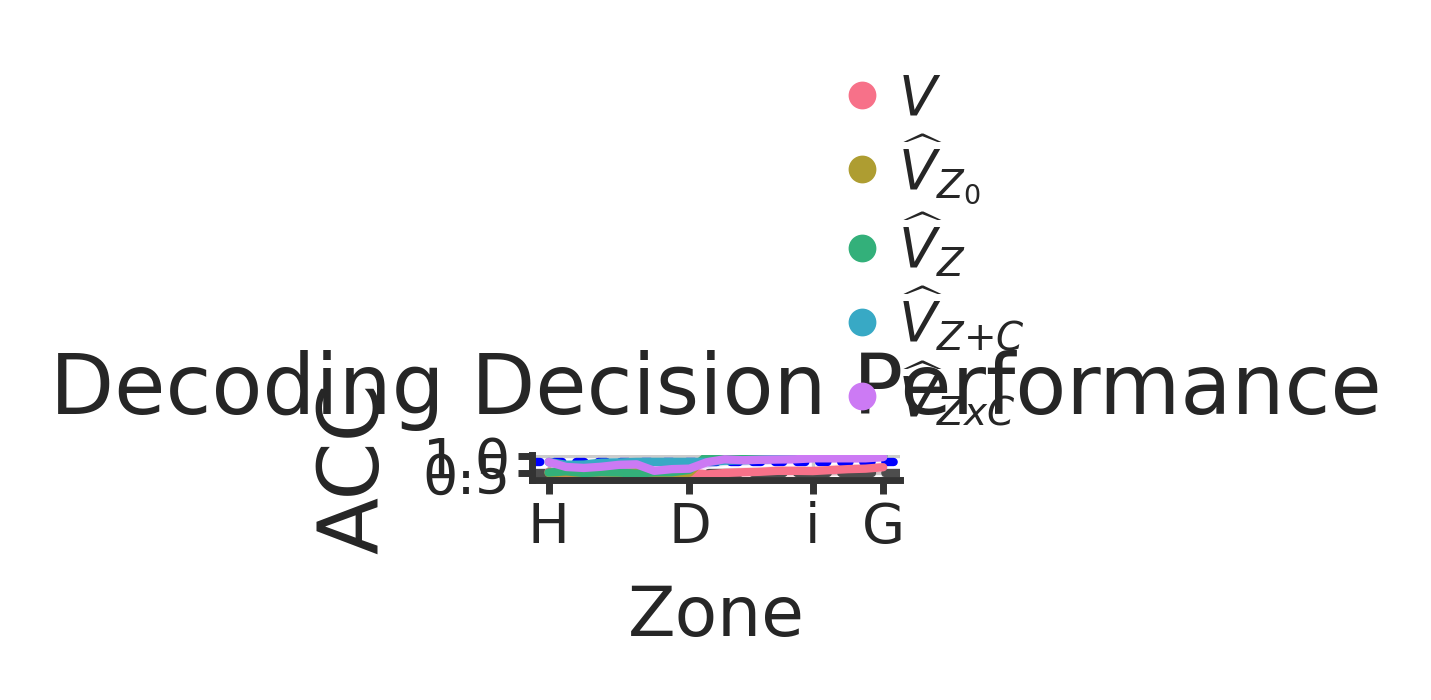

In [829]:
hue_var='encoder_type'
metric='acc'
f,ax = plt.subplots(figsize=(1.6,.8), dpi=500, constrained_layout=True )
decoder_perf_x_zone(data_table=de_dec, hue_var=hue_var,  metric=metric, ax=ax)


if metric =='bac':
    ax.set_ylabel('BAC', fontsize=fontsize)
elif metric =='acc':
    ax.set_ylabel('ACC', fontsize=fontsize)

    
ax.axhline(0.5,linestyle='--', color='0.3', zorder=1, label='Subj')
ax.set_ylim([0.28,1.02])

subj_perf =de_dec[(de_dec.encoder_type=='neural') & (de_dec.zones=='H')]['correct'].mean()

ax.axhline(subj_perf, linestyle=':', color='blue', zorder=1)
ax.set_title('Decoding Decision Performance',fontsize=fontsize) 
 
fn = f"examp_session_dec_decoder_{metric}_x_{hue_var}.png"
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')


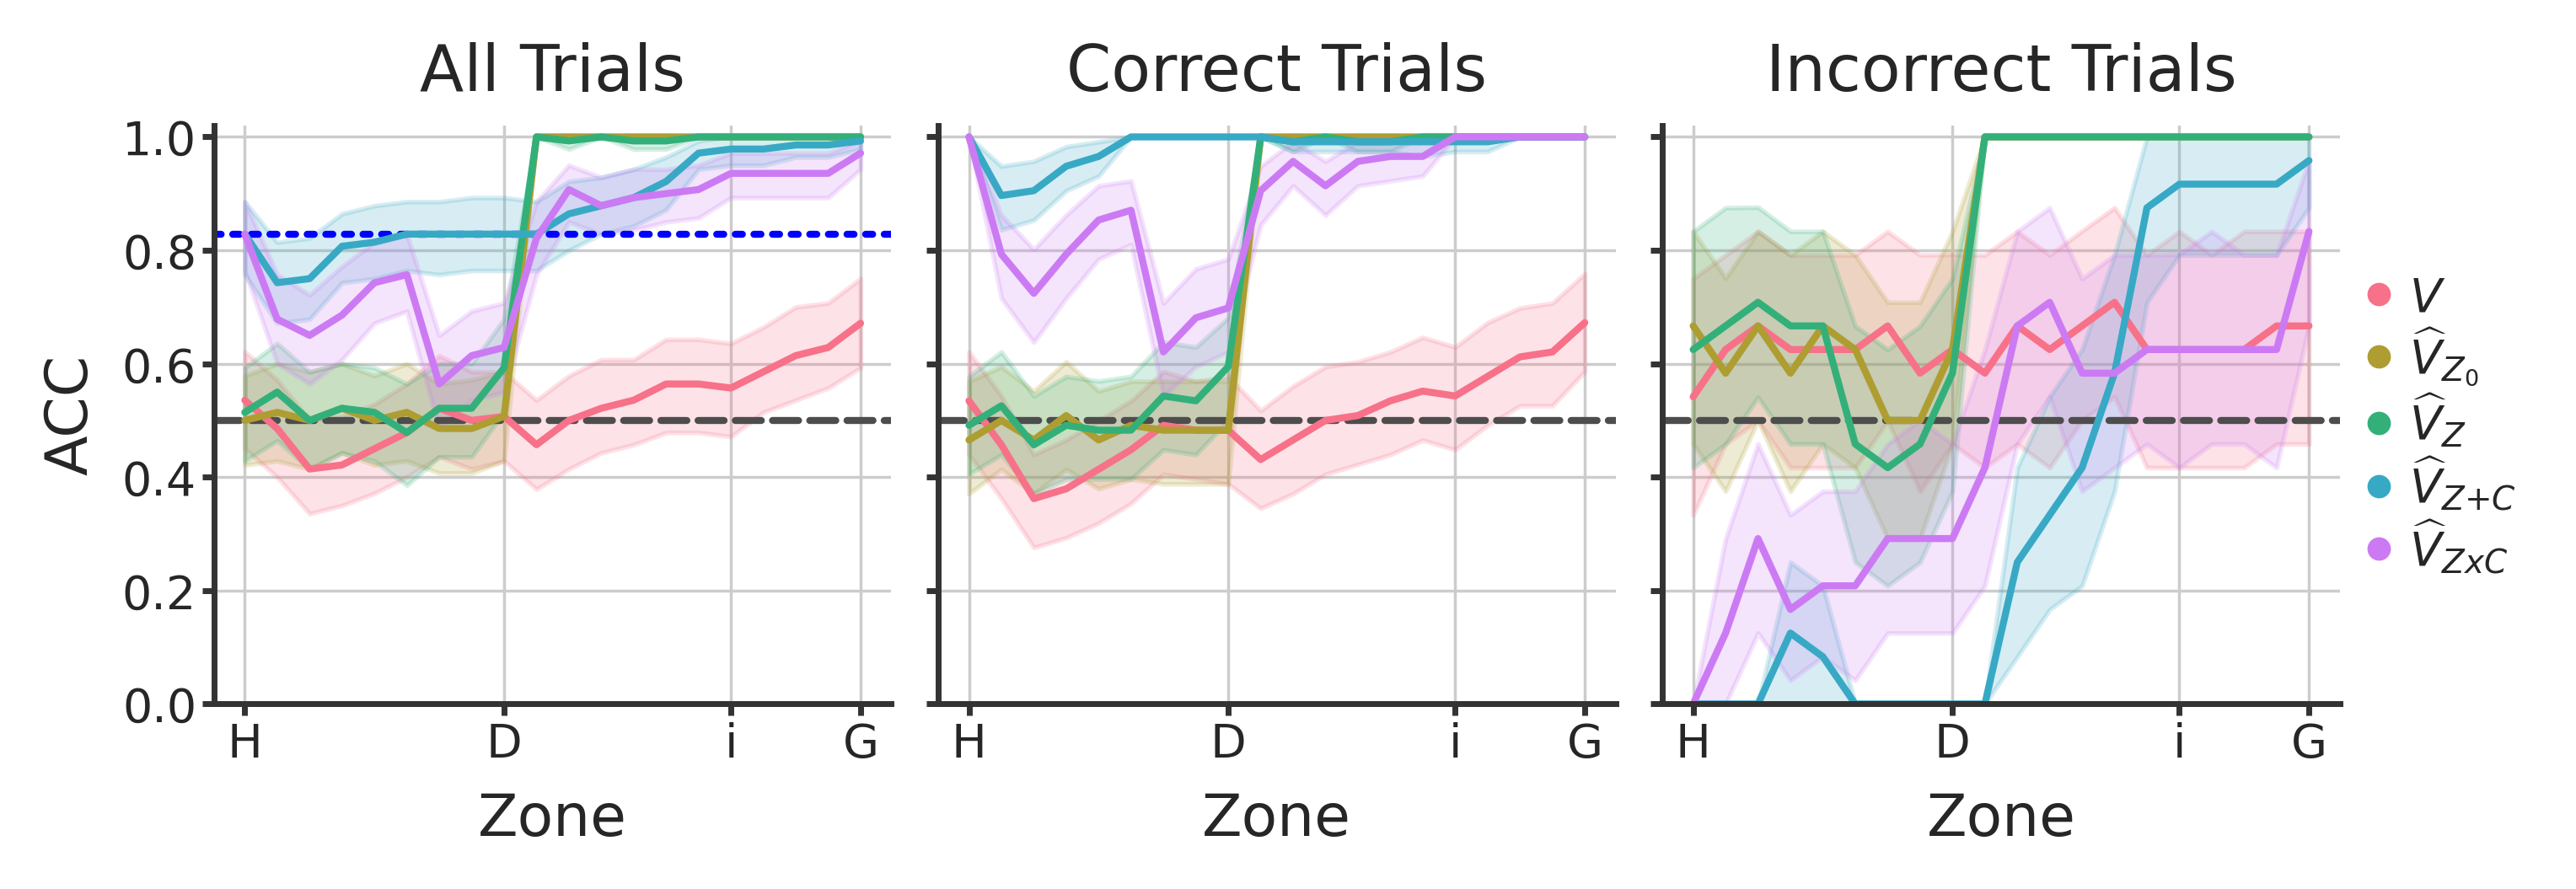

In [835]:
f,axs=plt.subplots(1,3, figsize=(6,2), dpi=500, constrained_layout=True )

metric = 'acc'

ax = axs[0]
decoder_perf_x_zone(de_dec, hue_var=hue_var, metric=metric, ax=ax)
ax.axhline(0.5,linestyle='--', color='0.3', zorder=1, label='Subj')
ax.set_ylim([0,1.02])
ax.get_legend().remove()
subj_perf =de_dec[(de_dec.encoder_type=='neural') & (de_dec.zones=='H')]['correct'].mean()
ax.axhline(subj_perf, linestyle=':', color='blue', zorder=1)
ax.set_title("All Trials", fontsize=fontsize-1)


ax.set_ylabel('ACC', fontsize=fontsize-2)
ax = axs[1]

decoder_perf_x_zone(de_dec[de_dec.correct==1], hue_var=hue_var, metric=metric, ax=ax)
ax.axhline(0.5,linestyle='--', color='0.3', zorder=1, label='Subj')
ax.set_ylim([0,1.02])
ax.set_yticklabels('')
ax.set_ylabel('')
ax.get_legend().remove()

ax.set_title("Correct Trials", fontsize=fontsize-1)

ax = axs[2]

decoder_perf_x_zone(de_dec[de_dec.correct==0], hue_var=hue_var, metric=metric, ax=ax)
ax.axhline(0.5,linestyle='--', color='0.3', zorder=1, label='Subj')
ax.set_ylim([0,1.02])
ax.set_yticklabels('')
ax.set_ylabel('')
ax.set_title("Incorrect Trials", fontsize=fontsize-1)
l = ax.get_legend()
#bbox_to_anchor=[1.1,0.2]
l.set_bbox_to_anchor([1.15,0.15])
fn = f"examp_session_dec_decoder_coinco_{metric}_x_{hue_var}.png"
f.savefig(fig_path/fn, dpi=dpi, bbox_inches='tight')



8.285714285714286e-01

In [674]:

np.cumsum((tt.tE_2-tt.t0)/50).values

array([ 8.84, 18.08, 26.66])

array([442, 905])

decay function

In [601]:
np.where(np.isin(tmz.all_segs_names, labels))[0]

array([ 0,  8, 15, 19, 23, 30, 34, 38])

<Figure size 6200x3700 with 0 Axes>

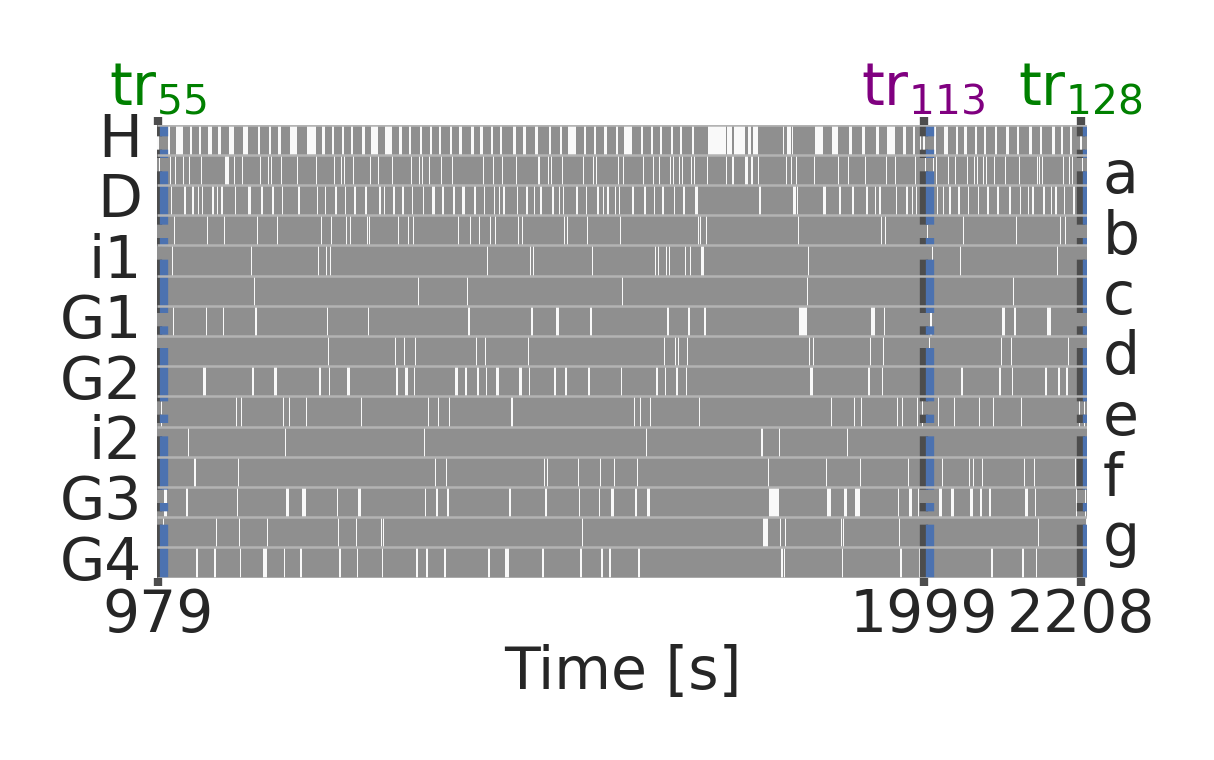

In [581]:
f1=pf.Fig1(session=session, **dict(panel_c={'h_lw': 0.3, 'v_lw': 1, 'samp_buffer': 20,'trial_nums':np.sort(selected_trials)}))
f1.panel_c()

In [582]:
samp_buffer=20
a = session_info.get_track_data()
b = session_info.get_event_behavior()
trial_table = b.trial_table
trial_nums = selected_trials

samps = np.arange(trial_table.loc[trial_nums[0], 't0'] - samp_buffer,
                              trial_table.loc[trial_nums[-1], 'tE'] + samp_buffer)
pzm = session_info.get_pos_zones_mat()


<AxesSubplot:>

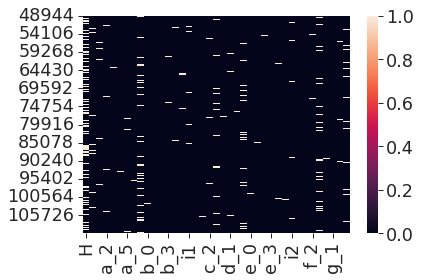

(61932,)

In [578]:
trial_table.loc[trial_nums[0], 't0'] - samp_buffer

110407

In [563]:
trial_table.loc[trial_nums[0], 't0'],  trial_table.loc[trial_nums[-1], 'tE']

(110427, 49406)

In [558]:
b.trial_table.loc[selected_trials[0]]

t0         110427
tD         110591
tE         110856
tE_1       110752
tE_2       110856
dur           429
cue             L
dec             L
correct       1.0
long          1.0
goal          4.0
grw             1
sw              0
vsw             0
Name: 128, dtype: object

In [450]:
selected_trials

array([51, 68])

In [550]:
?sns.heatmap

Signature:
sns.heatmap(
    data,
    *,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwise

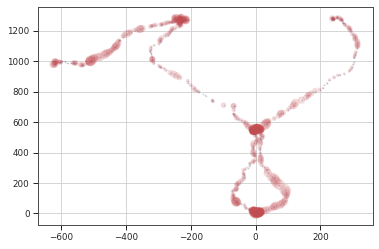

In [445]:
plt.scatter(Pos.x,Pos.y,s=1, alpha=0.2)
plt.scatter(Pos.x,Pos.y,s=Y[0], alpha=0.2, color='r',linewidths=0)


In [482]:

ec_m[ec_m.session==session].sort_values('score')

unit_id        session subject task unit_type cue_type     score
197     65.0  Li_T3g_060418      Li  T3g       mua    inter -0.003288
195     65.0  Li_T3g_060418      Li  T3g       mua     none  0.002355
196     65.0  Li_T3g_060418      Li  T3g       mua    fixed  0.003957
224     74.0  Li_T3g_060418      Li  T3g       mua    inter  0.018068
206     68.0  Li_T3g_060418      Li  T3g       mua    inter  0.019133
222     74.0  Li_T3g_060418      Li  T3g       mua     none  0.019973
204     68.0  Li_T3g_060418      Li  T3g       mua     none  0.021572
223     74.0  Li_T3g_060418      Li  T3g       mua    fixed  0.022434
209     69.0  Li_T3g_060418      Li  T3g       mua    inter  0.026534
207     69.0  Li_T3g_060418      Li  T3g       mua     none  0.026982
205     68.0  Li_T3g_060418      Li  T3g       mua    fixed  0.027122
221     73.0  Li_T3g_060418      Li  T3g       mua    inter  0.027734
219     73.0  Li_T3g_060418      Li  T3g       mua     none  0.029981
220     73.0  Li_T3g_060418      Li  T3g       mua    fixed  0.033391
188     62.0  Li_T3g_060418      Li  T3g       mua    inter  0.037111
165     55.0  Li_T3g_060418      Li  T3g      cell     none  0.040896
186     62.0  Li_T3g_060418      Li  T3g       mua     none  0.041003
187     62.0  Li_T3g_060418      Li  T3g       mua    fixed  0.041448
208     69.0  Li_T3g_060418      Li  T3g       mua    fixed  0.041980
167     55.0  Li_T3g_060418      Li  T3g      cell    inter  0.042053
185     61.0  Li_T3g_060418      Li  T3g       mua    inter  0.042532
184     61.0  Li_T3g_060418      Li  T3g       mua    fixed  0.049099
183     61.0  Li_T3g_060418      Li  T3g       mua     none  0.049600
200     66.0  Li_T3g_060418      Li  T3g       mua    inter  0.051138
199     66.0  Li_T3g_060418      Li  T3g       mua    fixed  0.052755
198     66.0  Li_T3g_060418      Li  T3g       mua     none  0.053260
203     67.0  Li_T3g_060418      Li  T3g       mua    inter  0.059630
201     67.0  Li_T3g_060418      Li  T3g       mua     none  0.064292
166     55.0  Li_T3g_060418      Li  T3g      cell    fixed  0.065173
202     67.0  Li_T3g_060418      Li  T3g       mua    fixed  0.066346
176     58.0  Li_T3g_060418      Li  T3g      cell    inter  0.073858
174     58.0  Li_T3g_060418      Li  T3g      cell     none  0.074580
181     60.0  Li_T3g_060418      Li  T3g      cell    fixed  0.076663
175     58.0  Li_T3g_060418      Li  T3g      cell    fixed  0.076696
180     60.0  Li_T3g_060418      Li  T3g      cell     none  0.076906
182     60.0  Li_T3g_060418      Li  T3g      cell    inter  0.077973
218     72.0  Li_T3g_060418      Li  T3g       mua    inter  0.086388
216     72.0  Li_T3g_060418      Li  T3g       mua     none  0.088738
217     72.0  Li_T3g_060418      Li  T3g       mua    fixed  0.094109
189     63.0  Li_T3g_060418      Li  T3g       mua     none  0.132236
190     63.0  Li_T3g_060418      Li  T3g       mua    fixed  0.133960
191     63.0  Li_T3g_060418      Li  T3g       mua    inter  0.135692
215     71.0  Li_T3g_060418      Li  T3g       mua    inter  0.140339
213     71.0  Li_T3g_060418      Li  T3g       mua     none  0.142895
214     71.0  Li_T3g_060418      Li  T3g       mua    fixed  0.143581
192     64.0  Li_T3g_060418      Li  T3g       mua     none  0.170035
194     64.0  Li_T3g_060418      Li  T3g       mua    inter  0.170468
193     64.0  Li_T3g_060418      Li  T3g       mua    fixed  0.177905
212     70.0  Li_T3g_060418      Li  T3g       mua    inter  0.192368
211     70.0  Li_T3g_060418      Li  T3g       mua    fixed  0.195513
210     70.0  Li_T3g_060418      Li  T3g       mua     none  0.195591
179     59.0  Li_T3g_060418      Li  T3g      cell    inter  0.203815
177     59.0  Li_T3g_060418      Li  T3g      cell     none  0.206870
178     59.0  Li_T3g_060418      Li  T3g      cell    fixed  0.208392
173     57.0  Li_T3g_060418      Li  T3g      cell    inter  0.269439
171     57.0  Li_T3g_060418      Li  T3g      cell     none  0.270483
172     57.0  L

In [435]:
Y[0].shape, Pos.shape



((2422,), (2422, 3))

## Encoder layout illustration

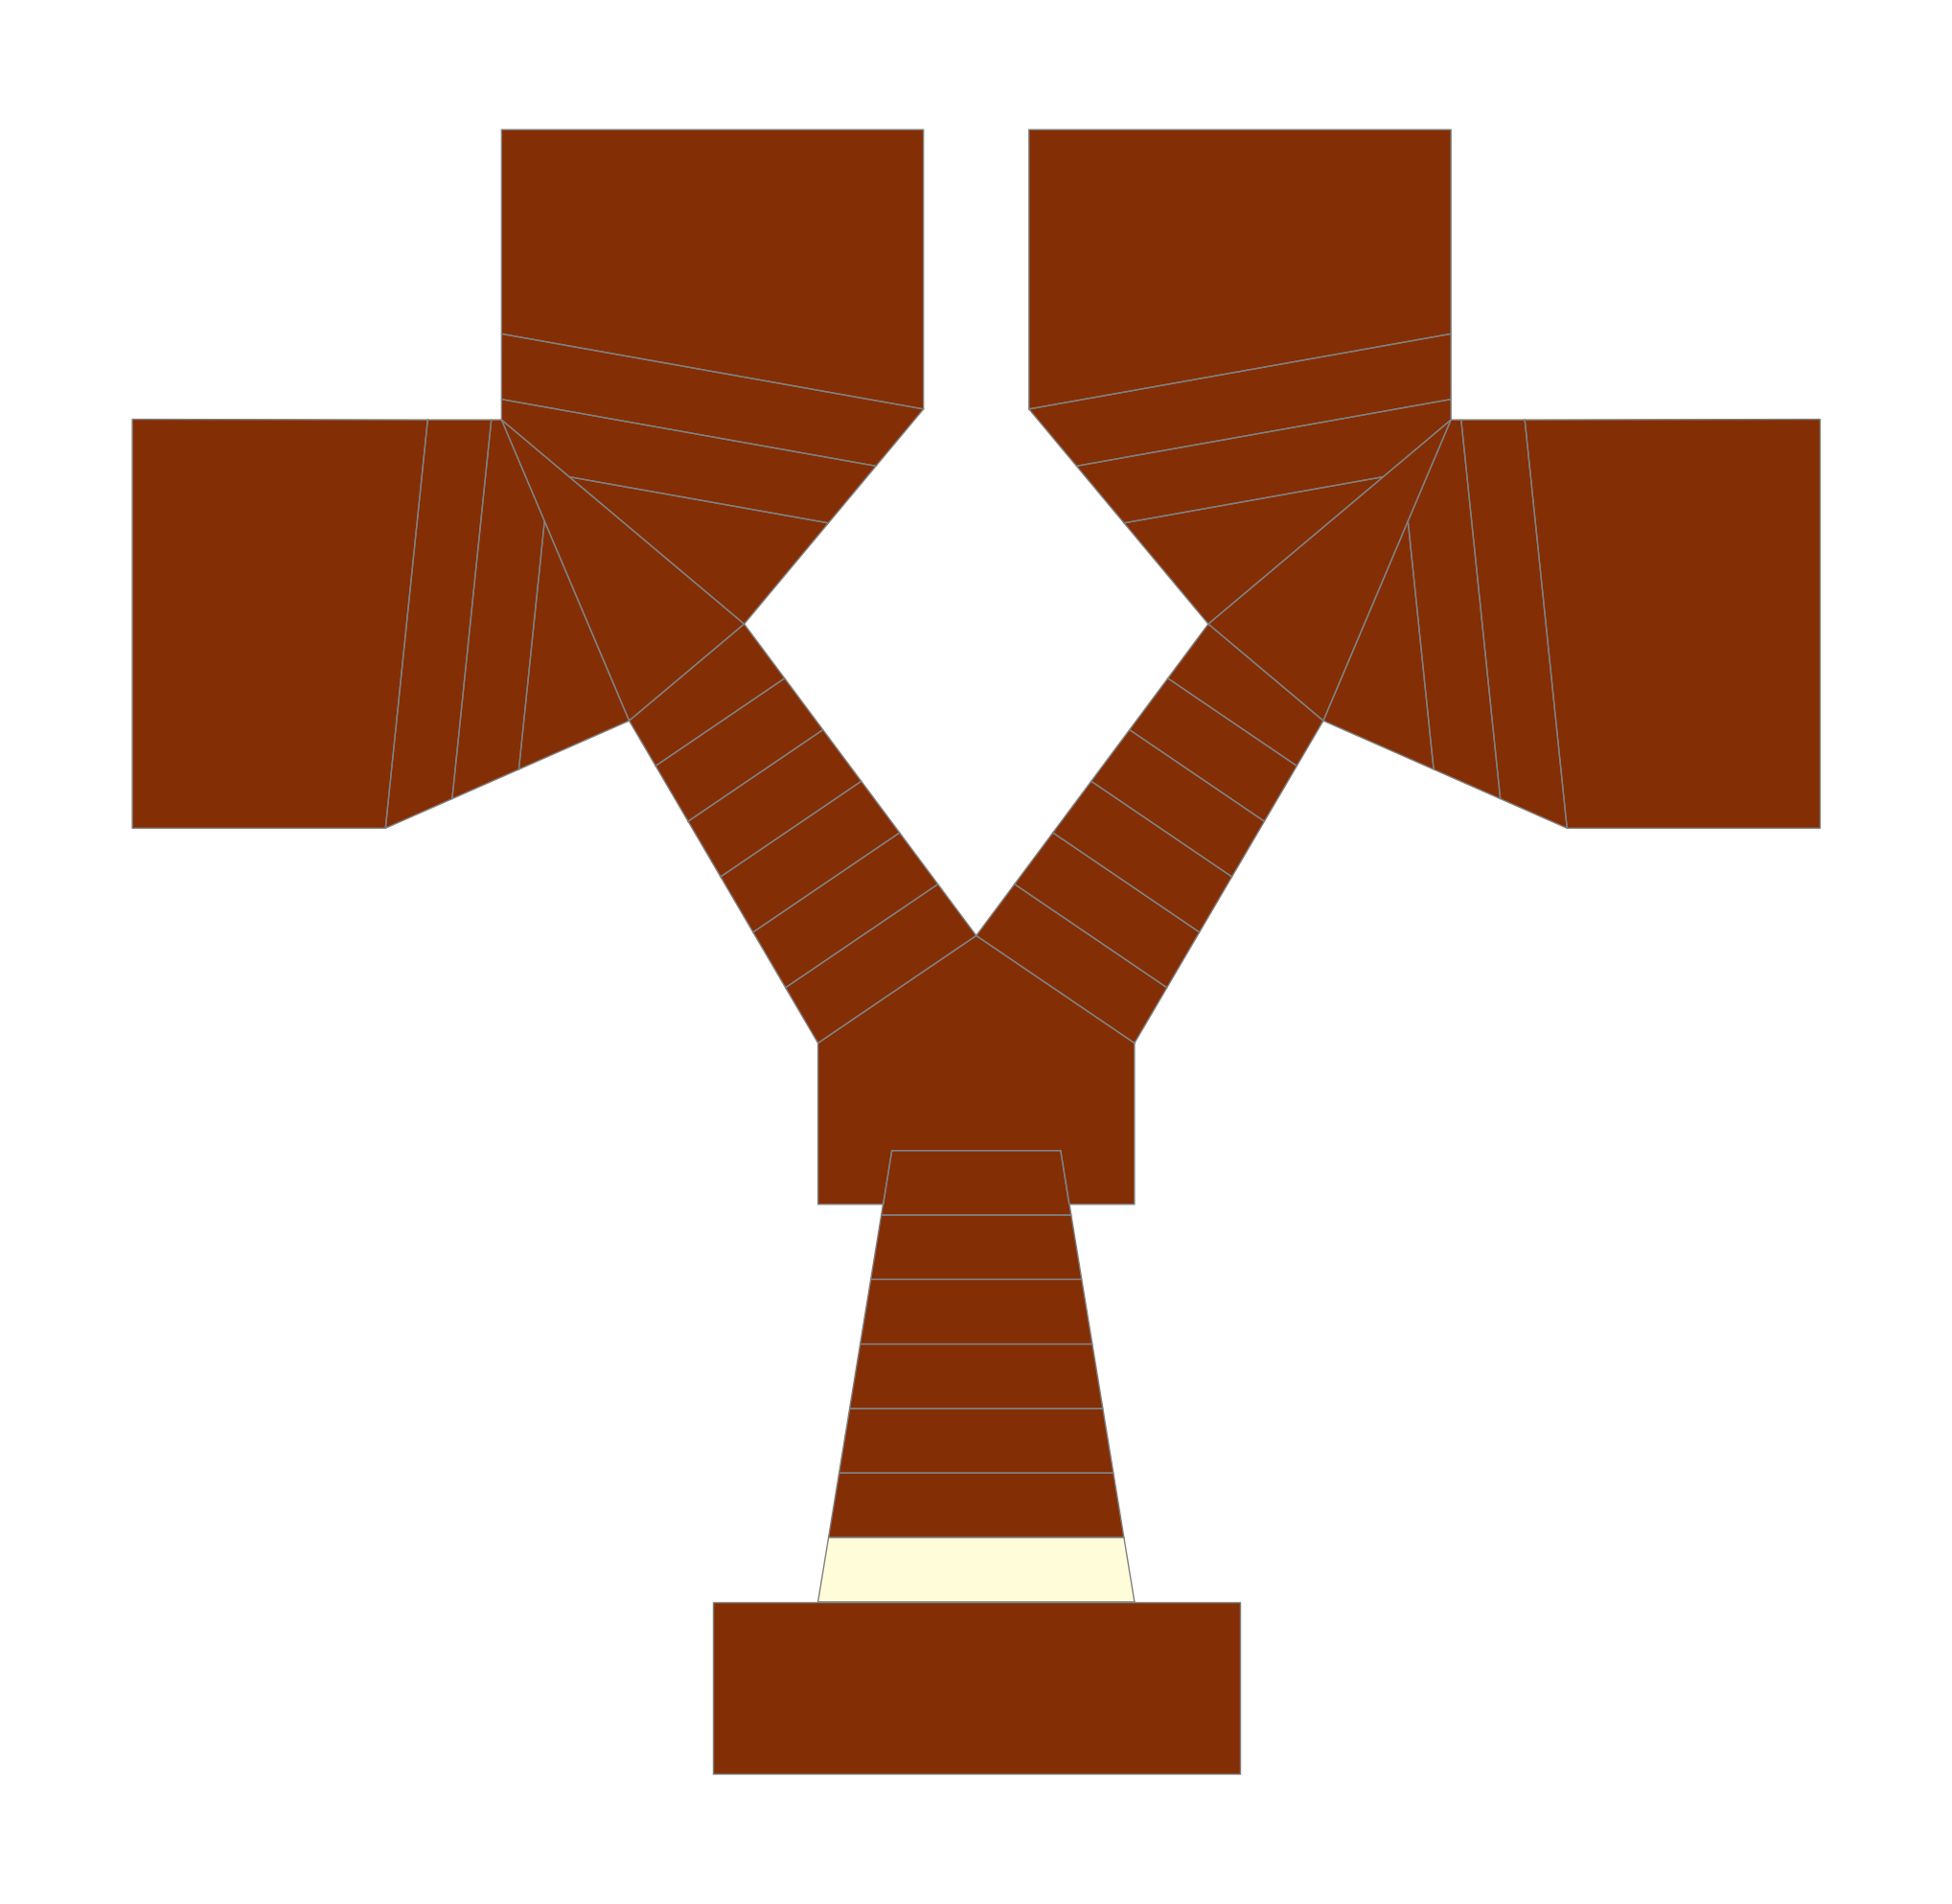

In [375]:
a = pd.DataFrame(np.zeros((1,39)),columns=tmf.all_segs_names)
a['a_0'] = 1
tmf.plot_zone_activity(a, legend=False)